In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from random import randrange
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from scipy.stats import chi2
import warnings
import sys
import multiprocessing

sys.path.append(os.path.join(os.path.dirname(
    os.path.abspath(''))))
import common.plots as plots
import potential_data
import fit

warnings.simplefilter("ignore", OptimizeWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [4]:
def plot_T_fit(df, df_pot, decomposition_type, image_path):
    r = df.name[0]
    smearing_step = df.name[1]
    fg = plots.make_plot(df[(df['r/a'] == r) & (df['smearing_step'] == smearing_step)], 'T', 'aV(r)', 'range', 'T', 'aV(r)', f'potential {decomposition_type} smearing_step={smearing_step}', f'{image_path}/r={r}', \
                         f'potential_monopole_smearing_step={smearing_step}', False)
    df1 = df_pot[(df_pot['r/a'] == r) & (df_pot['smearing_step'] == smearing_step)]
    fg.ax.errorbar(df1['T'], df1['aV(r)'], df1['err'], mfc=None, fmt='o', ms=6, capsize=5, lw=0.5, ls=None)
    plots.save_image(f'{image_path}/r={r}', f'potential_monopole_smearing_step={smearing_step}', fg)
    plt.close()

def plot_T_fit_gevp(df, df_pot, decomposition_type, image_path):
    r = df.name
    fg = plots.make_plot(df, 'time_size', 'potential', 'range', 'T', 'aV(r)', f'potential {decomposition_type}', f'{image_path}/r={r}', \
                         f'potential_{decomposition_type}', False)
    df1 = df_pot[df_pot['space_size'] == r]
    fg.ax.errorbar(df1['time_size'], df1['potential'], df1['err'], mfc=None, fmt='o', ms=6, capsize=5, lw=0.5, ls=None)
    plots.save_image(f'{image_path}/r={r}', f'potential_{decomposition_type}', fg)
    plt.show()
    plt.close()

def potential_T_fit(lattice_size, L, beta, smearing, additional_params, decomposition_type, copy=None):
    paths = [{'path': f'../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/{lattice_size}/beta{beta}/{smearing}/{additional_params}/potential_{decomposition_type}.csv',
            'parameters': {'beta': f'beta={beta}'}, 'constraints': {'r/a': (1, L // 2), 'T': (1, L // 2 - 1)}}]
    if copy is not None:
        paths[0]['constraints'] = {'copy': (copy, copy)}
    image_path = f'../../images/smearing/potential/su3/gluodynamics/T_fit/{lattice_size}/beta{beta}/{smearing}/{additional_params}/{decomposition_type}'
    print(paths[0]['path'])
    df = potential_data.get_potantial_df(paths, coluns_to_multiindex=['smearing_step'])
    df_fit = df.groupby(df.index.names + ['r/a']).apply(fit.make_fit_range, fit.func_exponent, ['V', 'a', 'b'], 'T', 'aV(r)', 'err', L // 2 - 4).reset_index(level=-1, drop=True).reset_index(level=df.index.names + ['r/a'])
    df_curve = df_fit.groupby(df.index.names + ['r/a', 'T_min', 'T_max']).apply(fit.make_fit_curve, fit.func_exponent, 'T', 'aV(r)', ['V', 'a', 'b']).reset_index(level=-1, drop=True).reset_index(level=df.index.names + ['r/a', 'T_min', 'T_max'])
    # df_fit = df.groupby(df.index.names + ['r/a']).apply(fit.make_fit_range, fit.func_double_exponent, ['V', 'a', 'b', 'c', 'd'], 'T', 'aV(r)', 'err', L // 2 - 4).reset_index(level=-1, drop=True).reset_index(level=df.index.names + ['r/a'])
    # df_curve = df_fit.groupby(df.index.names + ['r/a', 'T_min', 'T_max']).apply(fit.make_fit_curve, fit.func_double_exponent, 'T', 'aV(r)', ['V', 'a', 'b', 'c', 'd']).reset_index(level=-1, drop=True).reset_index(level=df.index.names + ['r/a', 'T_min', 'T_max'])
    df_curve['range'] = '(' + df_curve['T_min'].astype(str) + ', ' + df_curve['T_max'].astype(str) + ')'
    df = df.reset_index(level=['smearing_step'])
    df_curve.groupby(['r/a', 'smearing_step']).apply(plot_T_fit, df, decomposition_type, image_path)

def potential_gevp_T_fit(potential_algorithm, lattice_size, gauge_group, conf_type, L, beta, mu, smearing, additional_params, decomposition_type, copy=None):
    paths = [{'path': f'../../result/{potential_algorithm}/adjoint/on-axis/{gauge_group}/{conf_type}/{lattice_size}/{beta}/{mu}/{decomposition_type}/{smearing}/{additional_params}/potential_0.csv',
            'parameters': {'mu': f'{mu}'}}]
    if copy is not None:
        paths[0]['constraints'] = {'copy': (copy, copy)}
    image_path = f'../../images/{potential_algorithm}/{gauge_group}/{conf_type}/T_fit/{lattice_size}/{beta}/{mu}/{smearing}/{additional_params}/{decomposition_type}'
    df = potential_data.get_potantial_df(paths)
    df = df[df['time_size'] <= 12]
    # print(df)
    df_fit = df.set_index(['space_size']).groupby(['space_size']).apply(fit.make_fit_range, fit.func_exponent, ['V', 'a', 'b'], 'time_size', 'potential', 'err', 24 // 2 - 3, include_groups=False).reset_index(level=-1, drop=True).reset_index(level=['space_size'])
    # print(df_fit)
    df_curve = df_fit.set_index(['space_size', 'time_size_min', 'time_size_max']).groupby(['space_size', 'time_size_min', 'time_size_max']).apply(fit.make_fit_curve, fit.func_exponent, 'time_size', 'potential', ['V', 'a', 'b'], include_groups=False)\
        .reset_index(level=-1, drop=True).reset_index(level=['space_size', 'time_size_min', 'time_size_max'])
    df_curve['range'] = '(' + df_curve['time_size_min'].astype(str) + ', ' + df_curve['time_size_max'].astype(str) + ')'
    df_curve.set_index('space_size').groupby('space_size').apply(plot_T_fit_gevp, df, decomposition_type, image_path, include_groups=False)

In [5]:
potential_gevp_T_fit('potential_gevp', '16^4', 'su3', 'gluodynamics', 16, 'beta6.0', '/', 'HYP0_alpha=1_1_0.5_APE_alpha=0.5', 'steps_0/copies=20', 'abelian', copy=None)

ValueError: No objects to concatenate

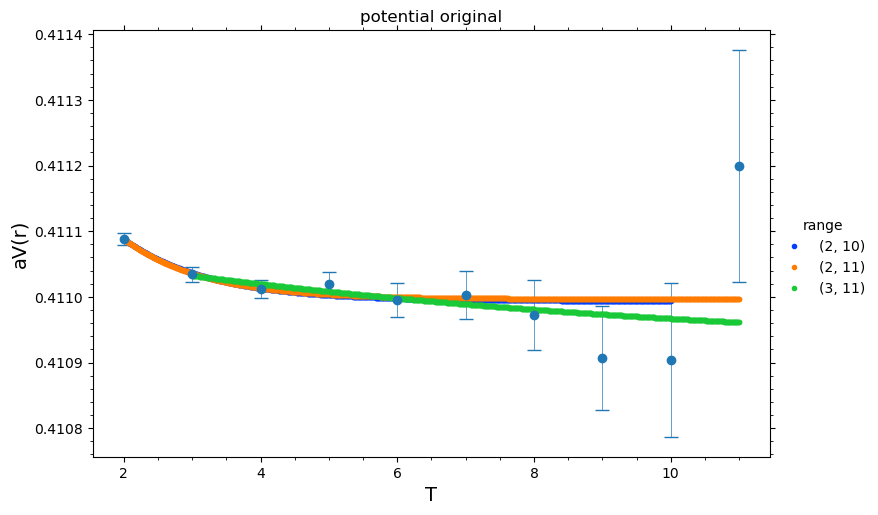

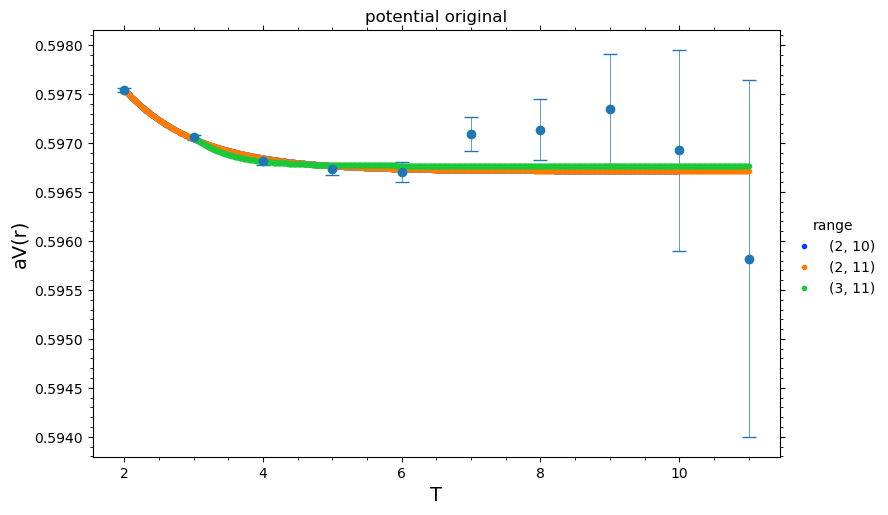

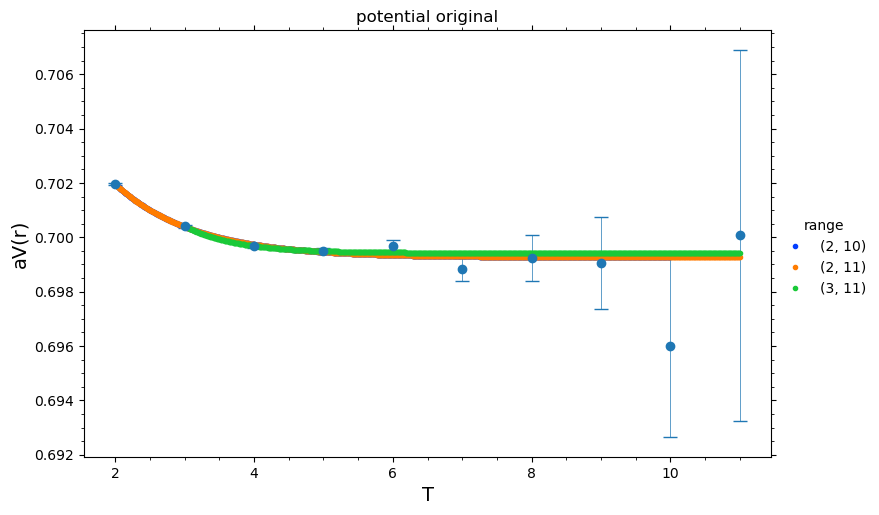

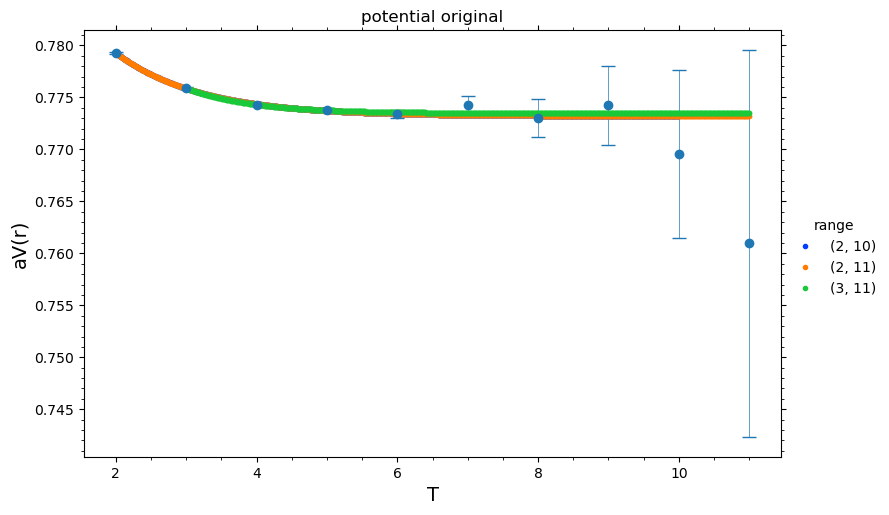

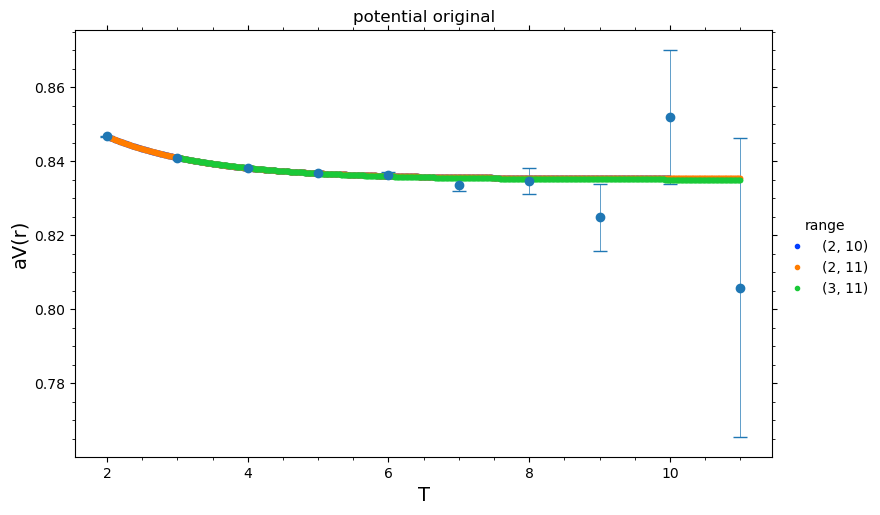

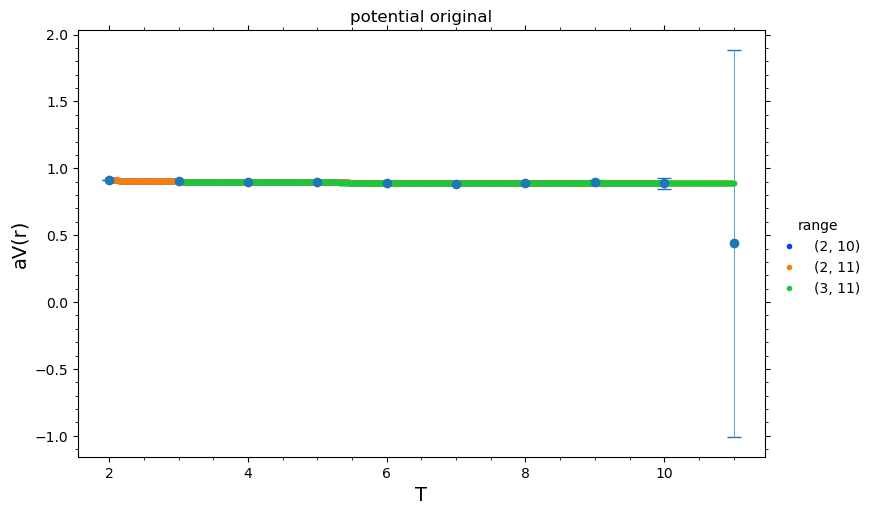

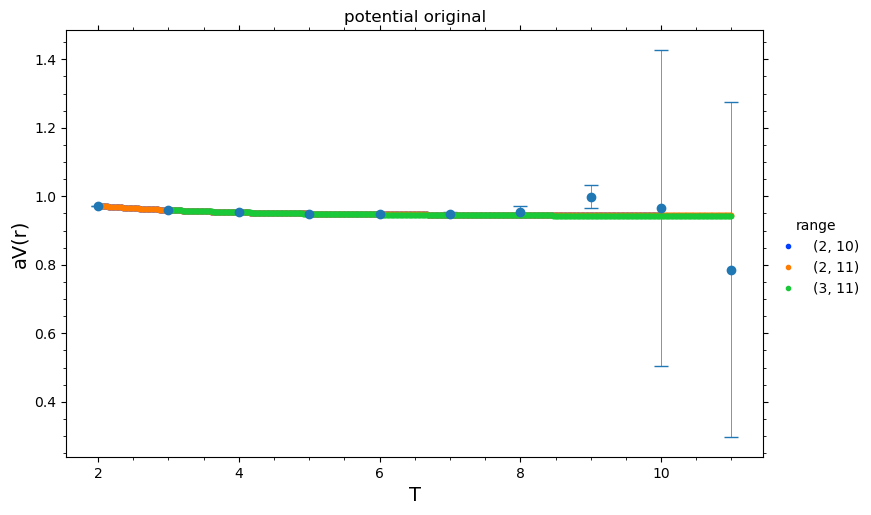

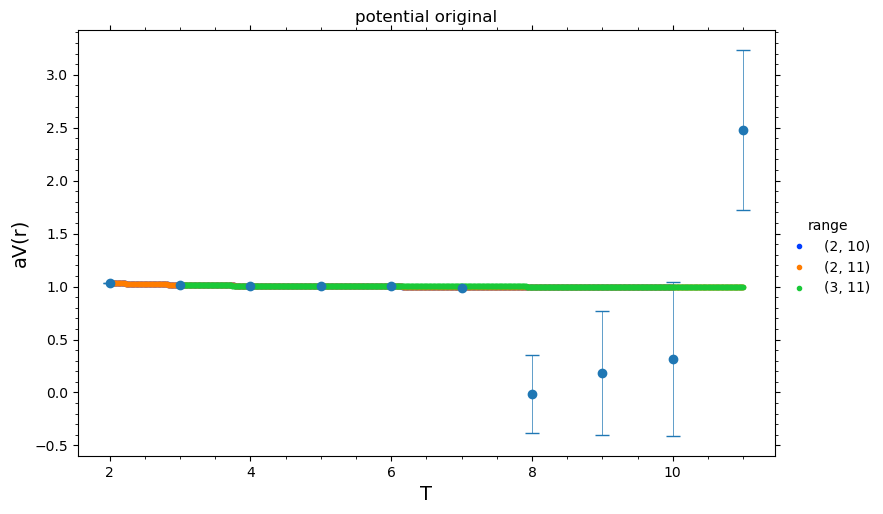

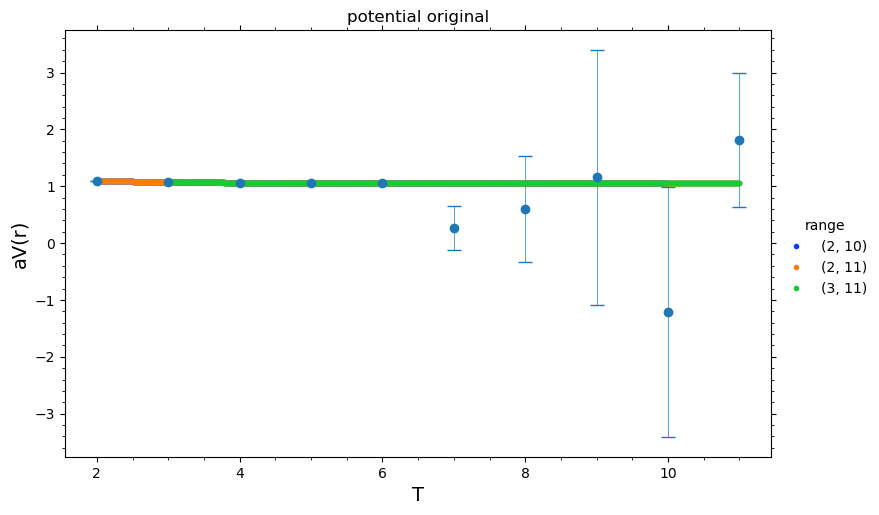

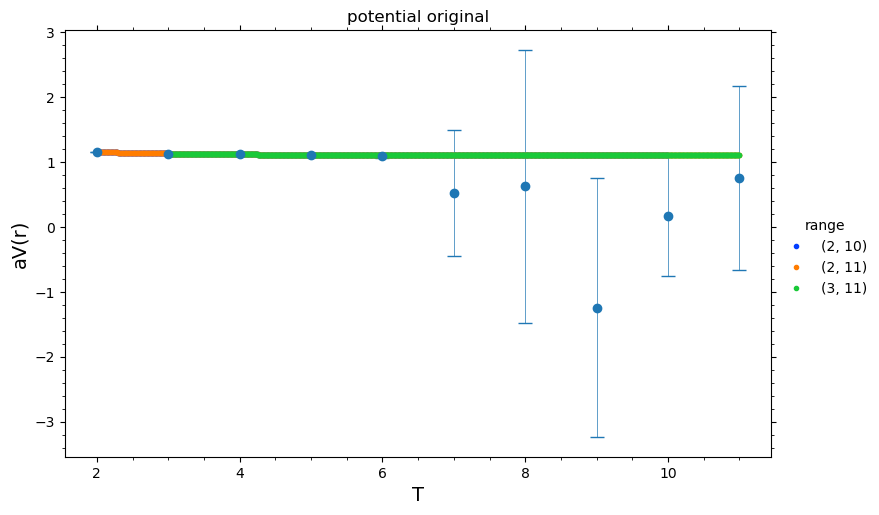

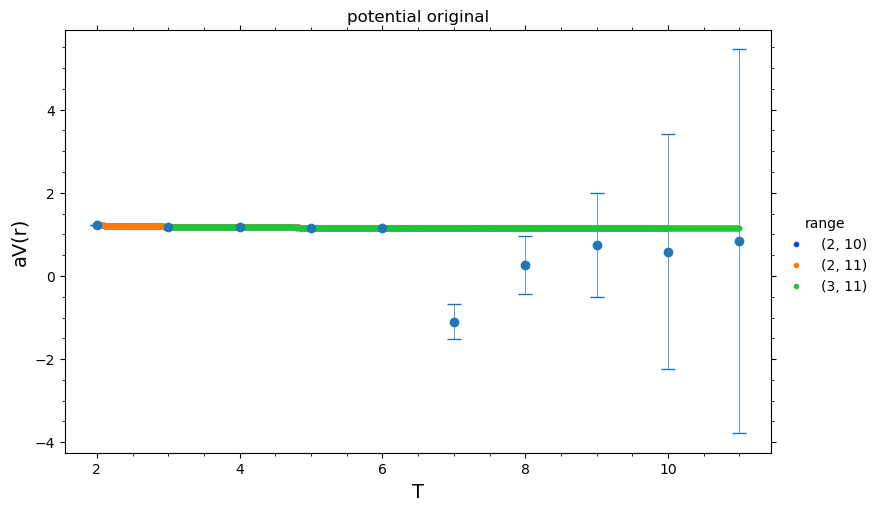

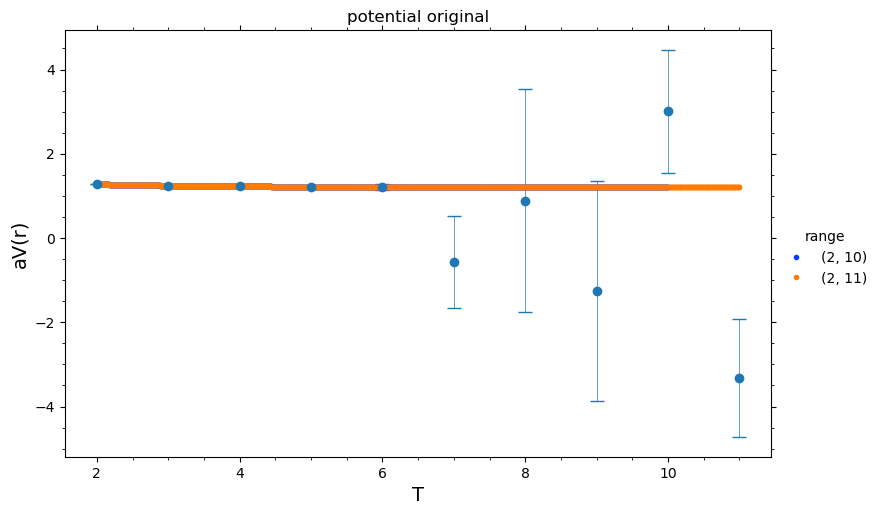

In [5]:
potential_gevp_T_fit('potential_gevp', '24^4', 'su3', 'gluodynamics', 24, 'beta6.0', '/', 'HYP0_alpha=1_1_0.5_APE_alpha=0.5', '', 'original', copy=None)

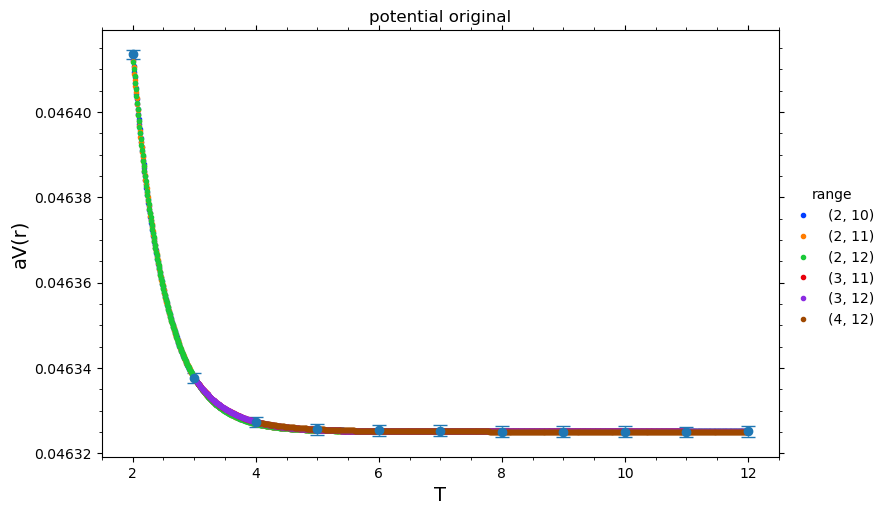

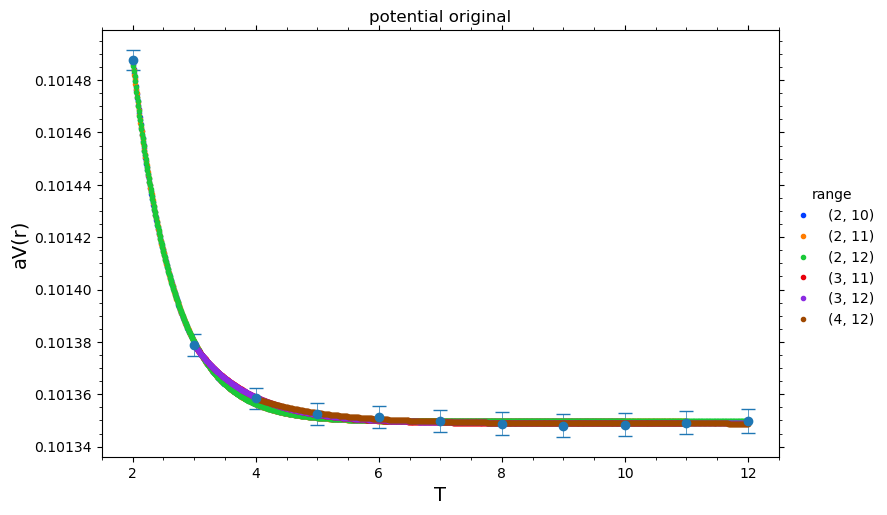

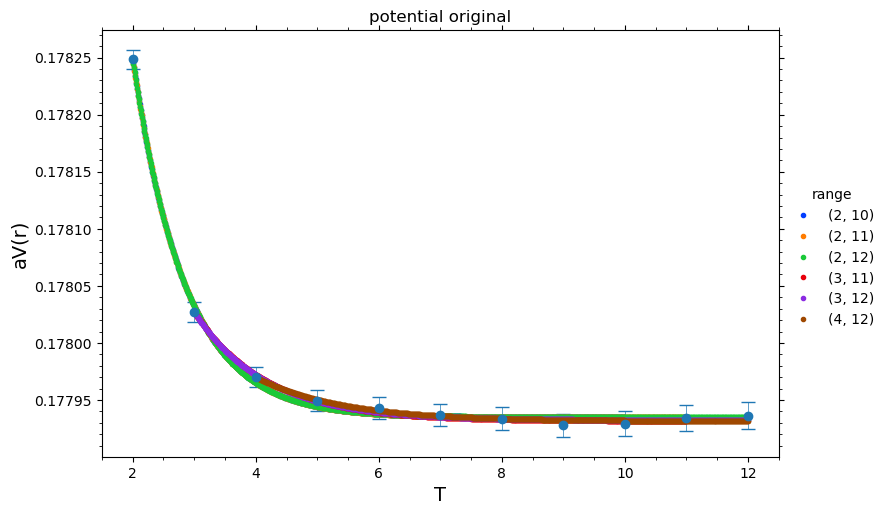

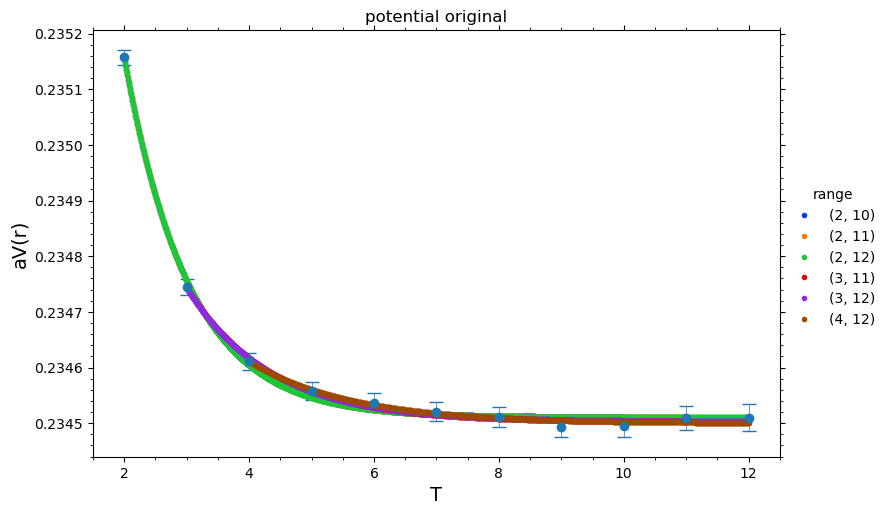

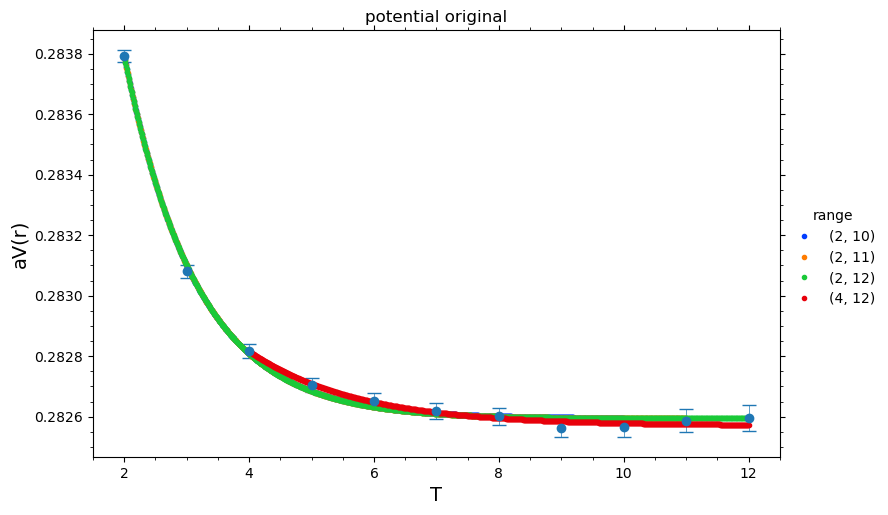

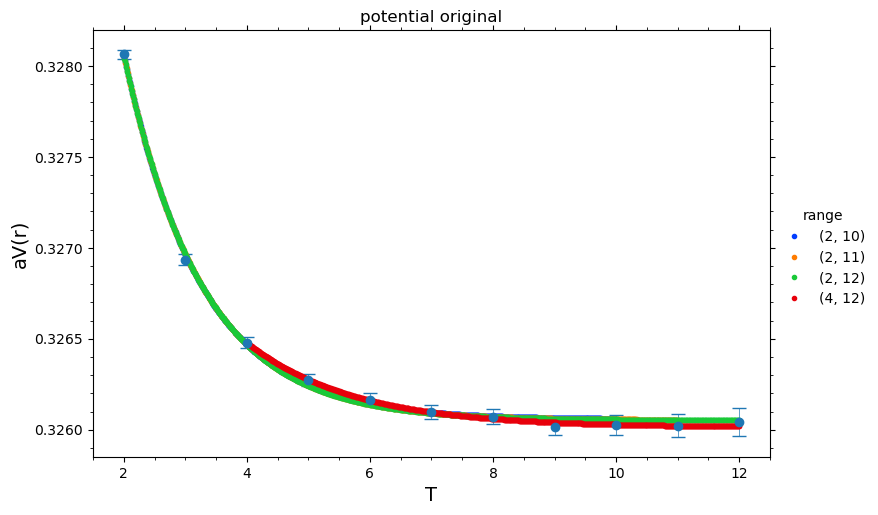

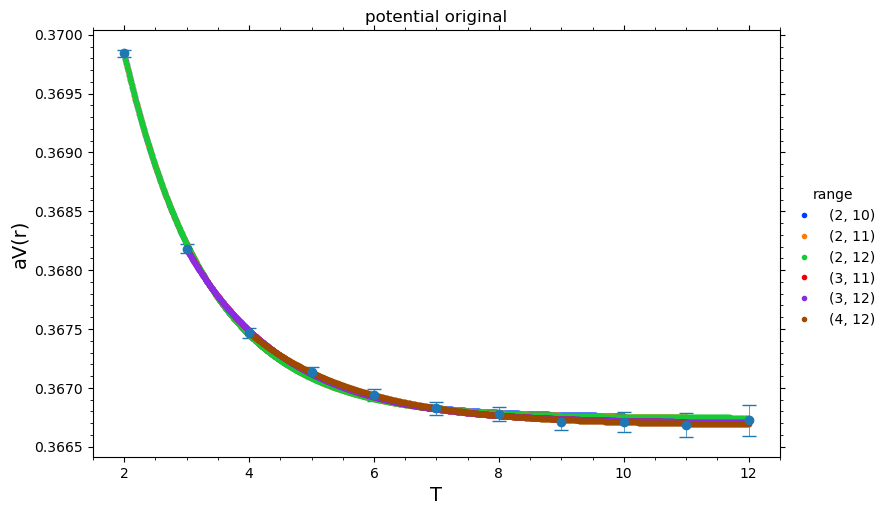

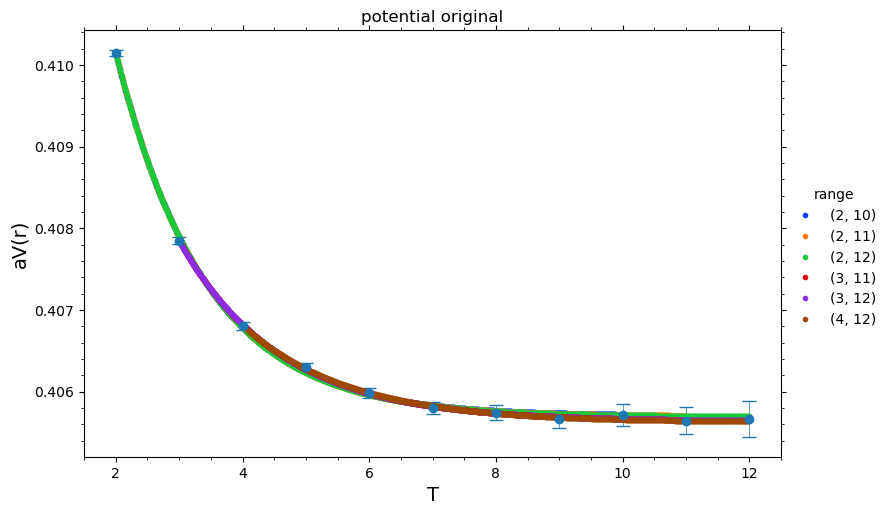

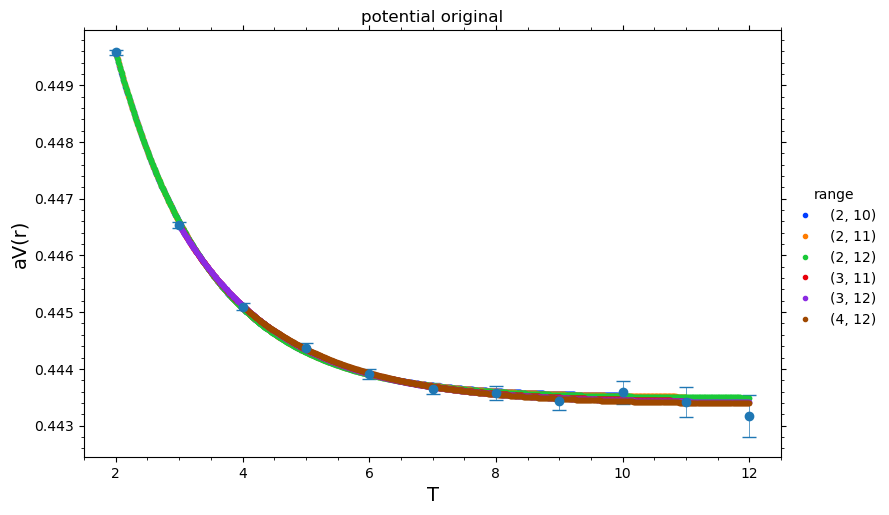

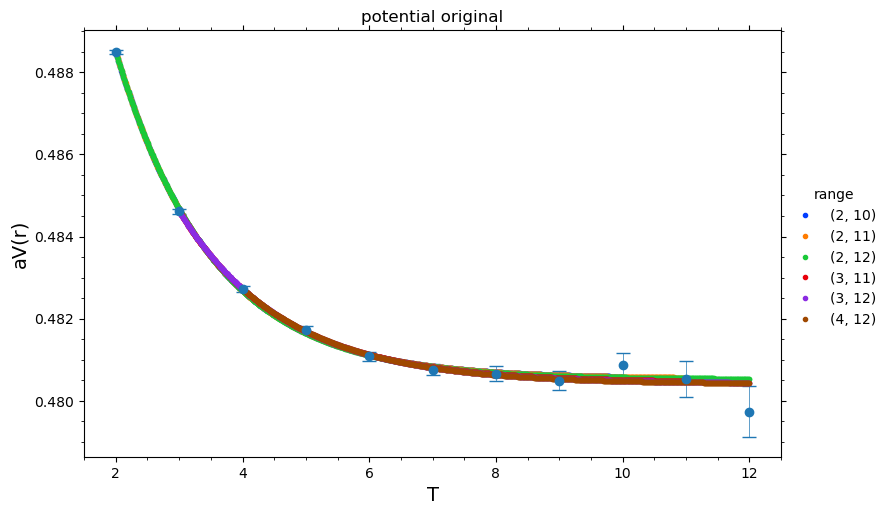

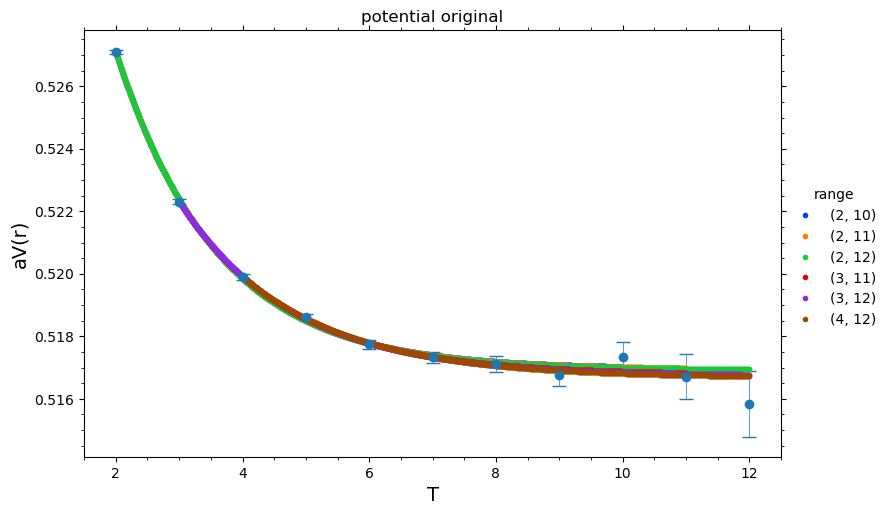

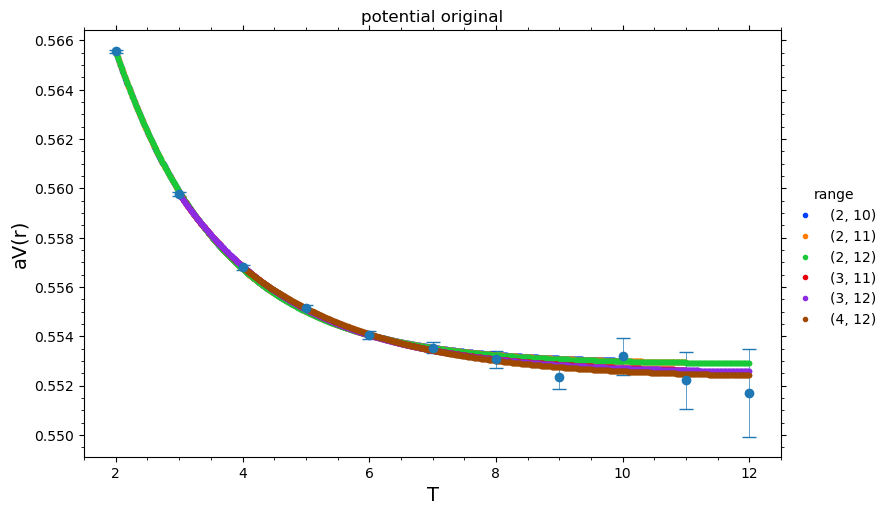

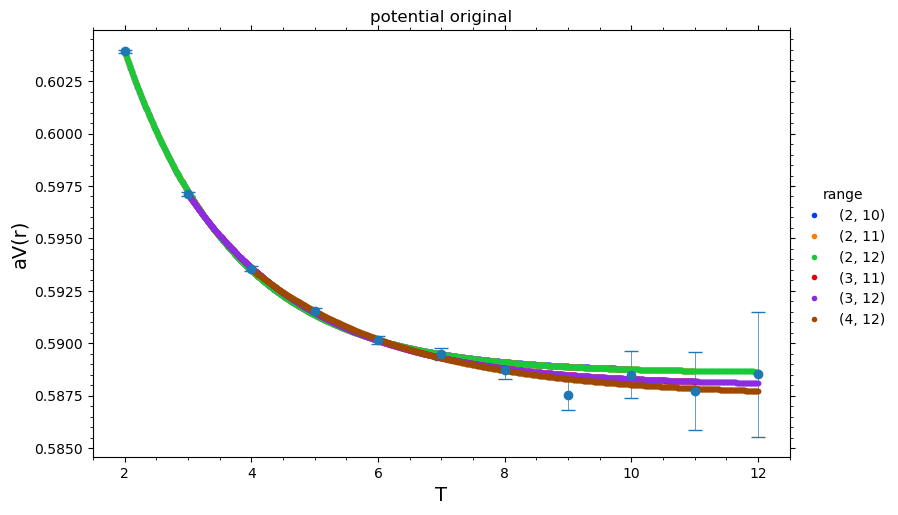

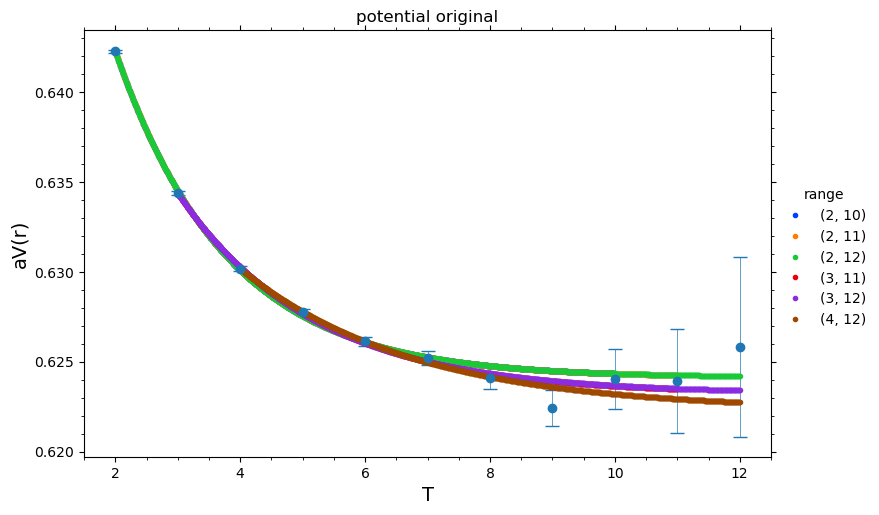

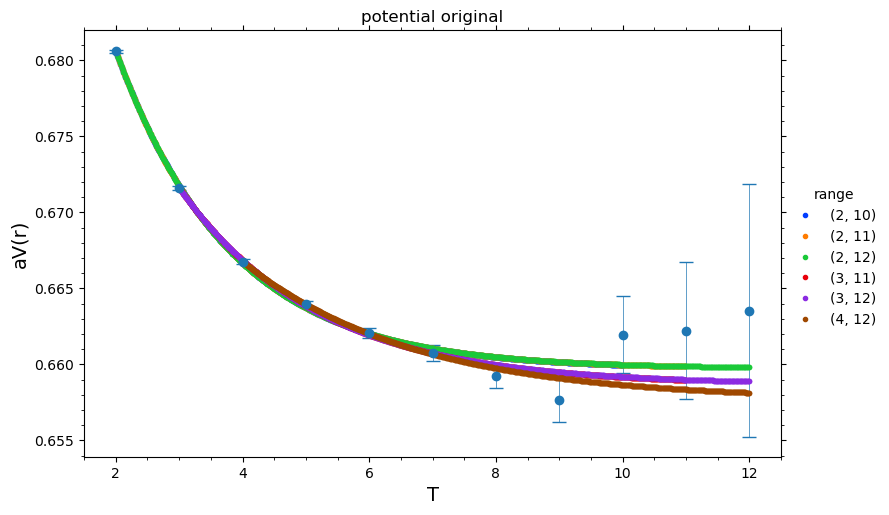

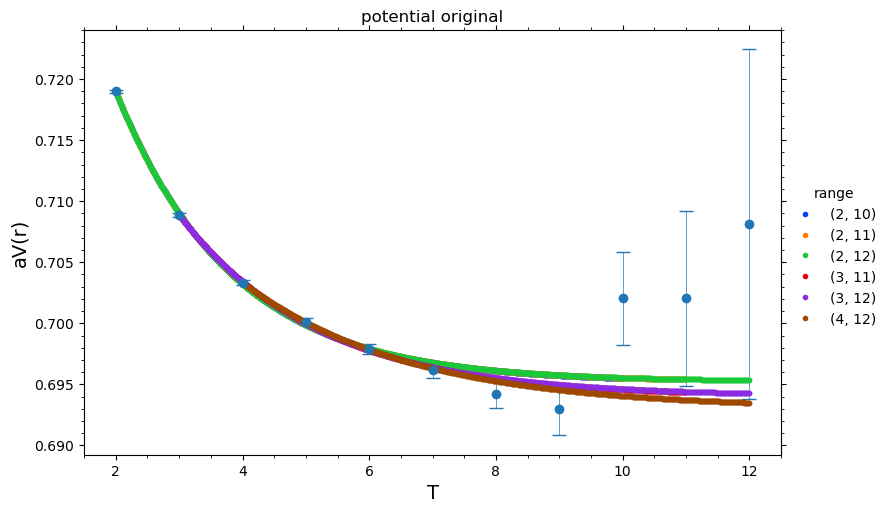

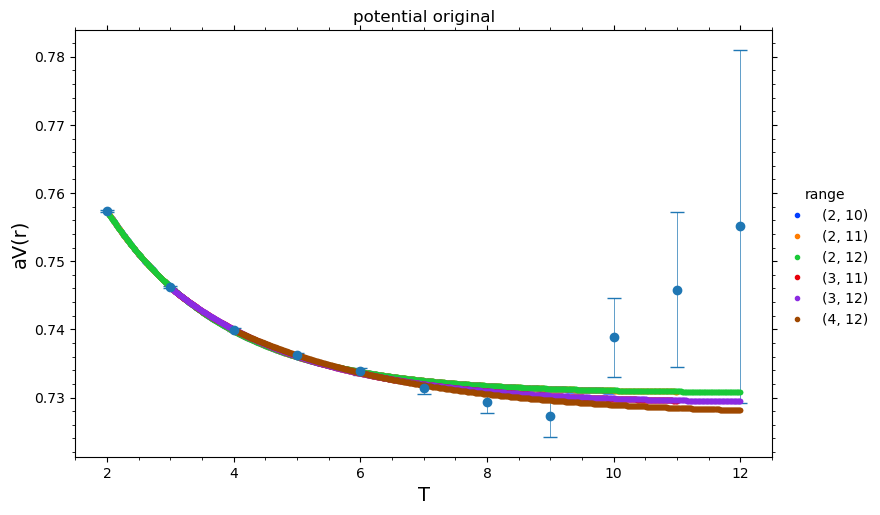

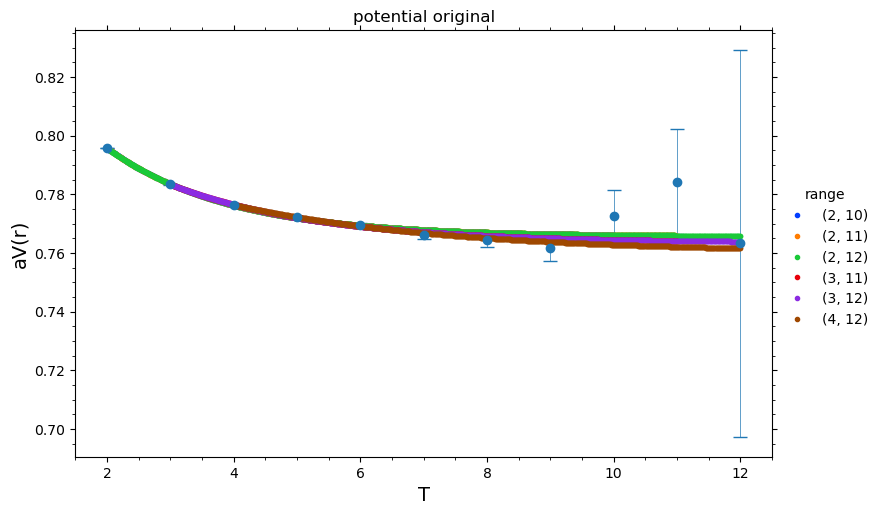

In [14]:
potential_gevp_T_fit('potential_gevp', '36^4', 'su3', 'gluodynamics', 36, 'beta6.1', '/', 'HYP1_alpha=1_1_0.5_APE_alpha=0.5', '', 'original', copy=None)

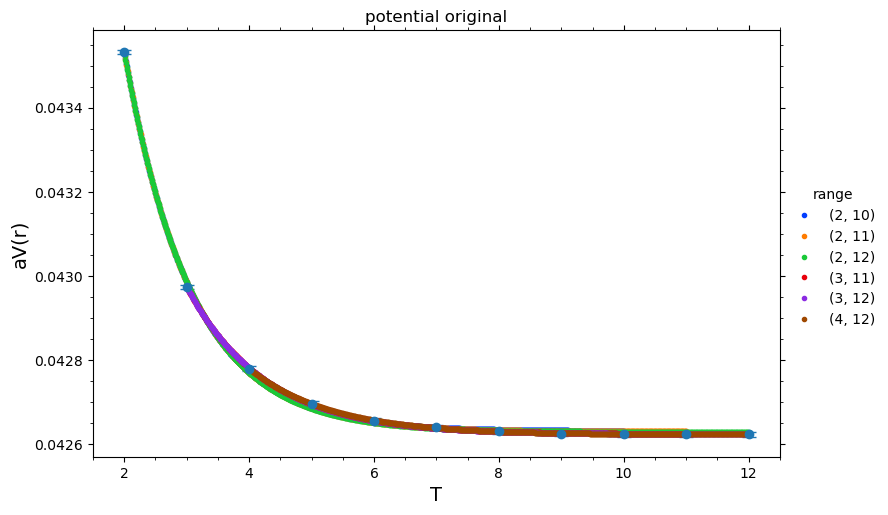

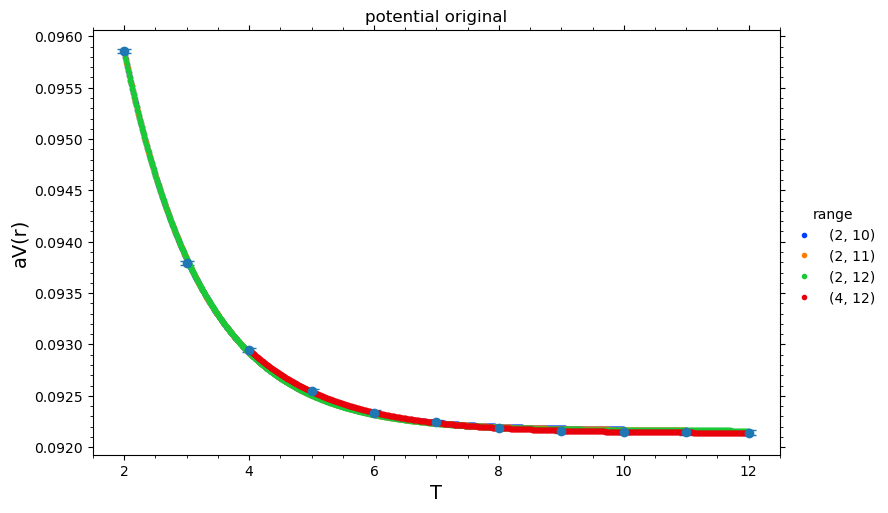

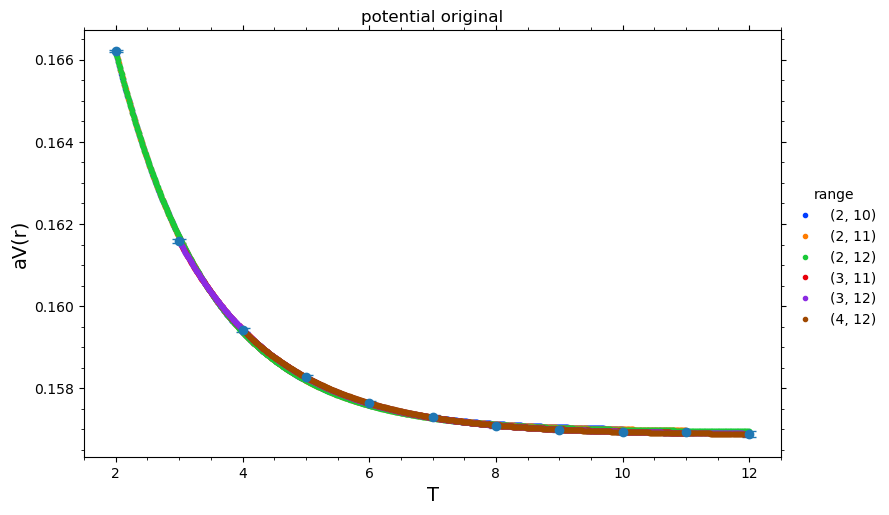

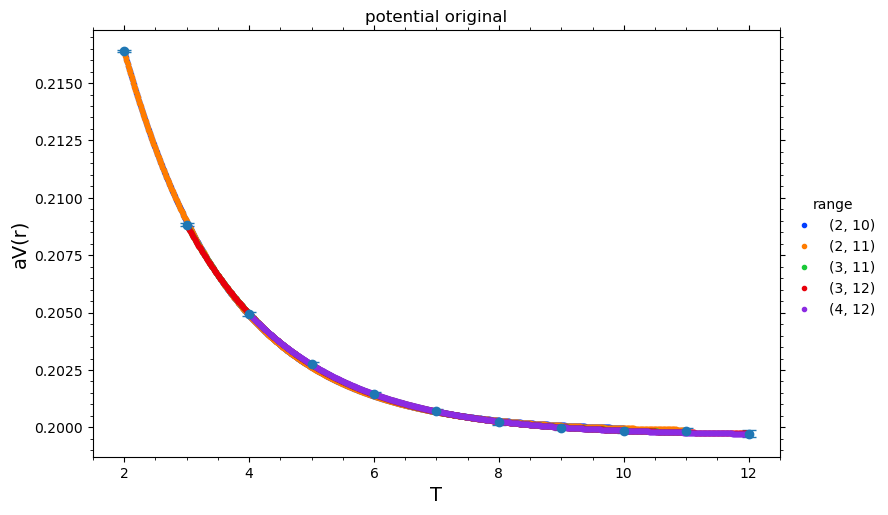

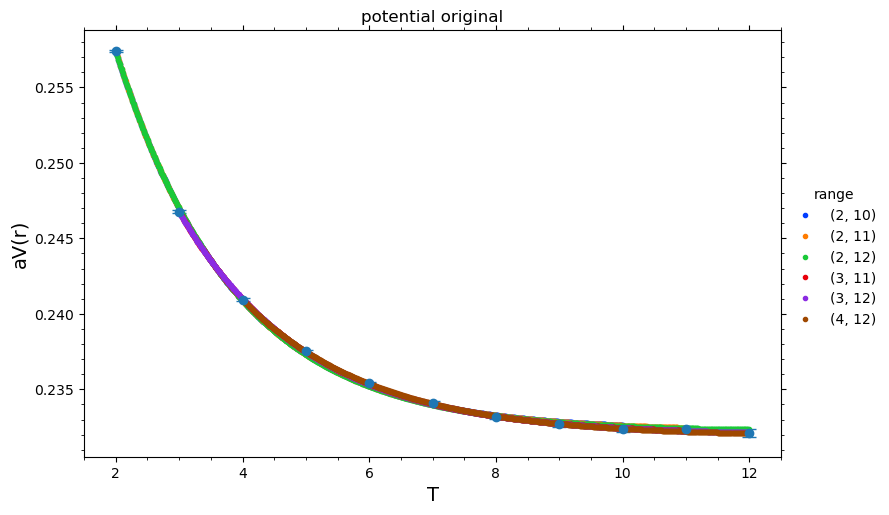

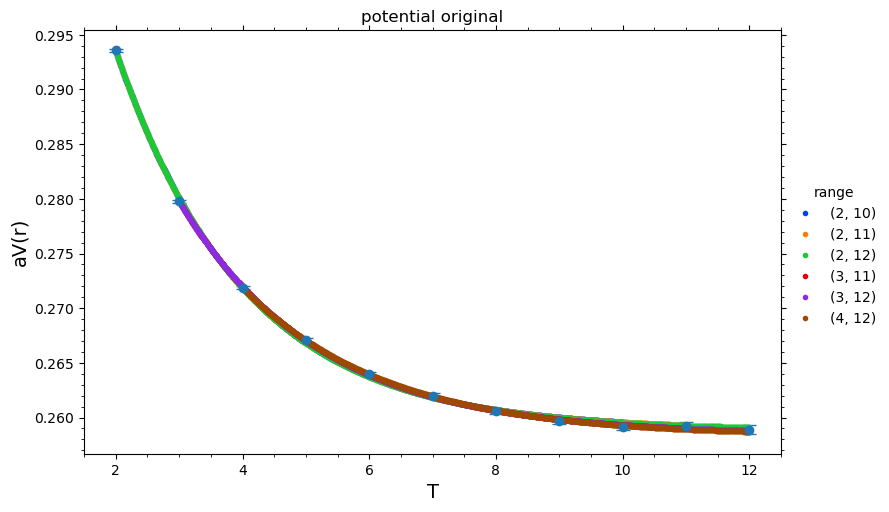

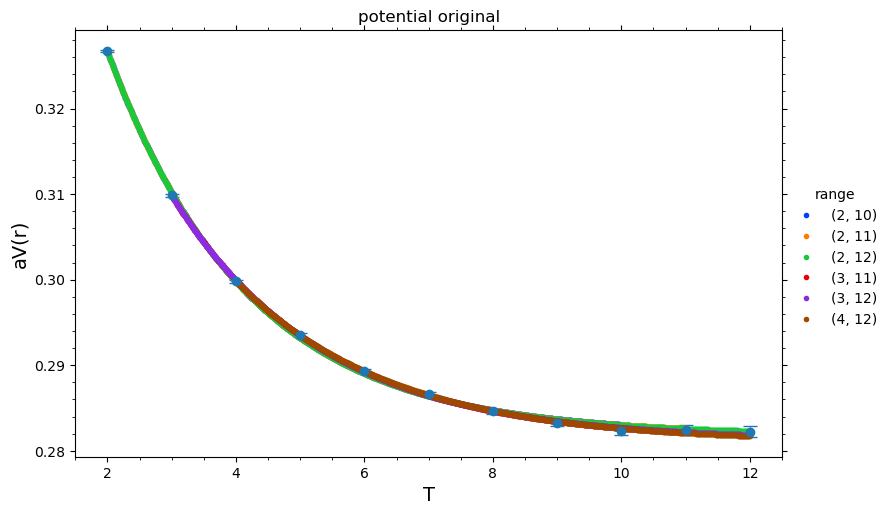

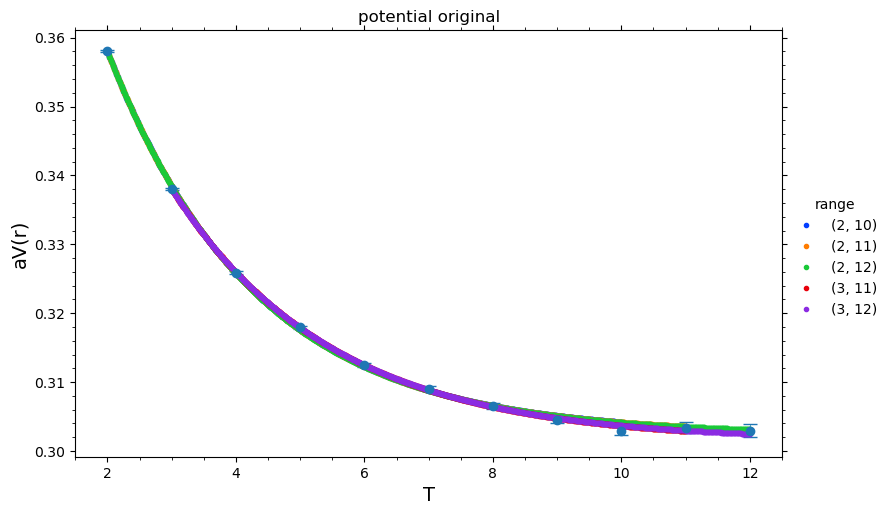

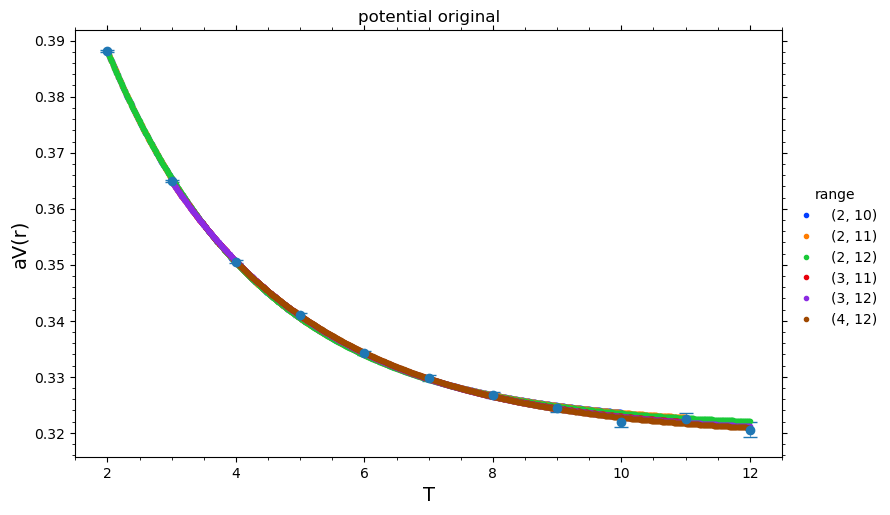

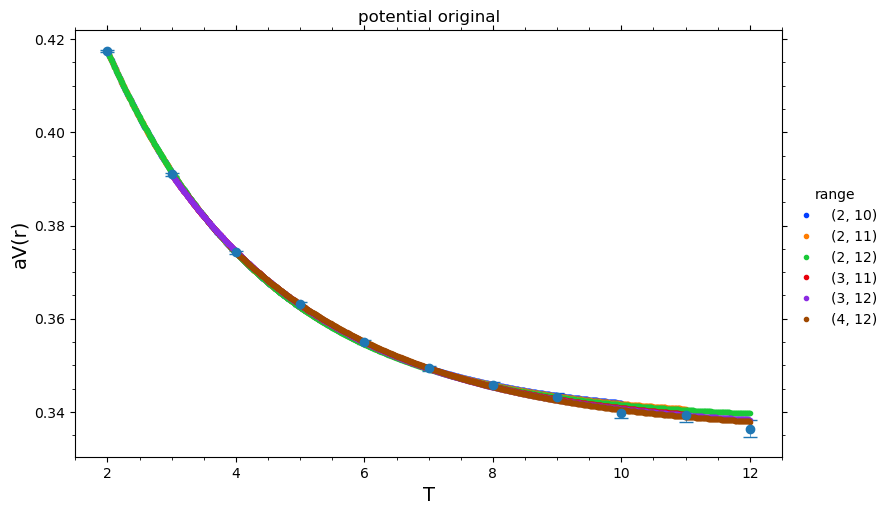

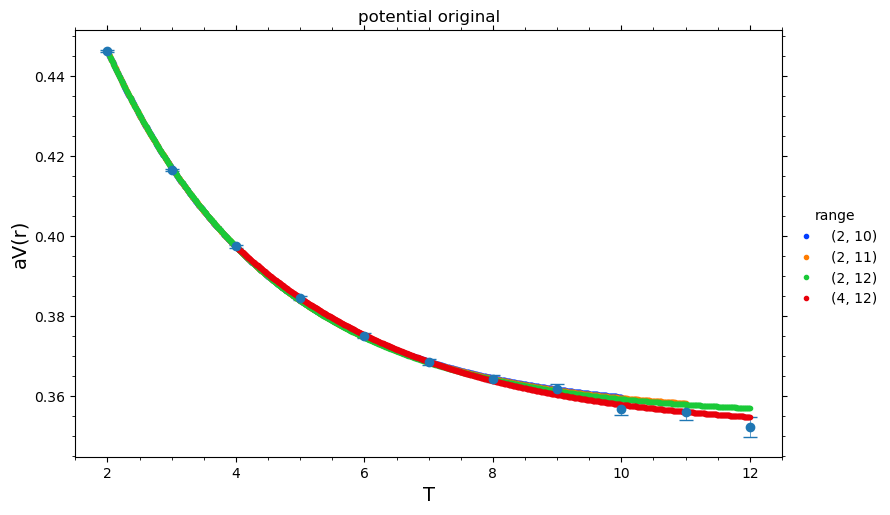

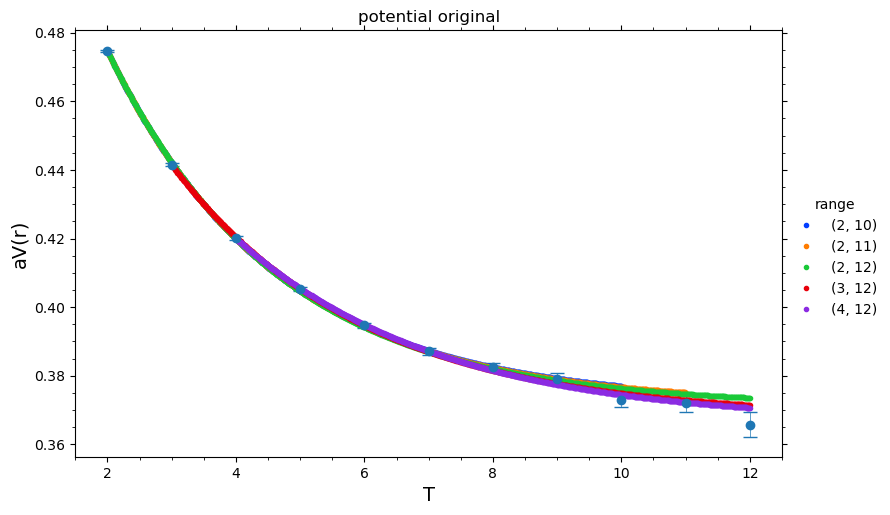

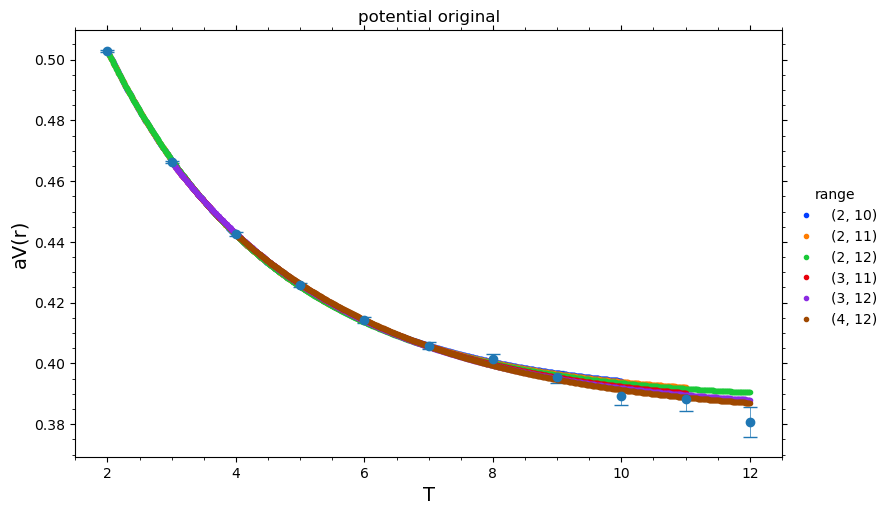

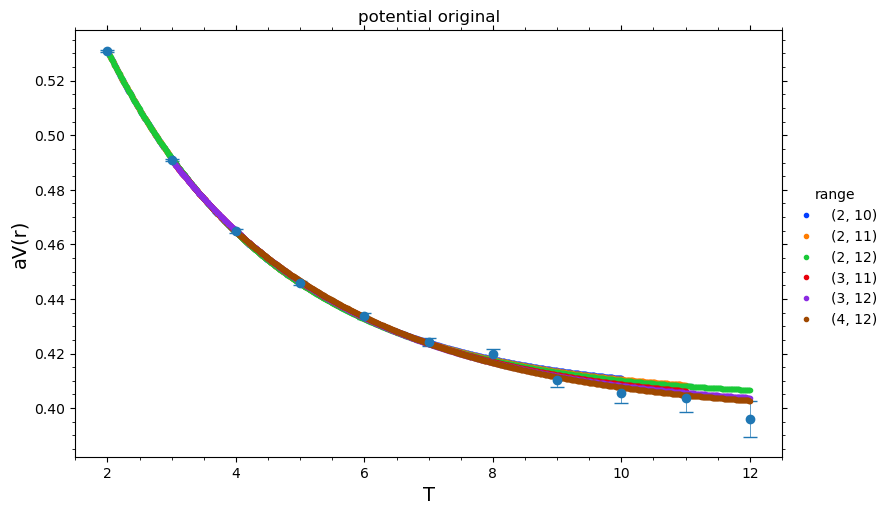

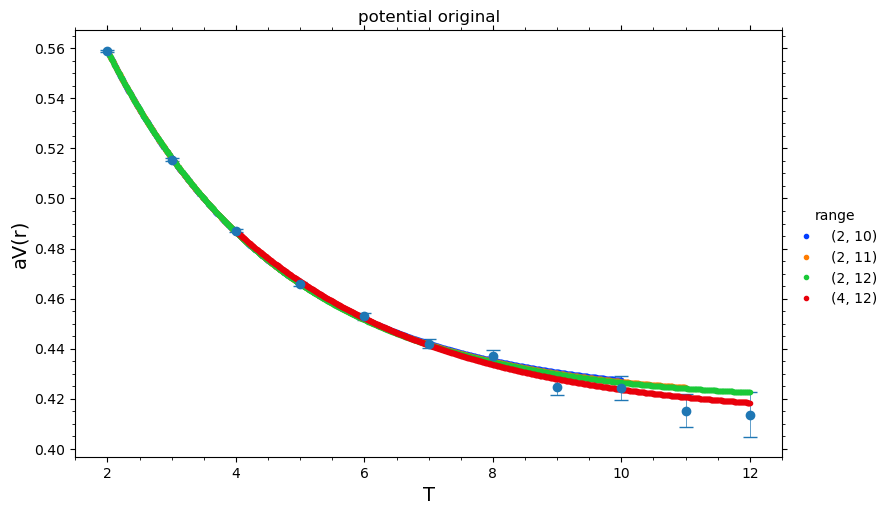

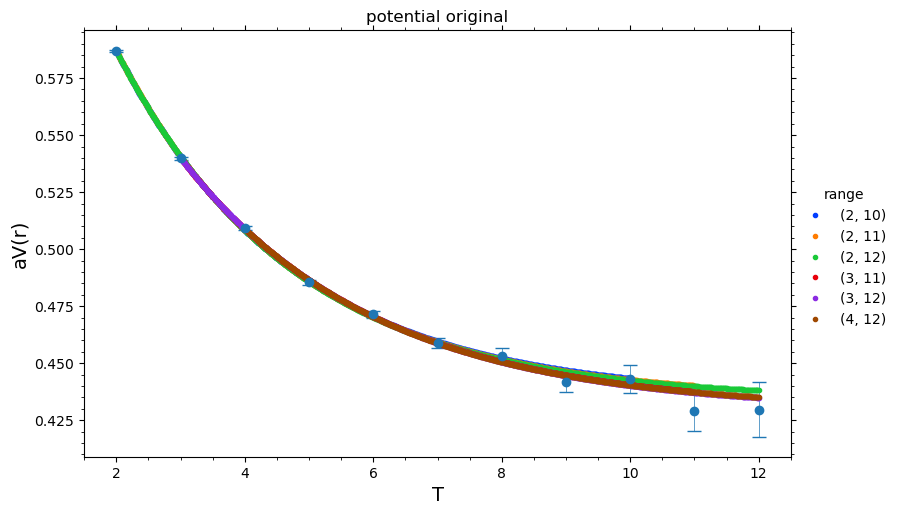

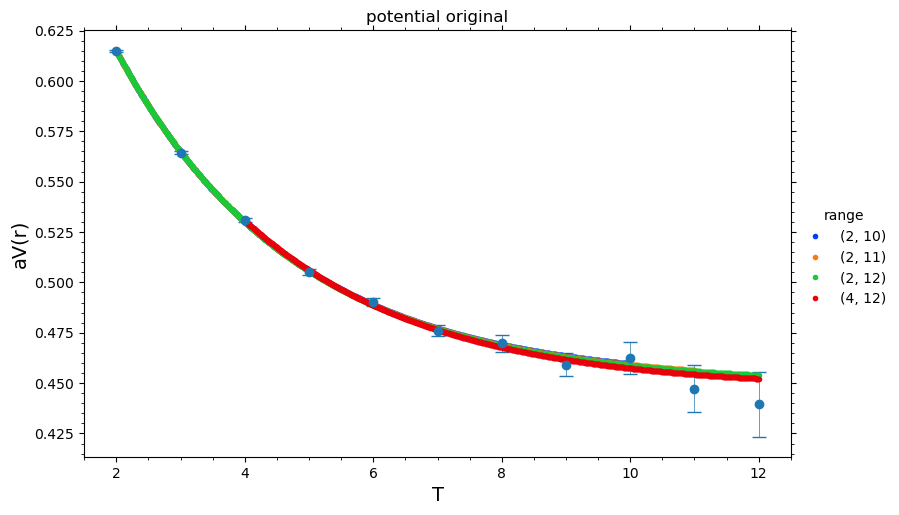

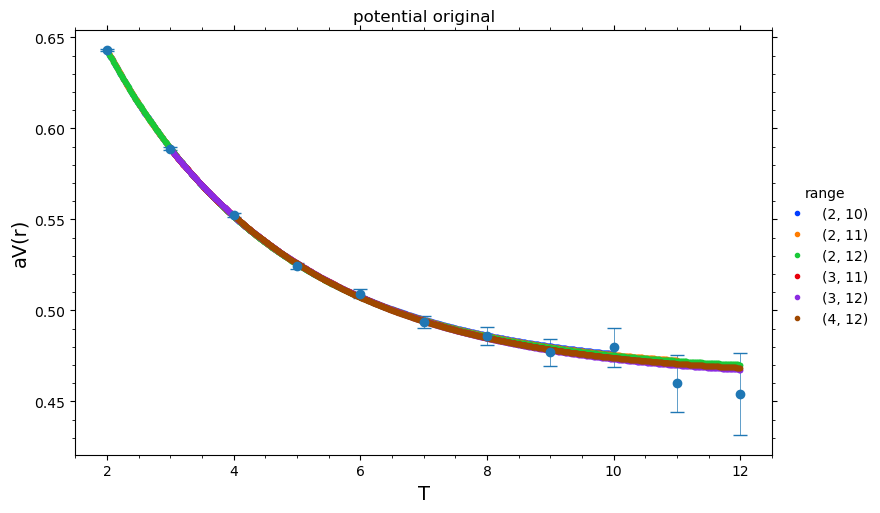

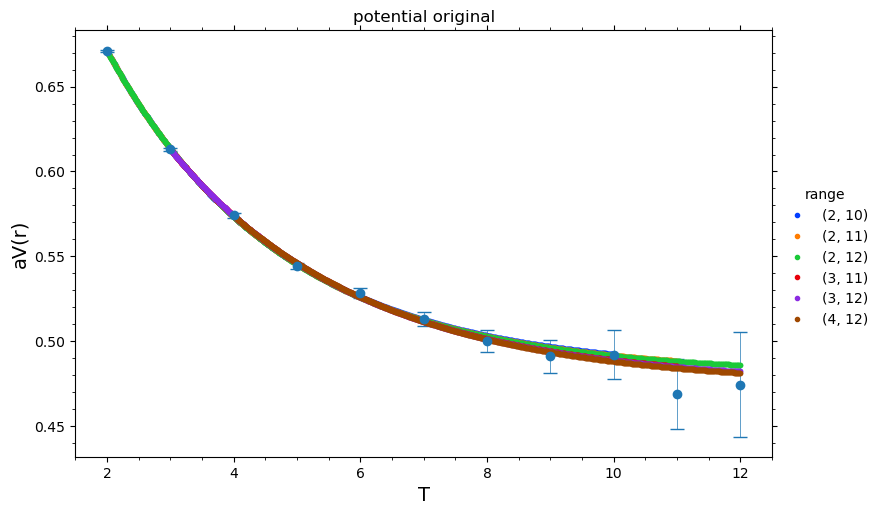

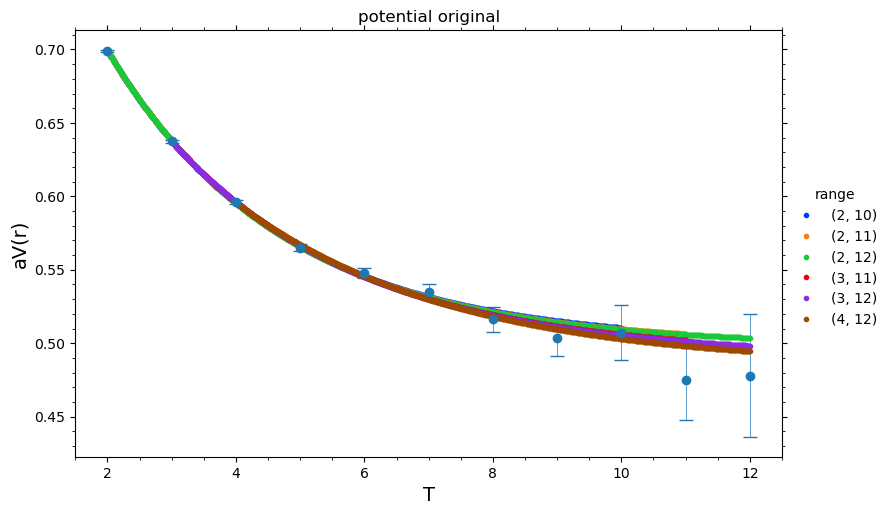

In [6]:
potential_gevp_T_fit('potential_gevp', '40^4', 'su2', 'qc2dstag', 40, '/', 'mu0.00', 'HYP1_alpha=1_1_0.5_APE_alpha=0.6', '', 'original', copy=None)

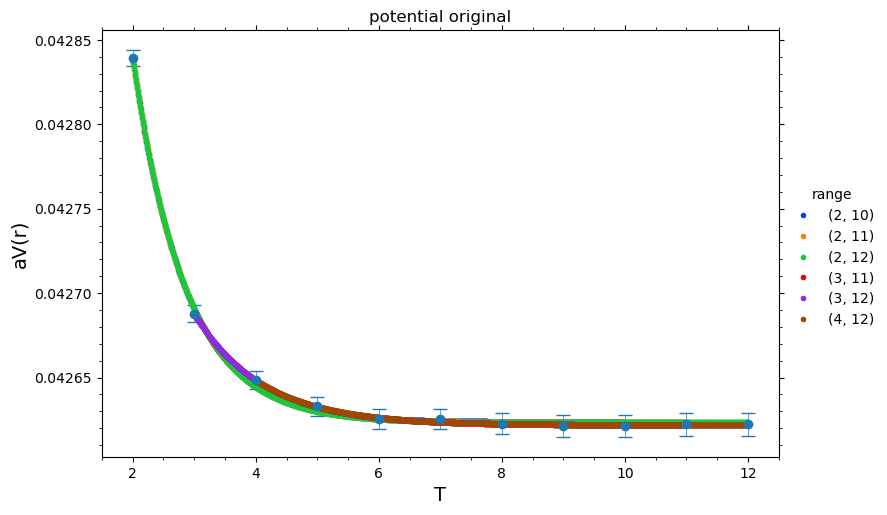

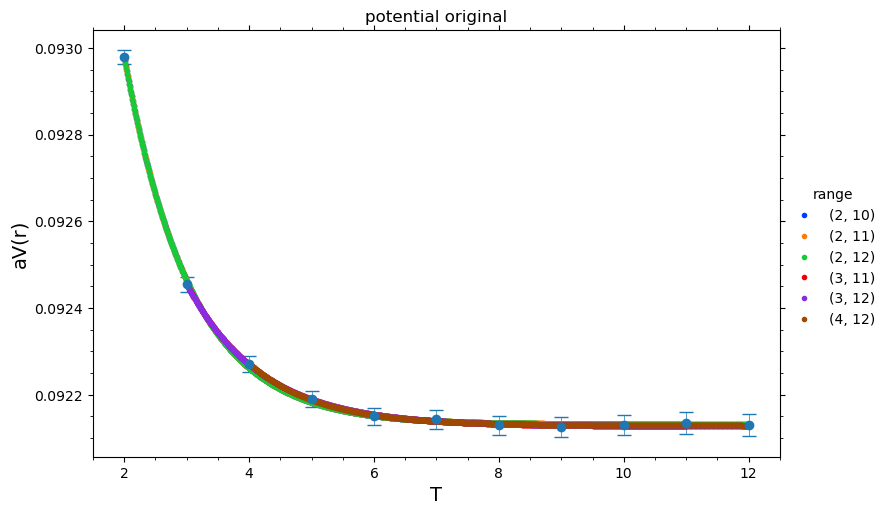

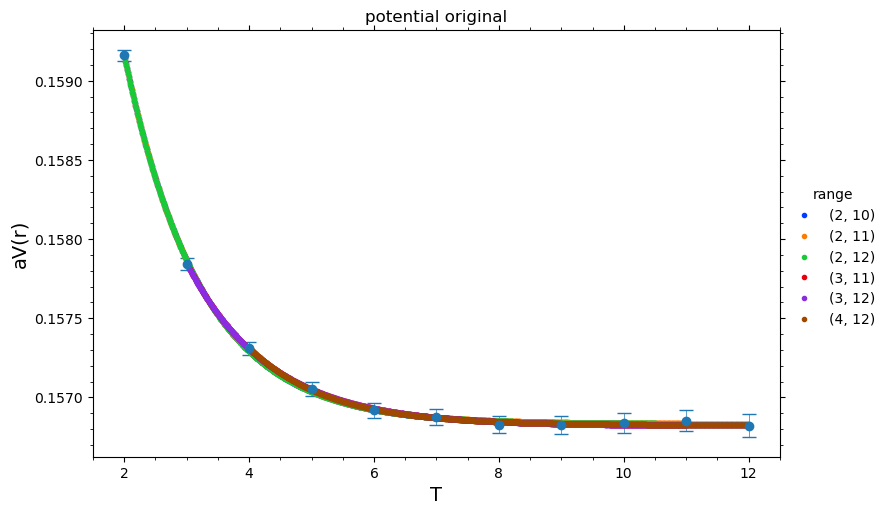

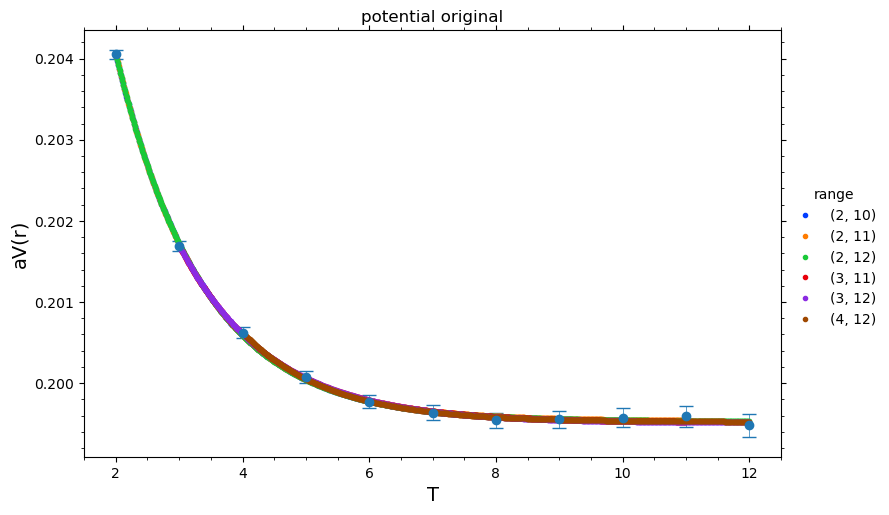

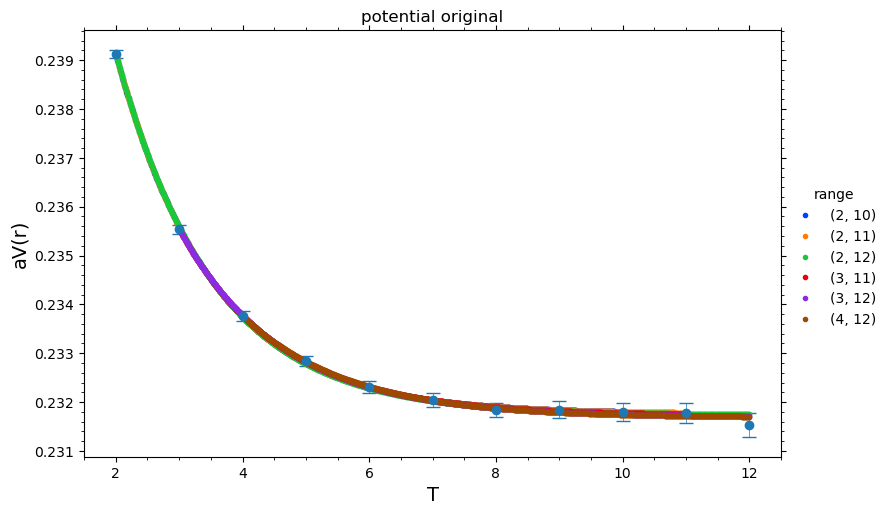

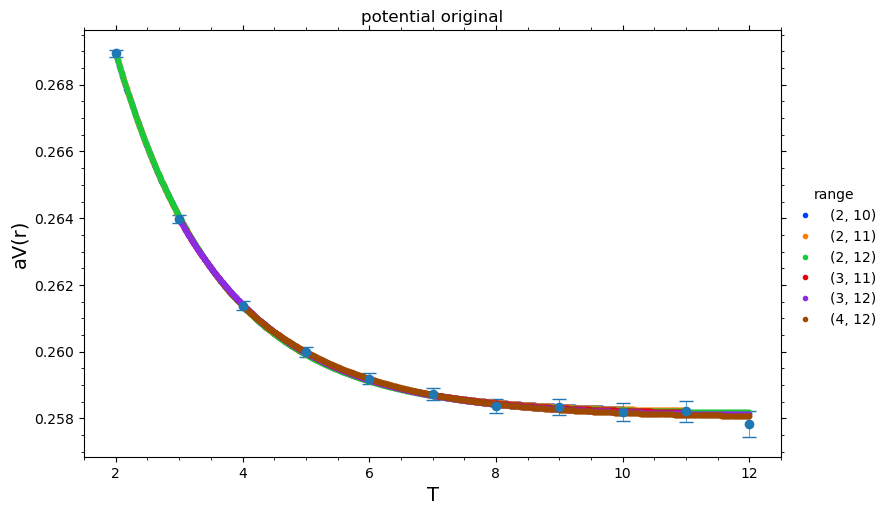

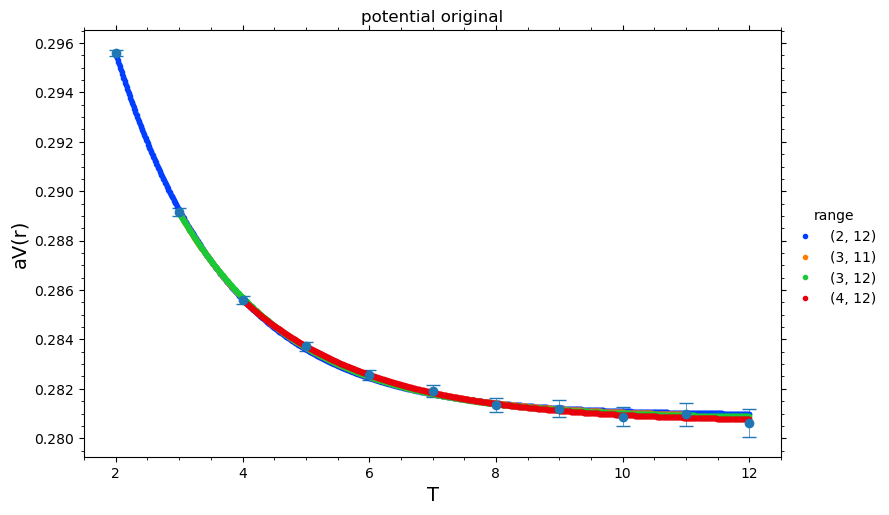

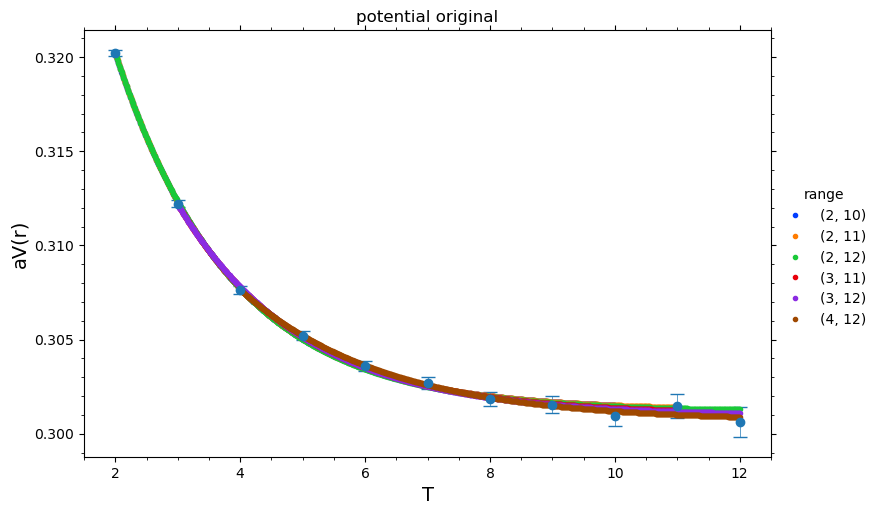

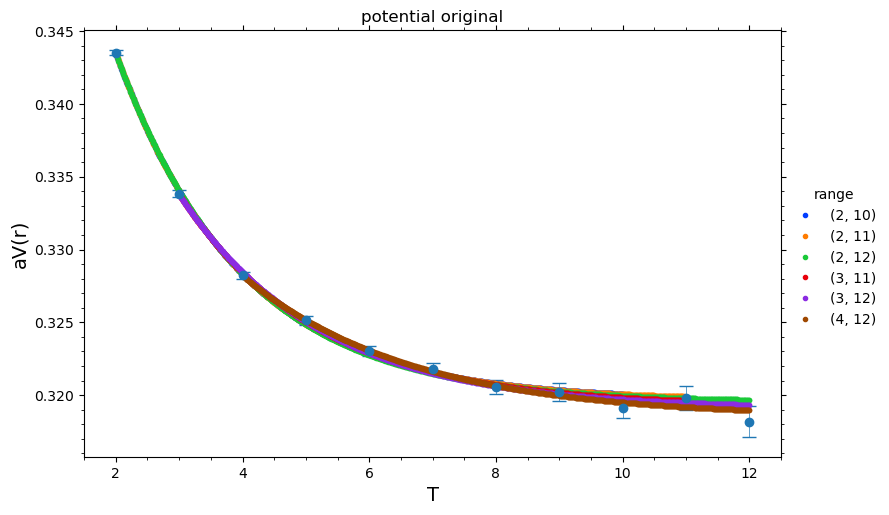

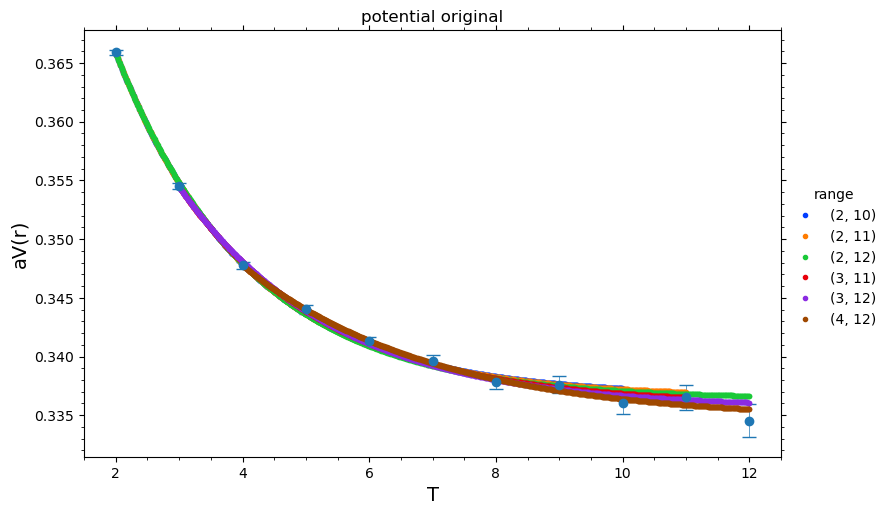

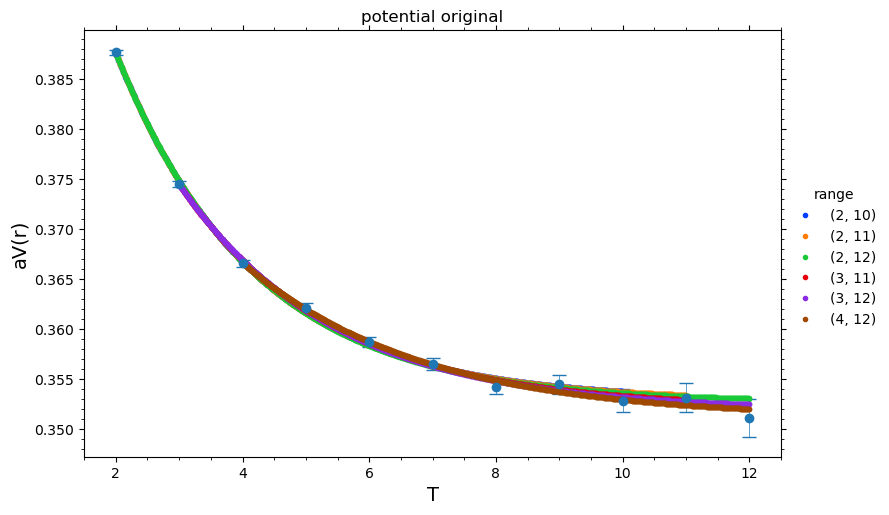

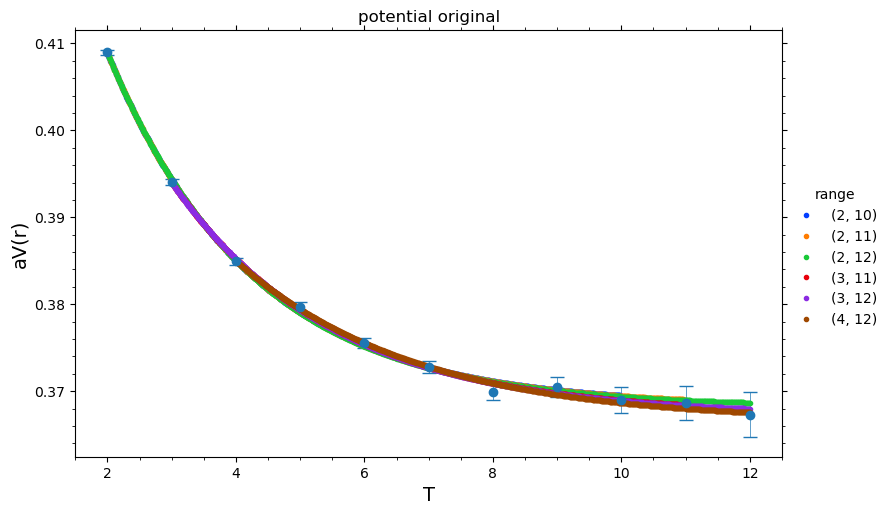

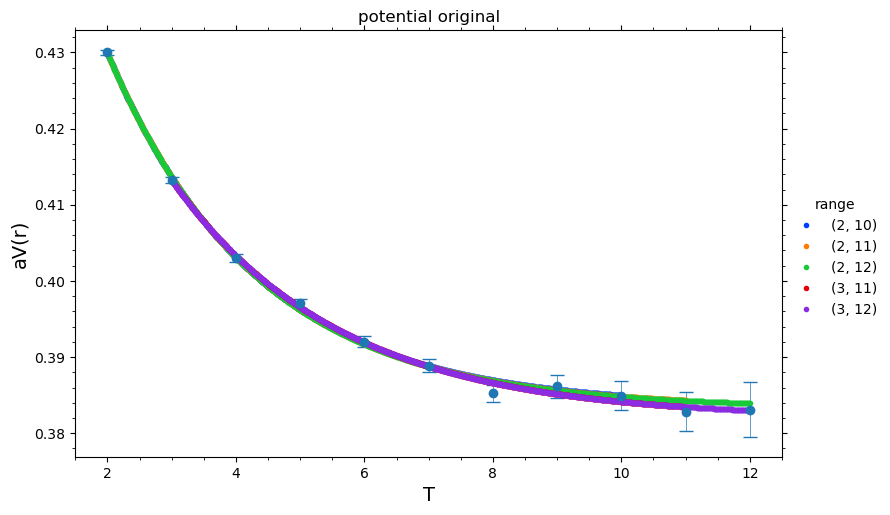

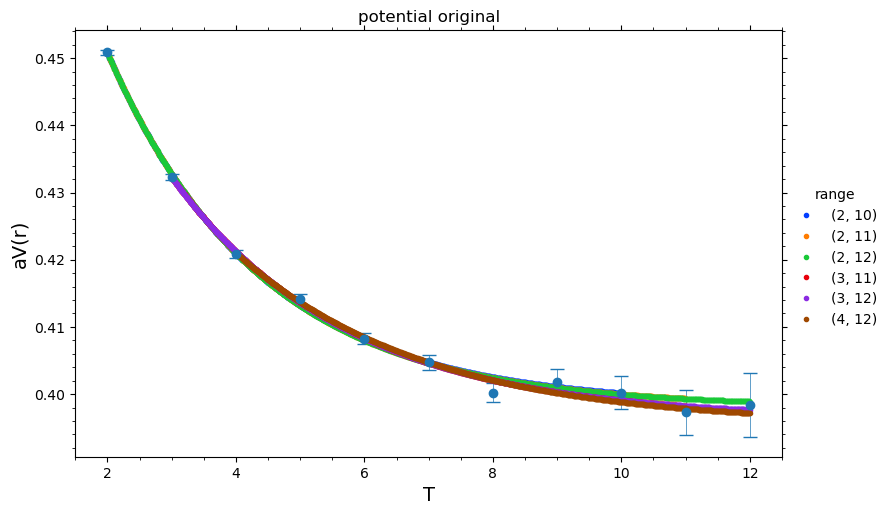

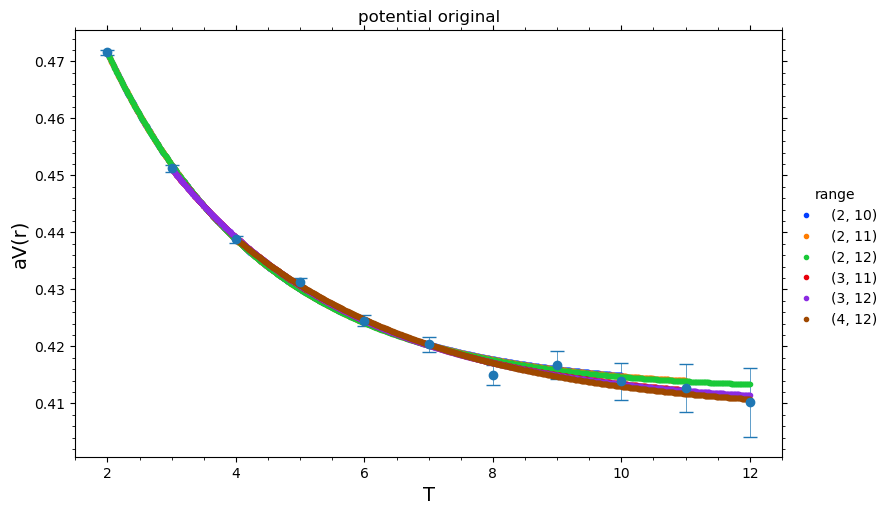

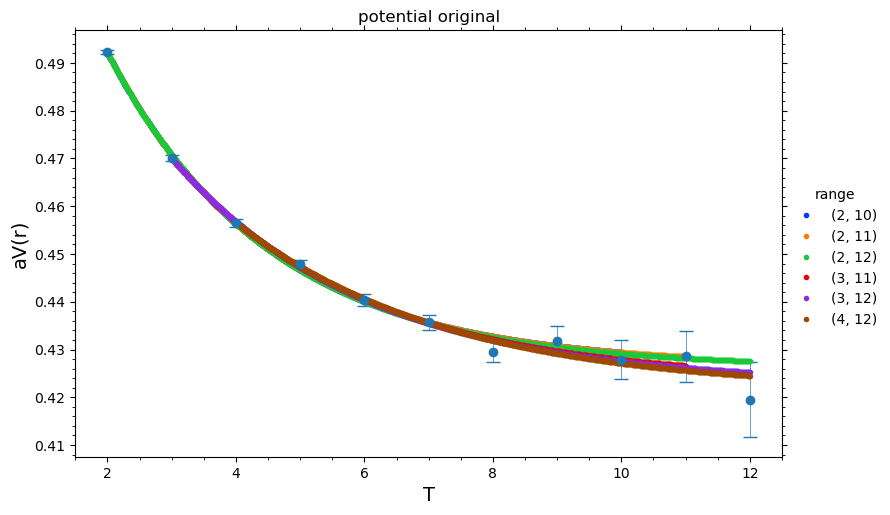

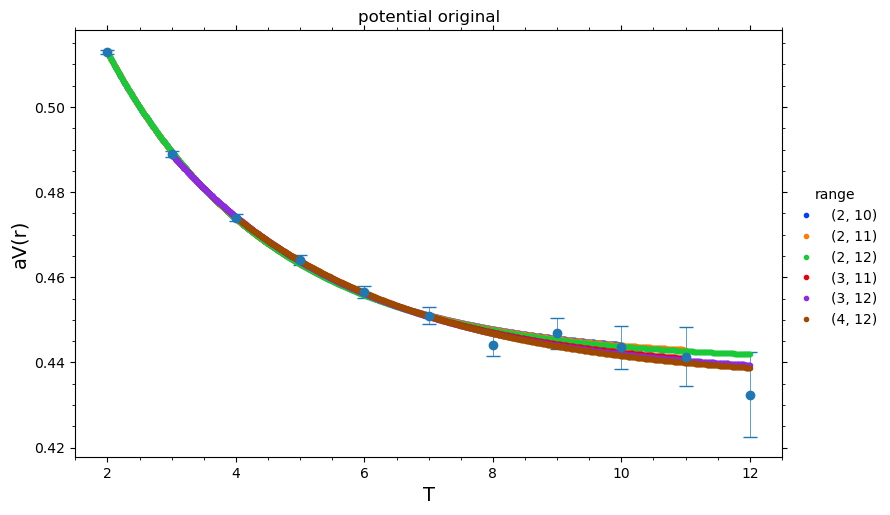

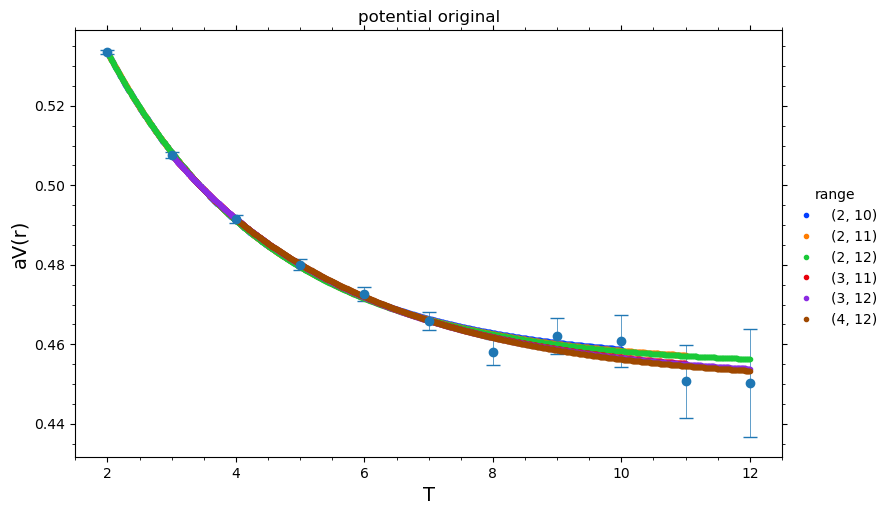

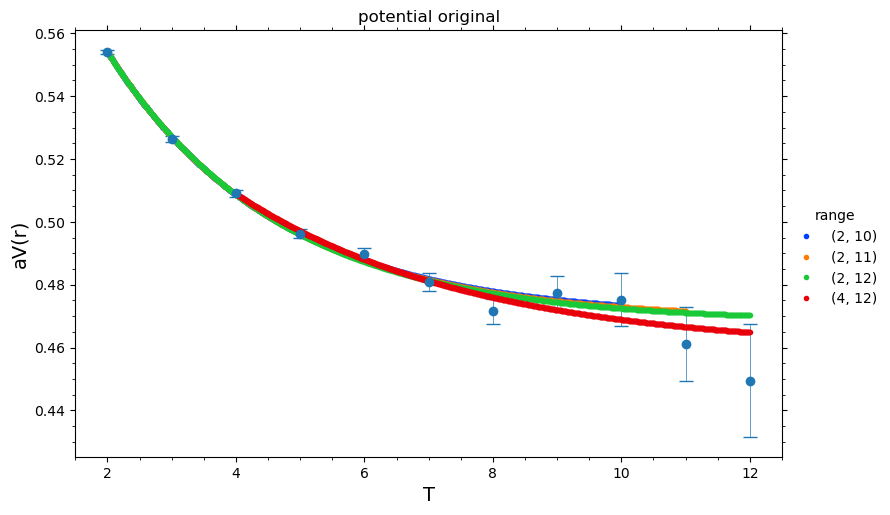

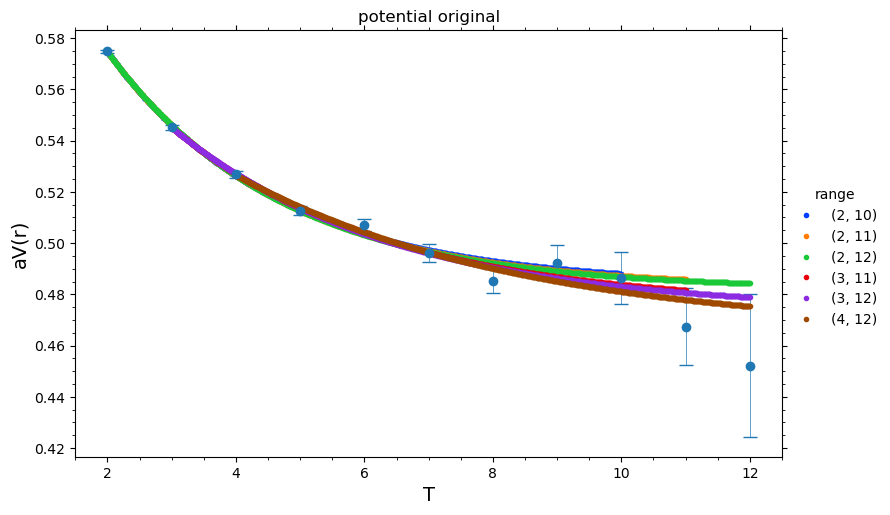

In [5]:
potential_gevp_T_fit('potential_gevp', '40^4', 'su2', 'qc2dstag', 40, '/', 'mu0.00', 'HYP1_alpha=1_1_0.5_APE_alpha=0.5', '', 'original', copy=None)

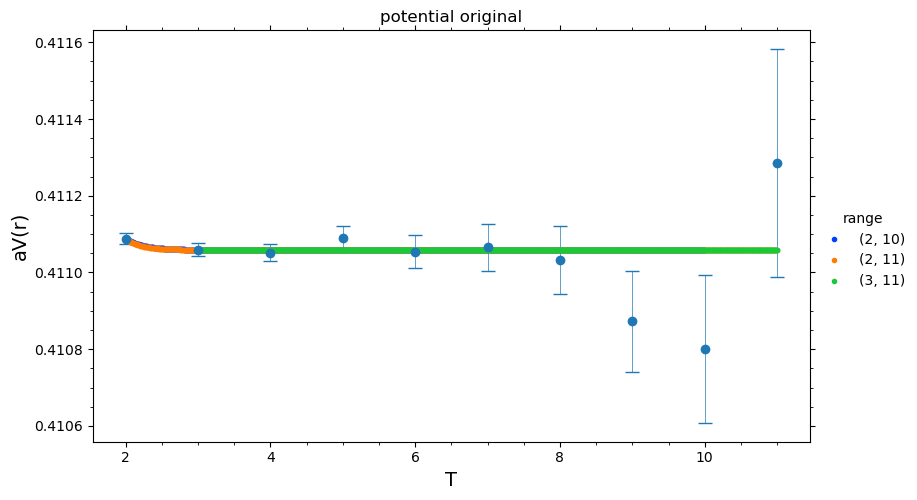

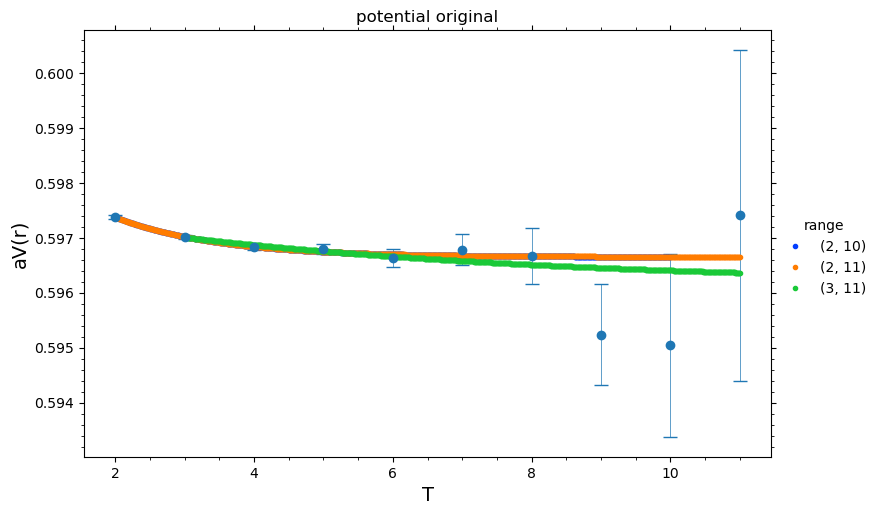

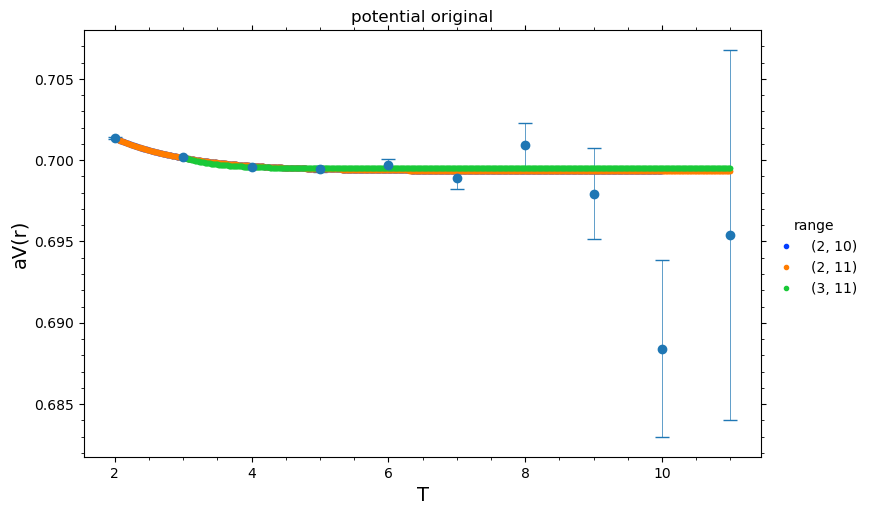

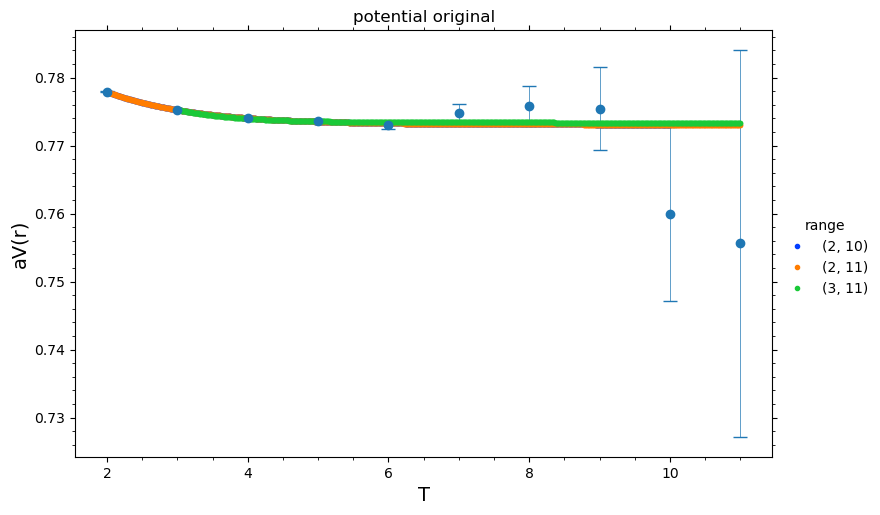

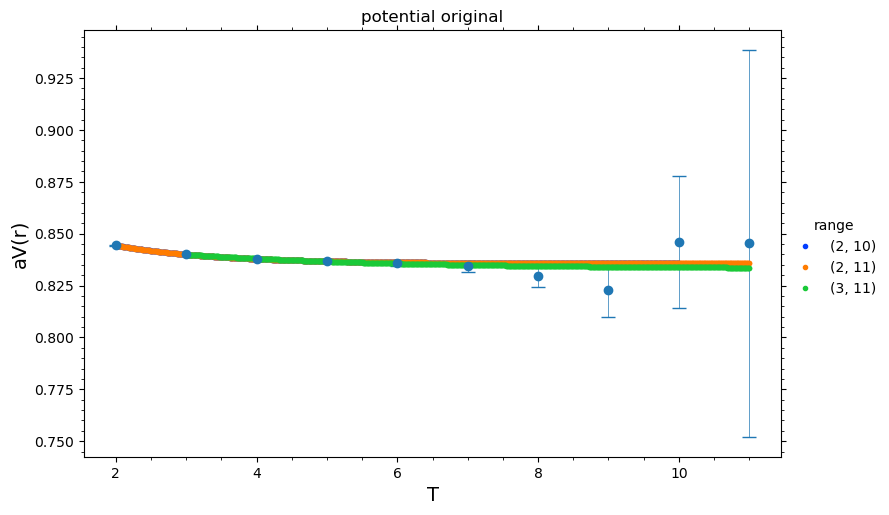

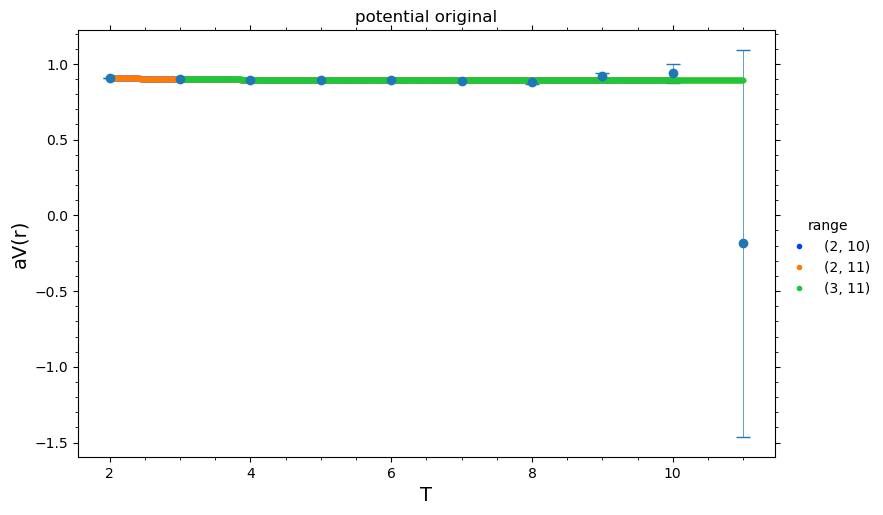

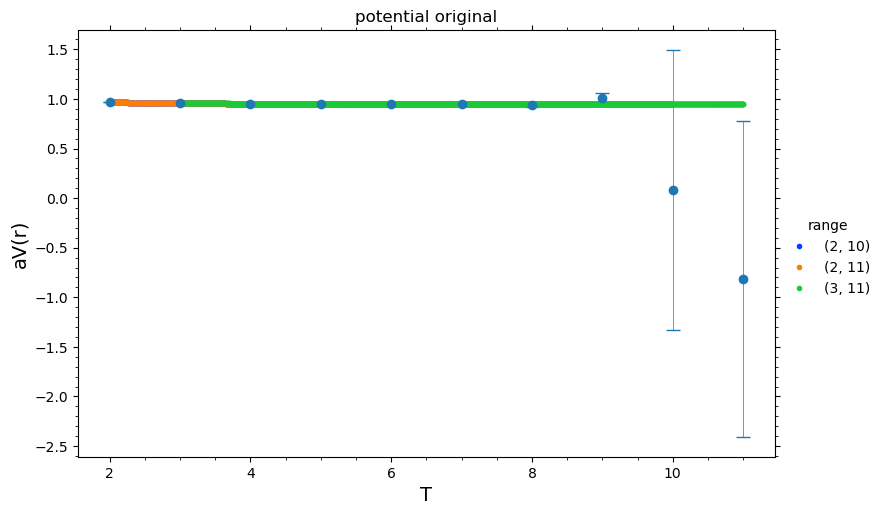

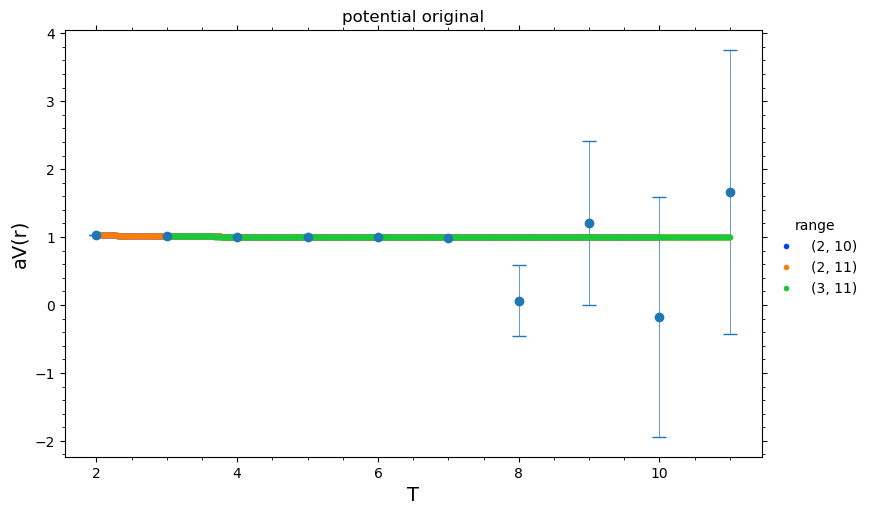

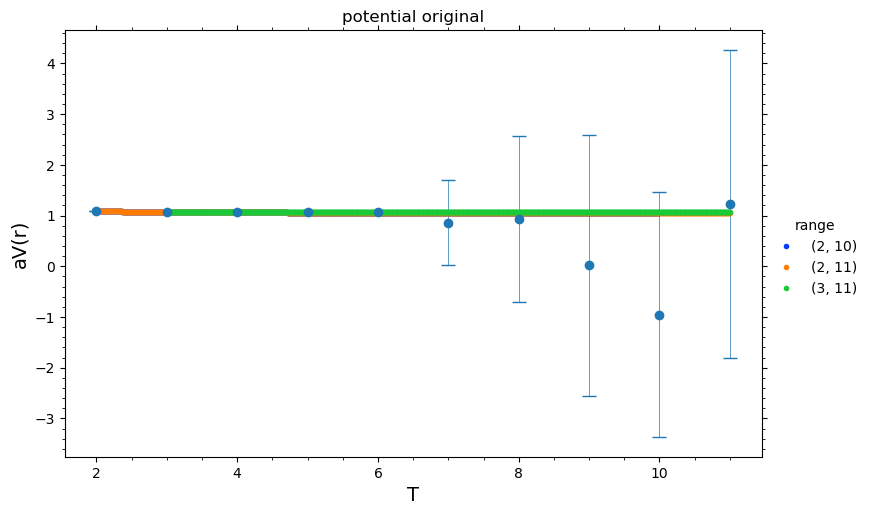

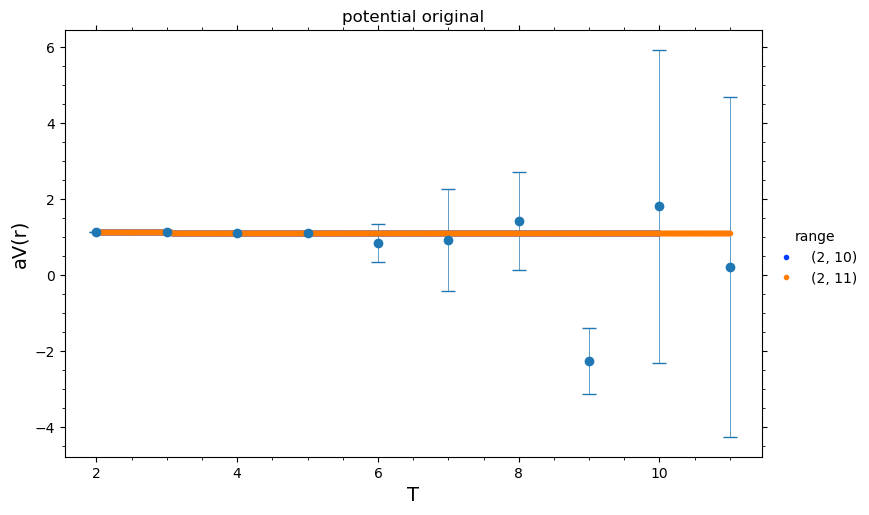

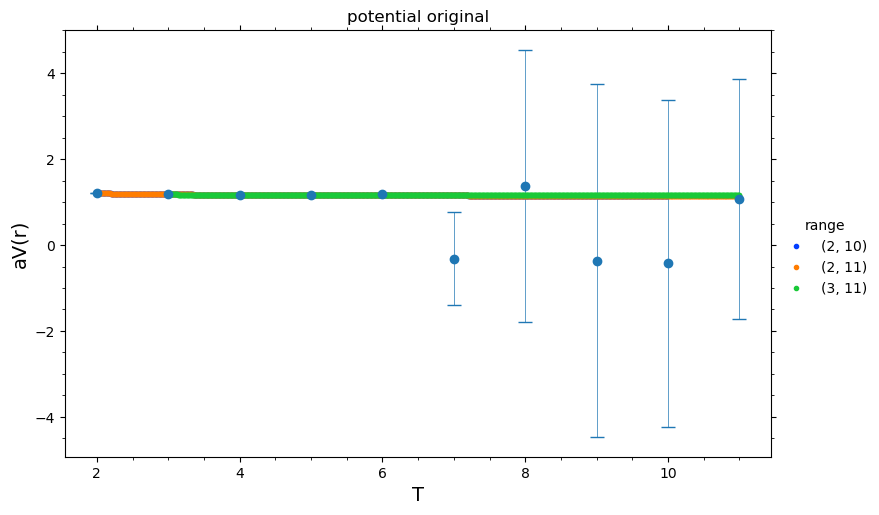

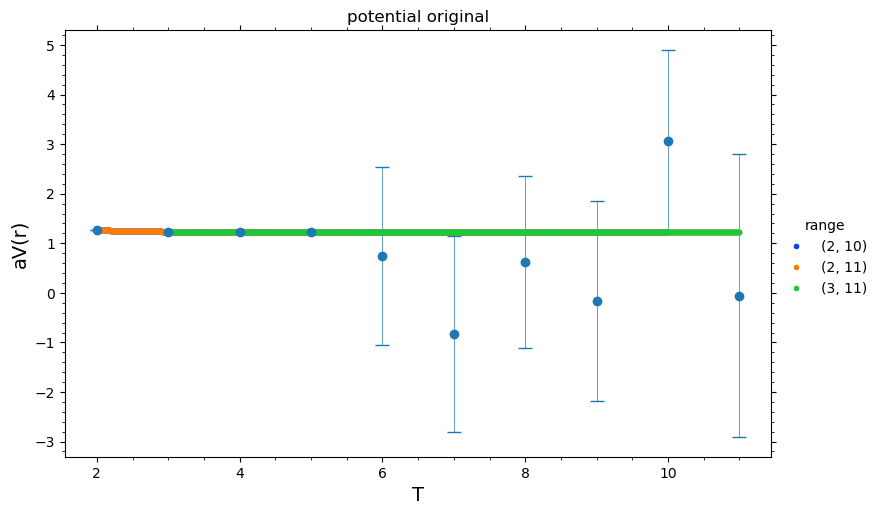

In [5]:
potential_gevp_T_fit('potential_gevp', '24^4', 'su3', 'gluodynamics', 24, 'beta6.0', '', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', '', 'original', copy=None)

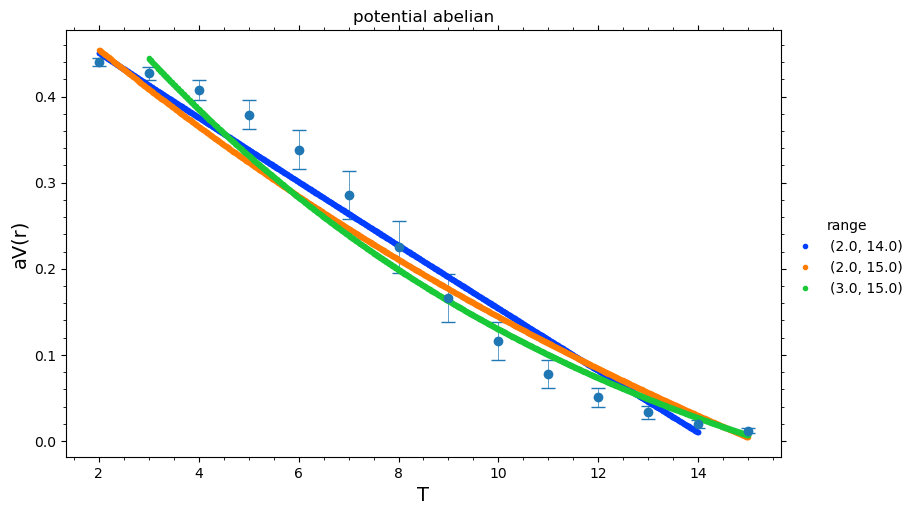

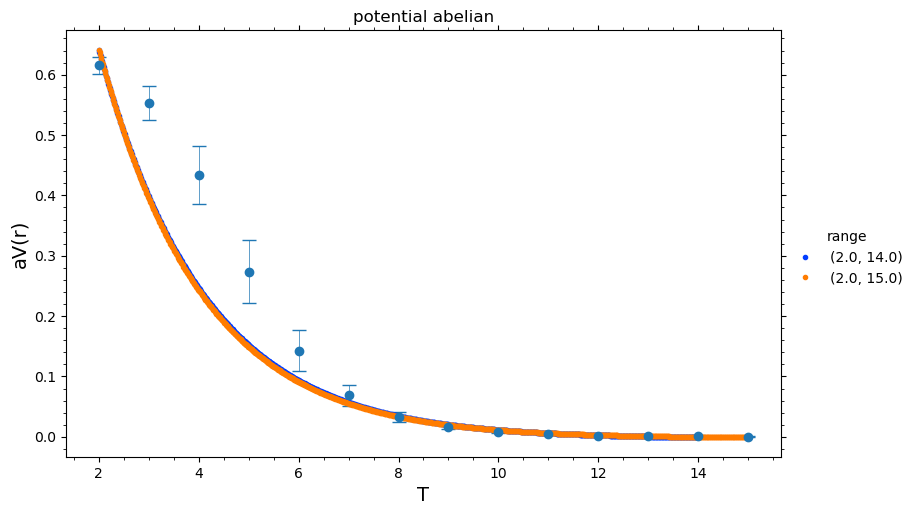

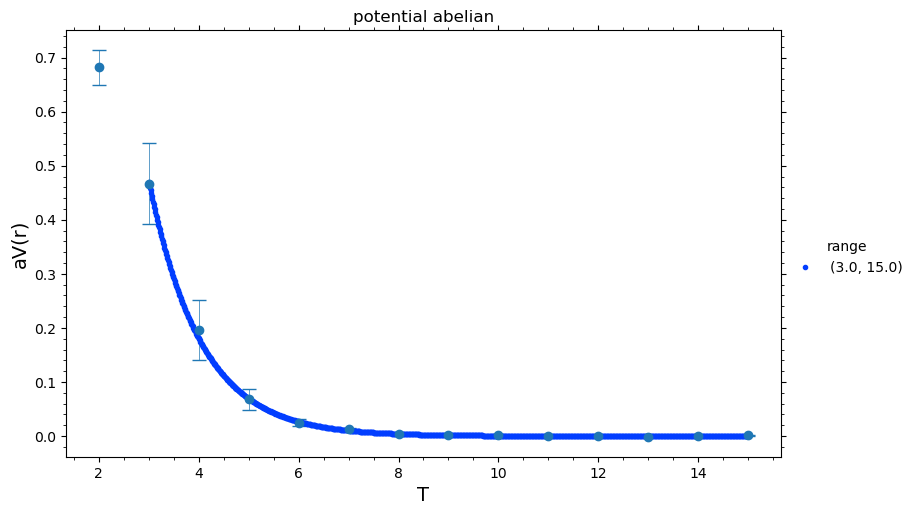

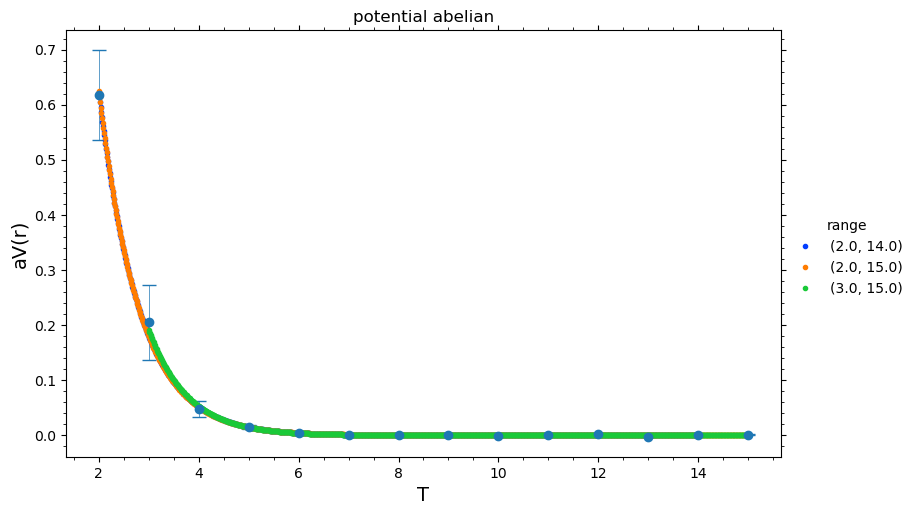

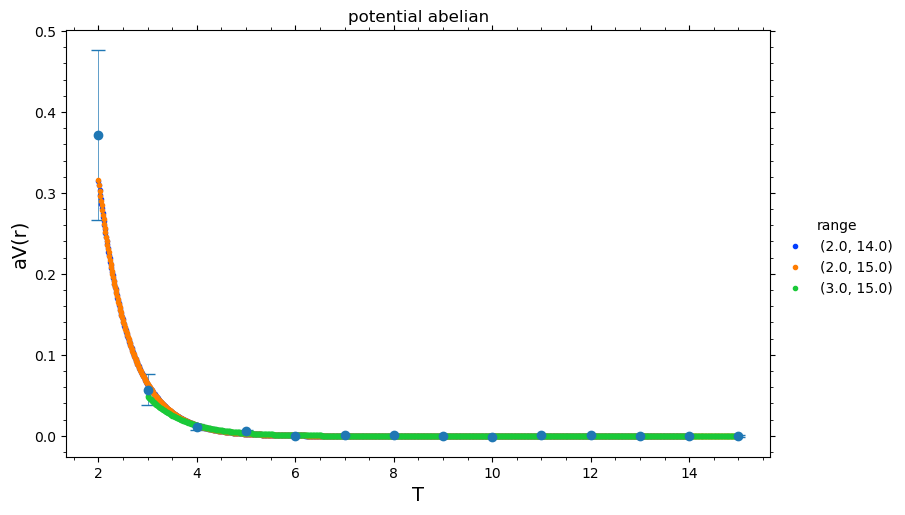

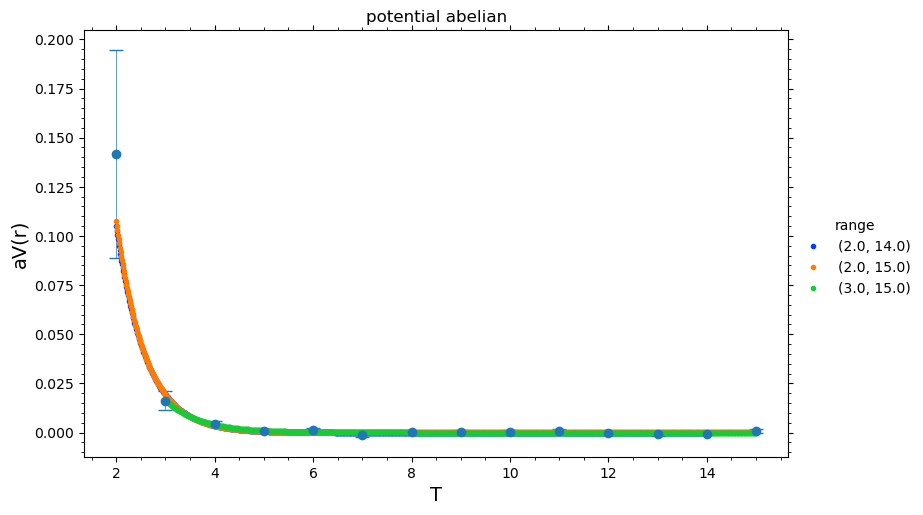

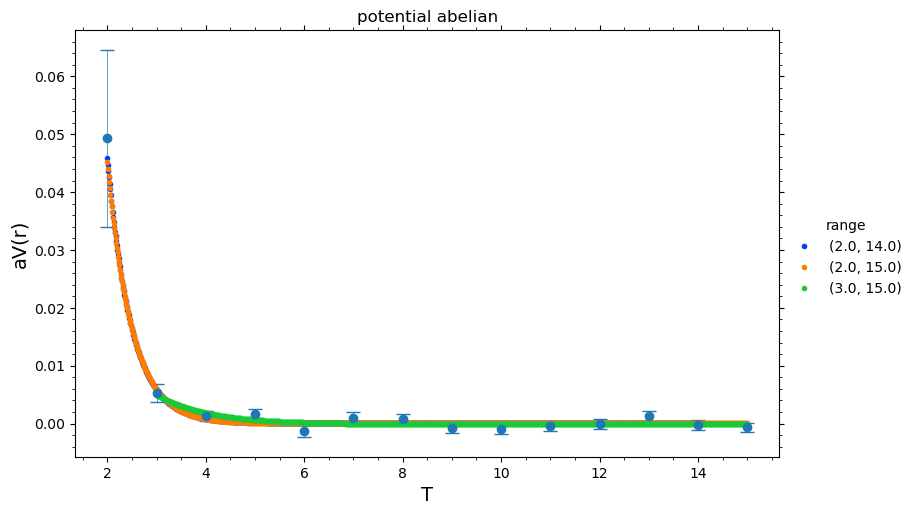

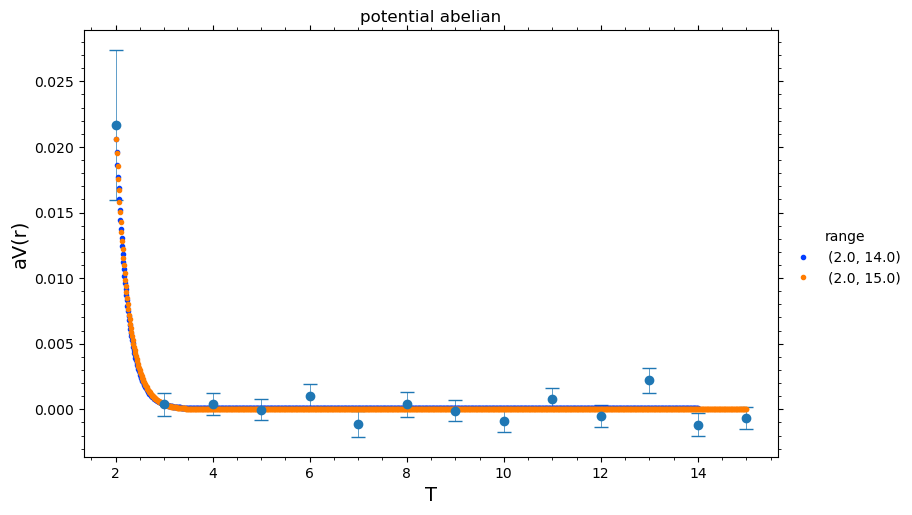

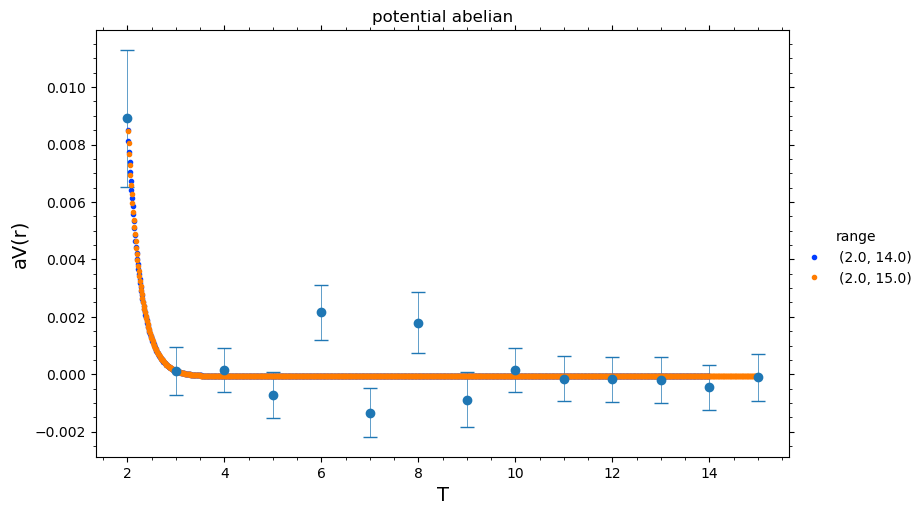

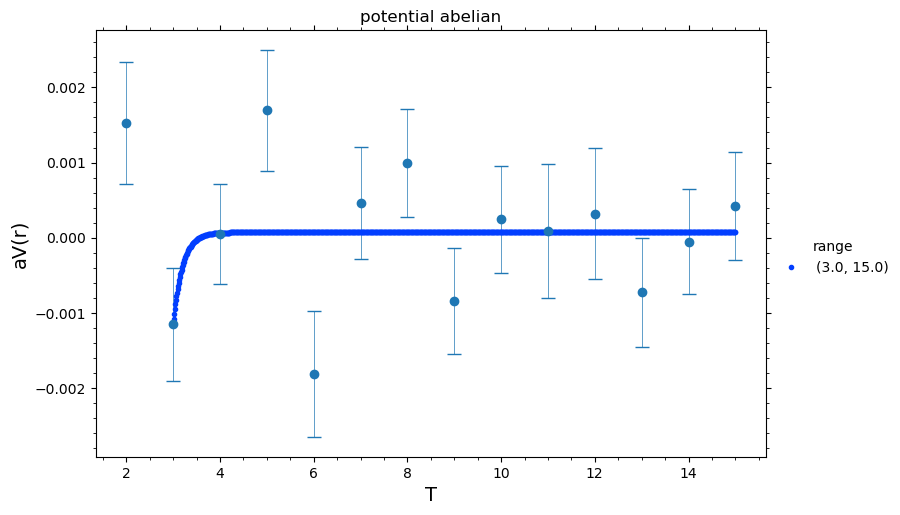

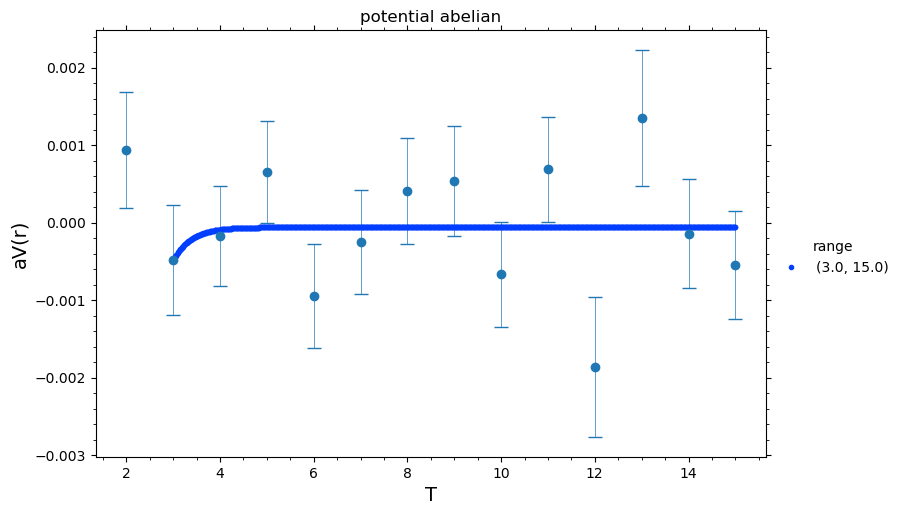

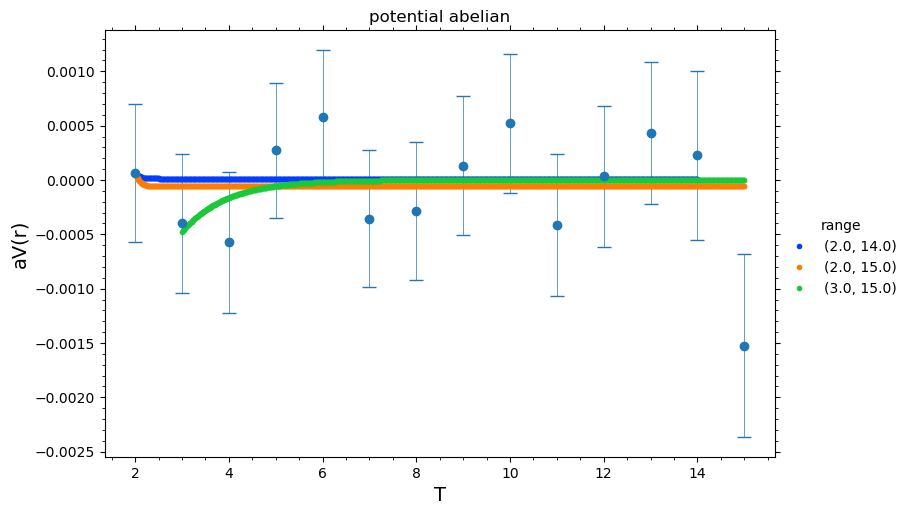

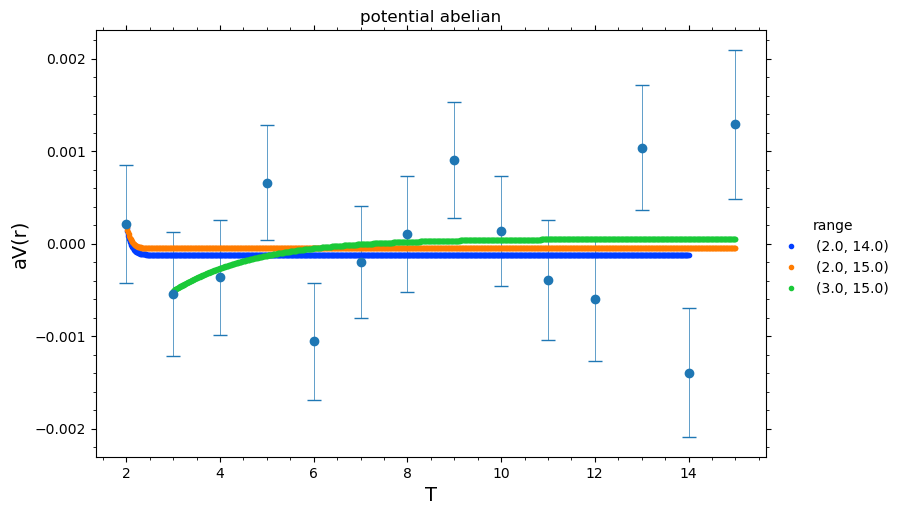

In [4]:
potential_gevp_T_fit('potential_gevp', '32^4', 'su3', 'gluodynamics', 32, 'beta6.0', '', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'abelian', copy=None)

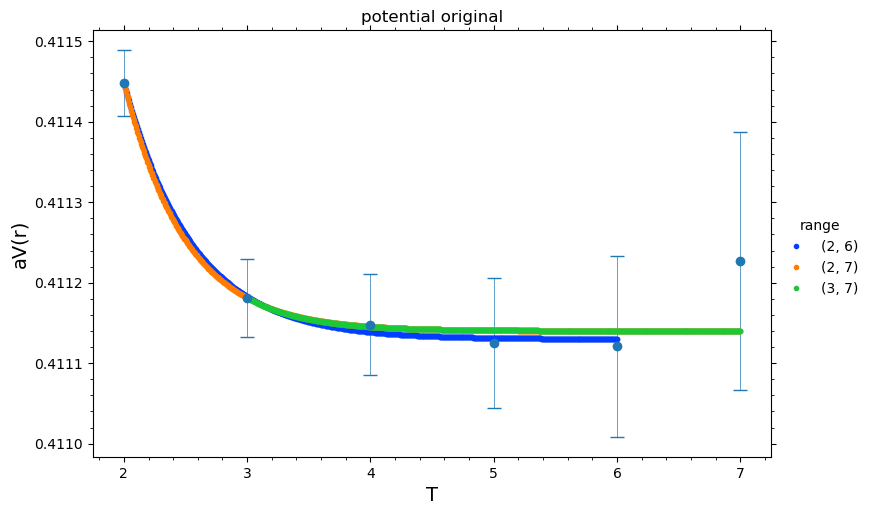

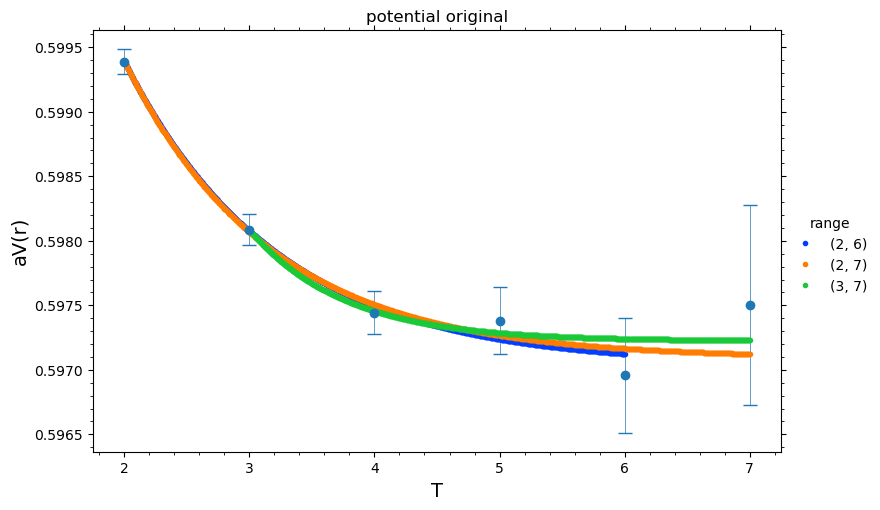

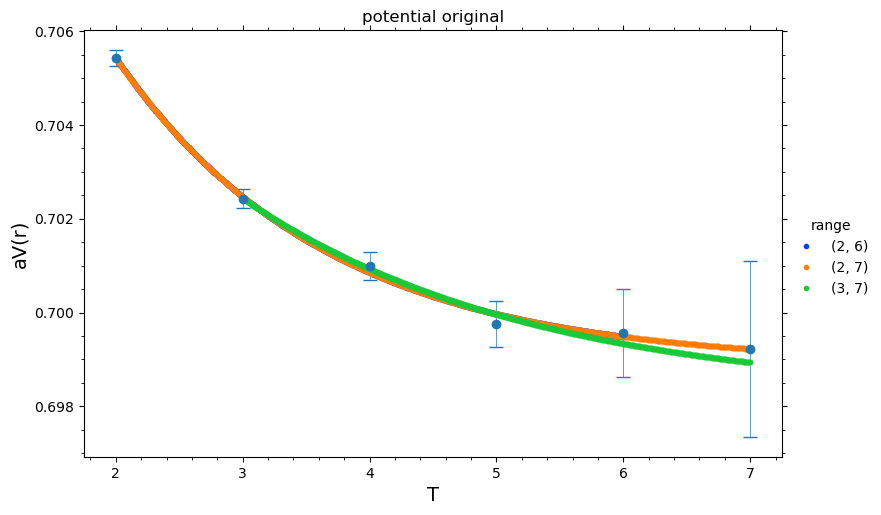

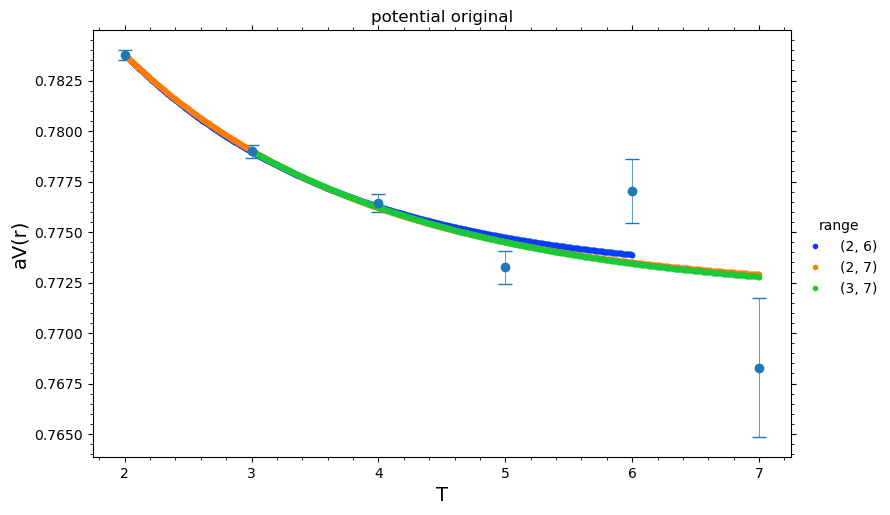

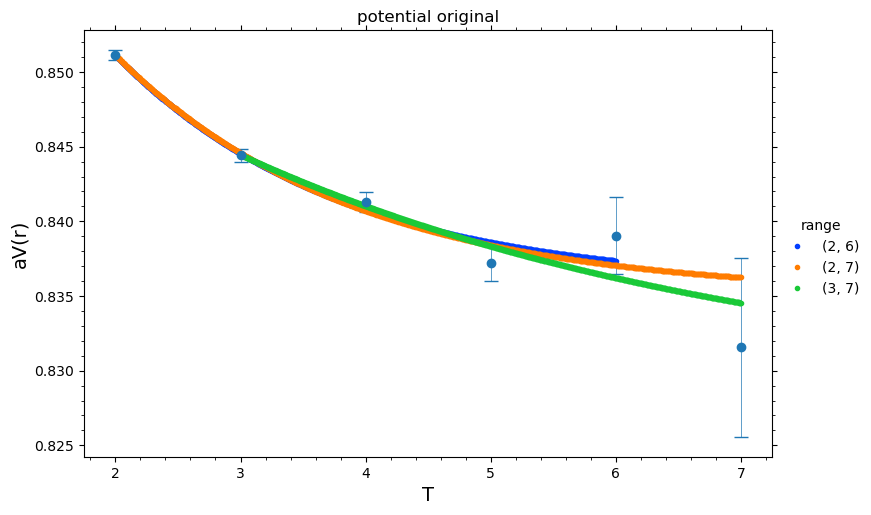

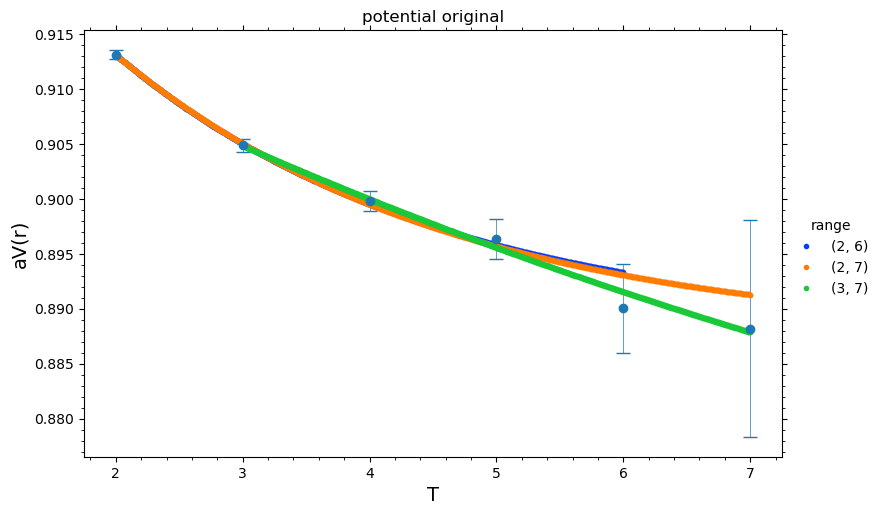

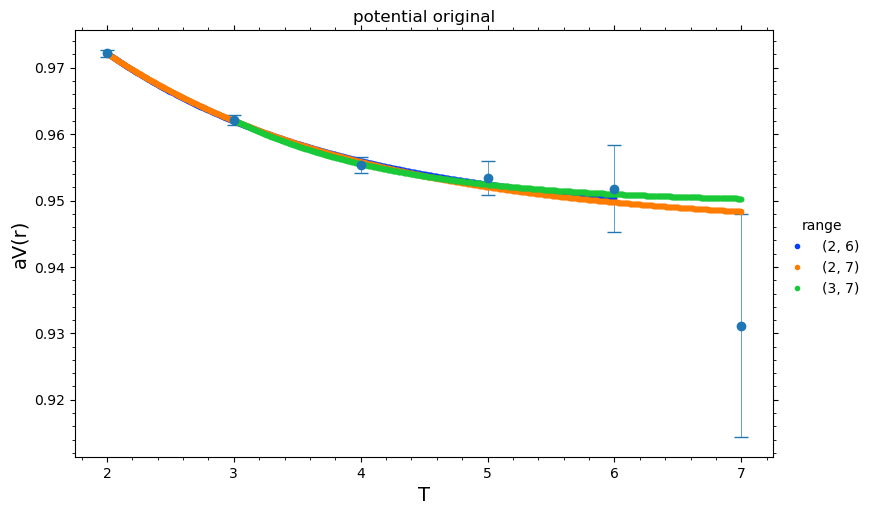

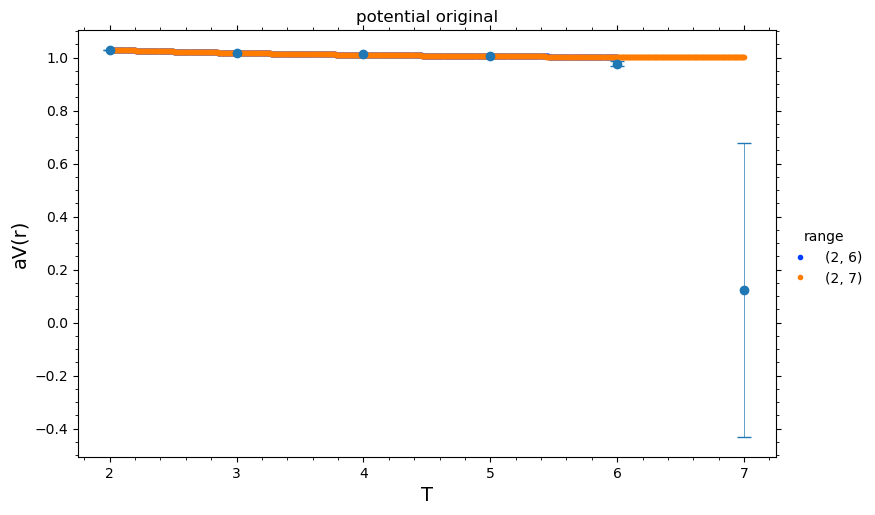

In [6]:
potential_gevp_T_fit('potential_gevp', '16^4', 'su3', 'gluodynamics', 16, 'beta6.0', '', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', '', 'original', copy=None)

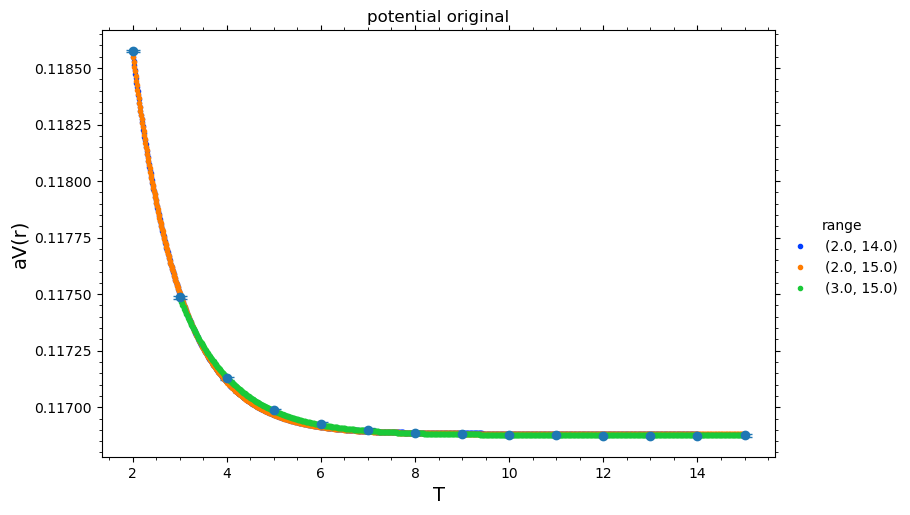

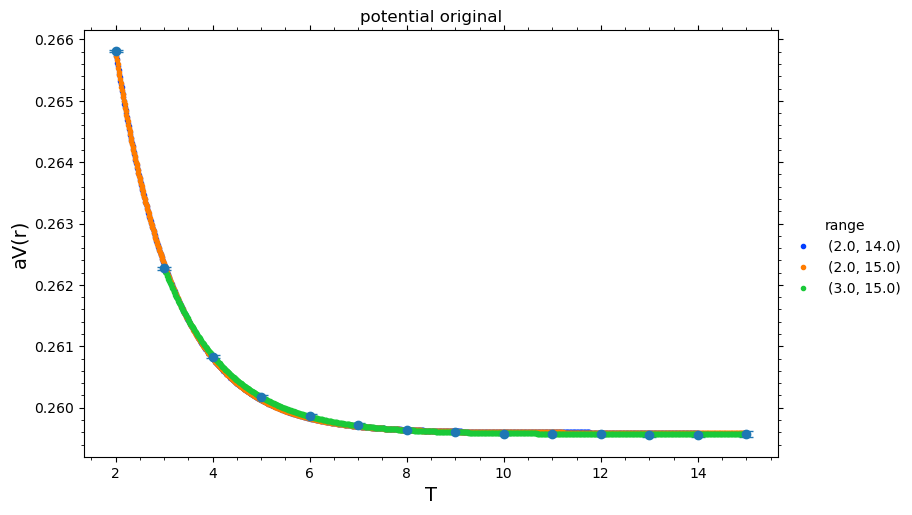

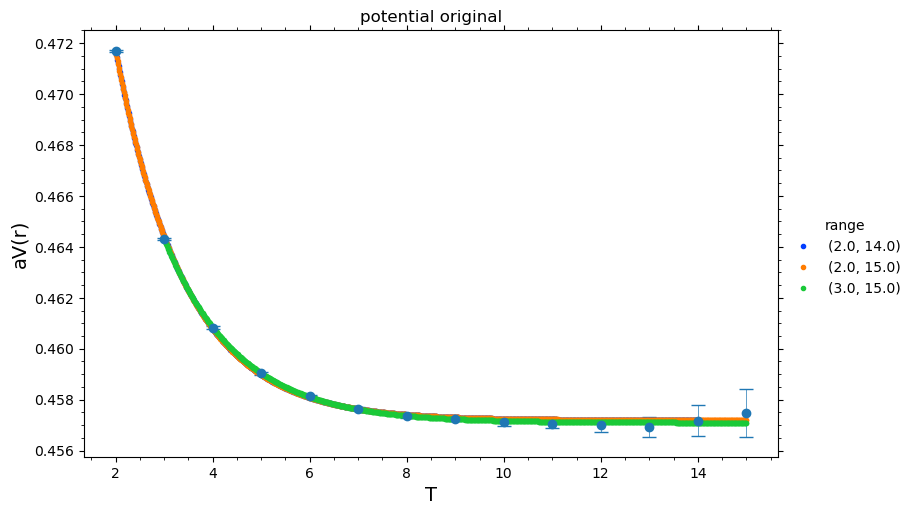

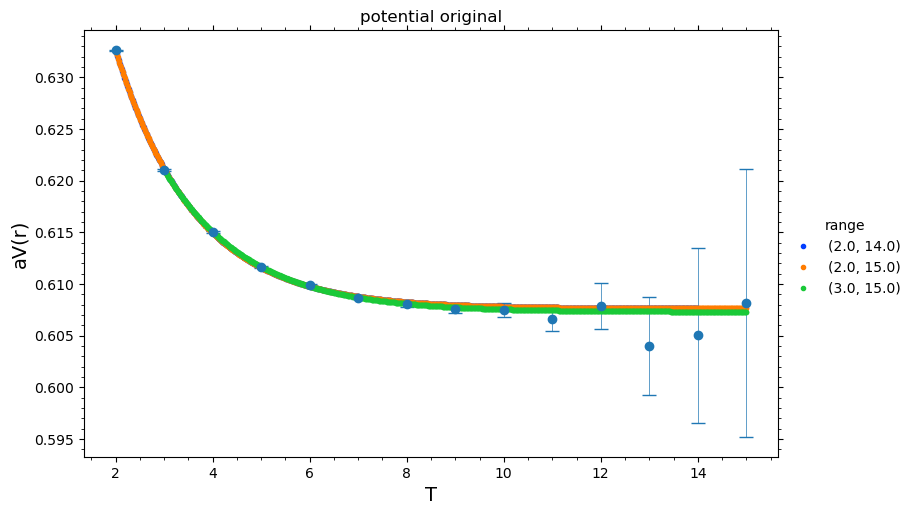

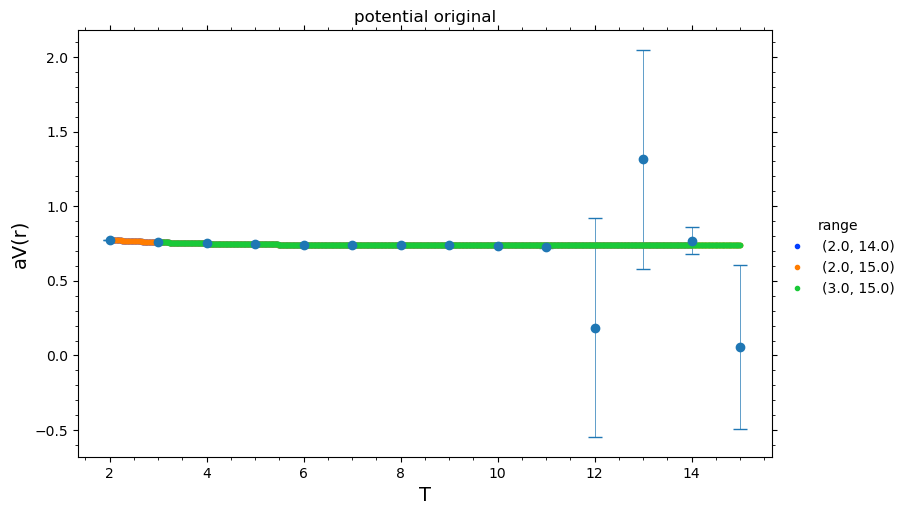

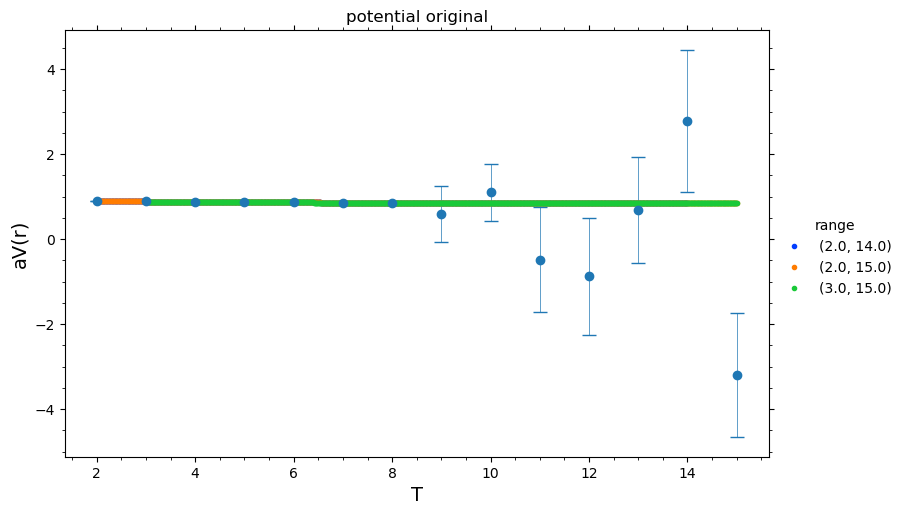

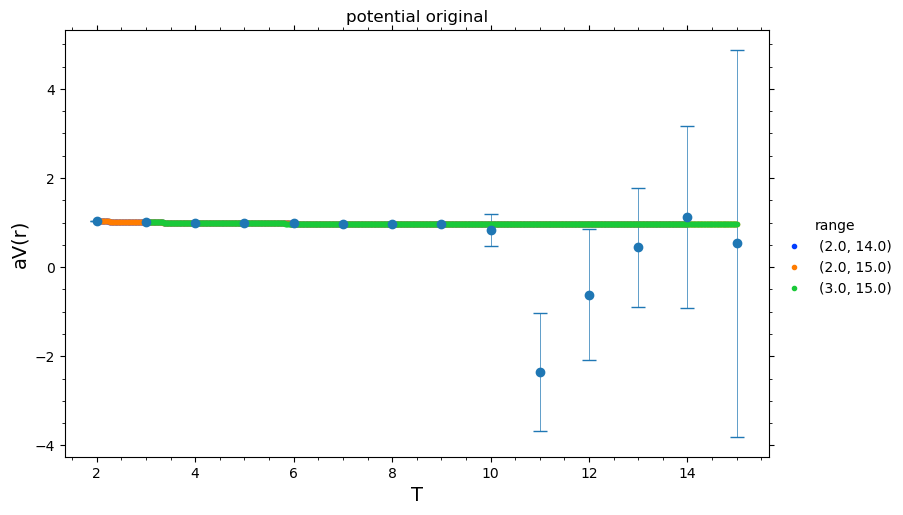

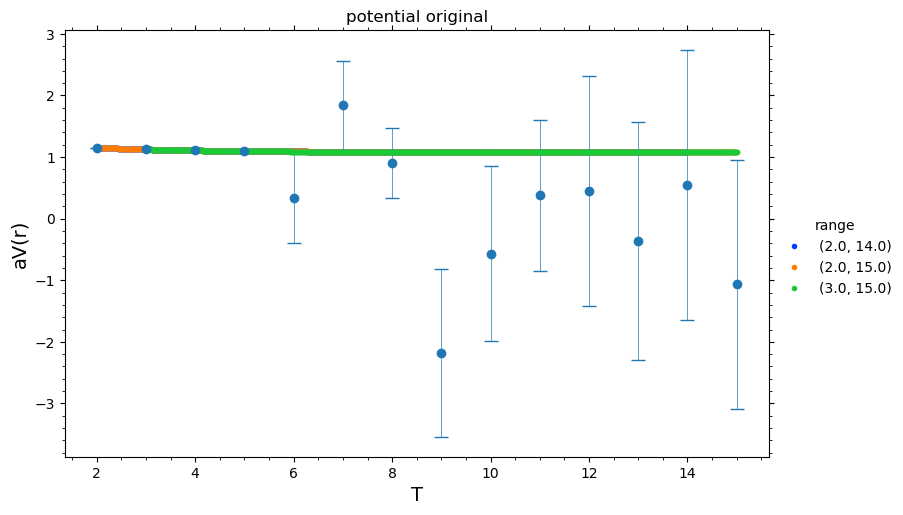

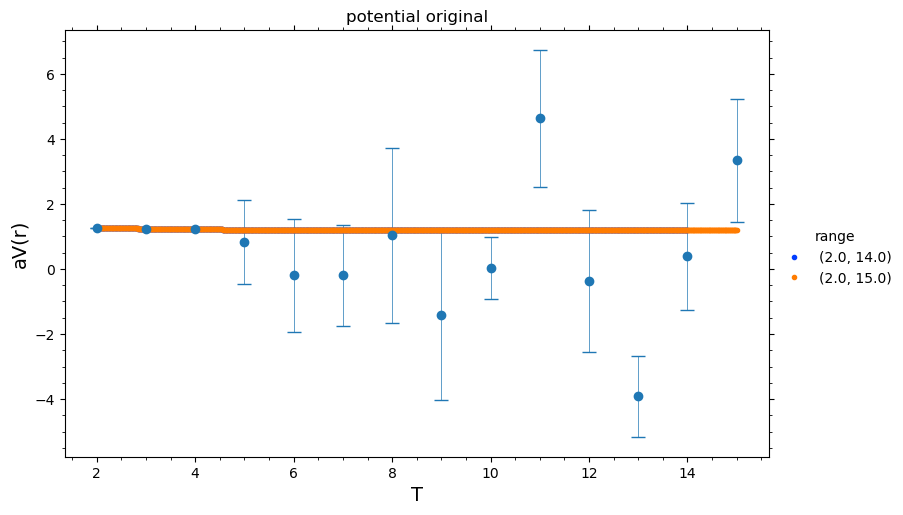

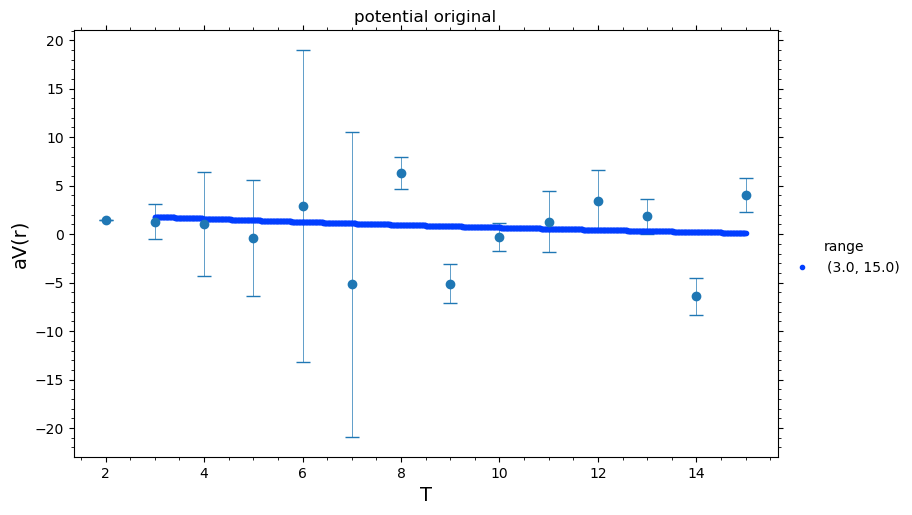

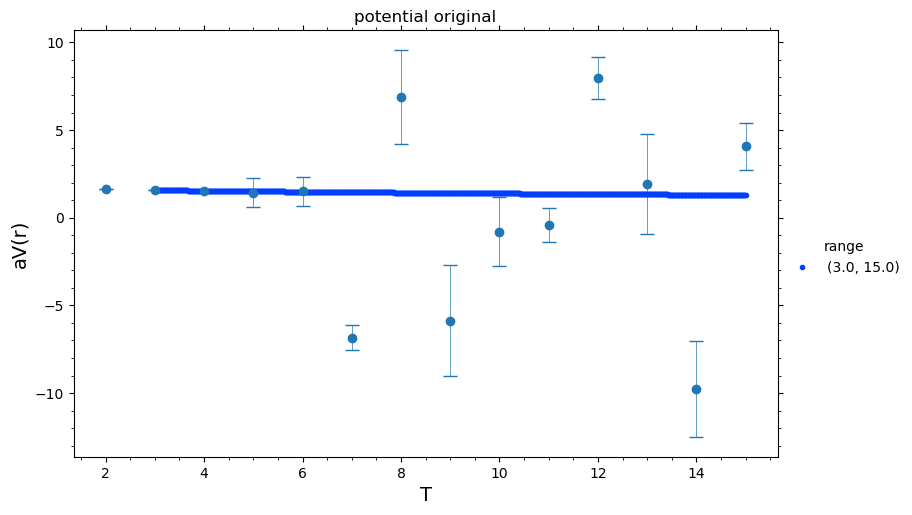

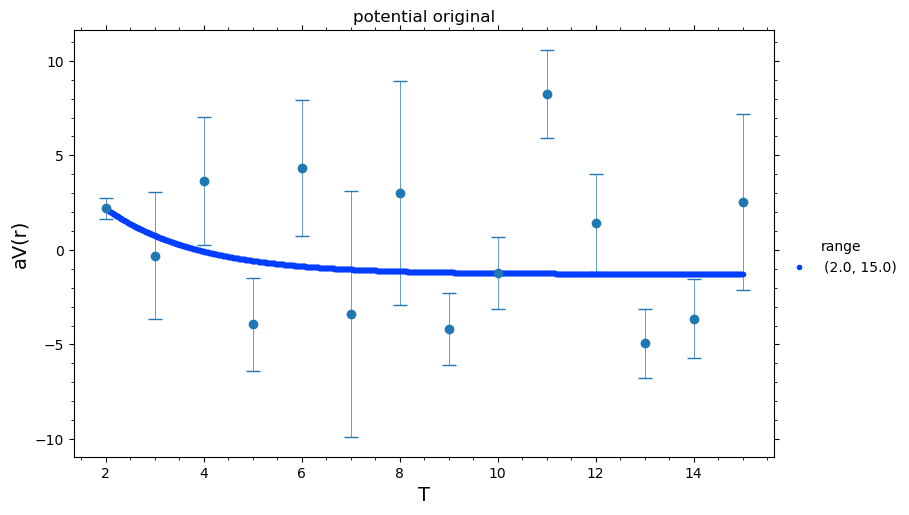

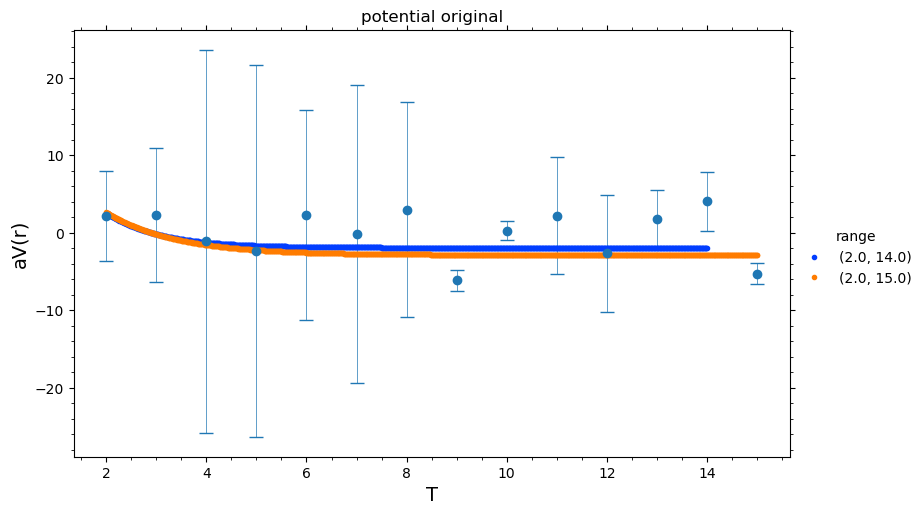

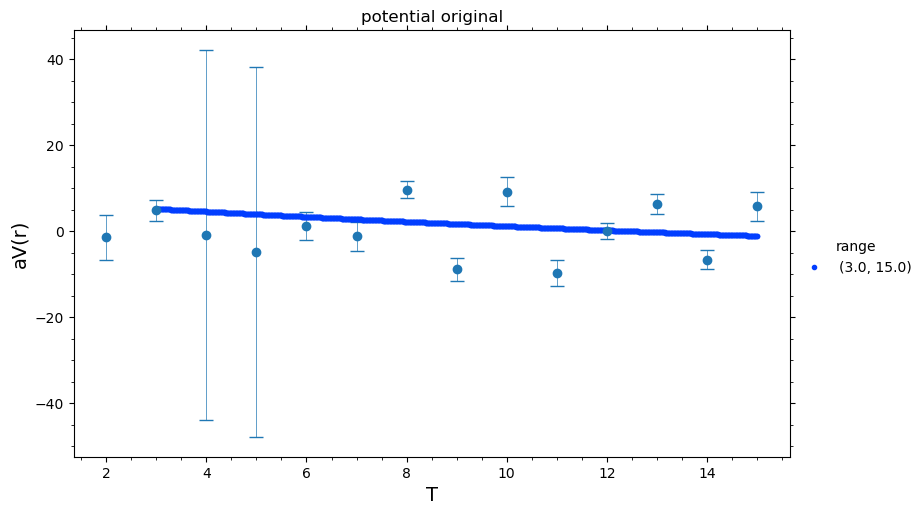

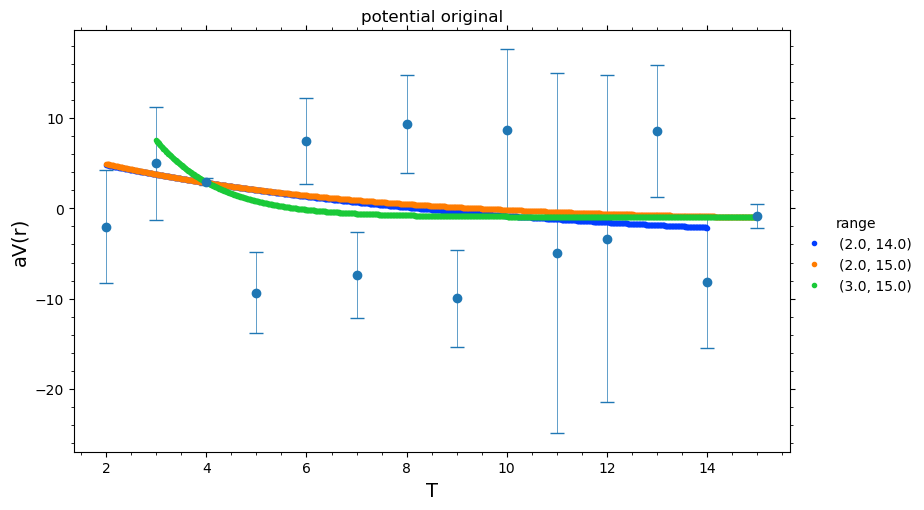

In [4]:
potential_gevp_T_fit('potential_gevp', '32^4', 'su3', 'gluodynamics', 32, 'beta6.0', '', 'HYP1_alpha=1_1_0.5_APE_alpha=0.6', '', 'original', copy=None)

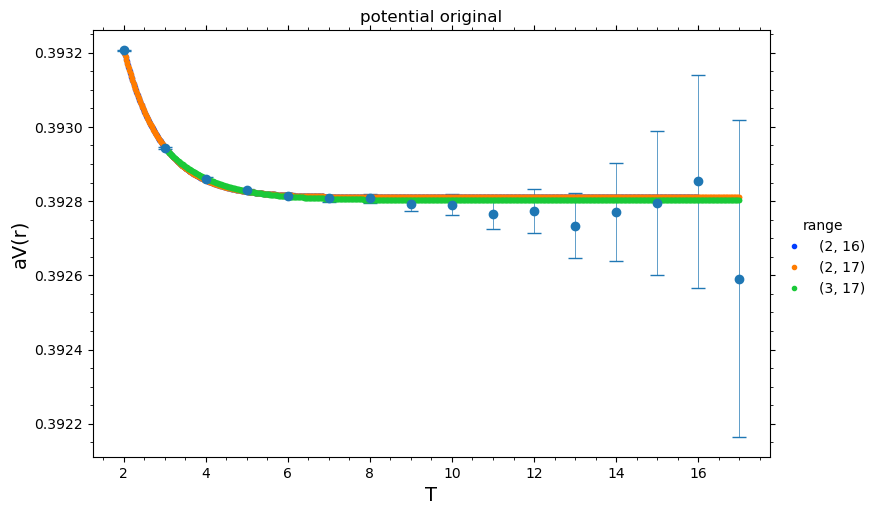

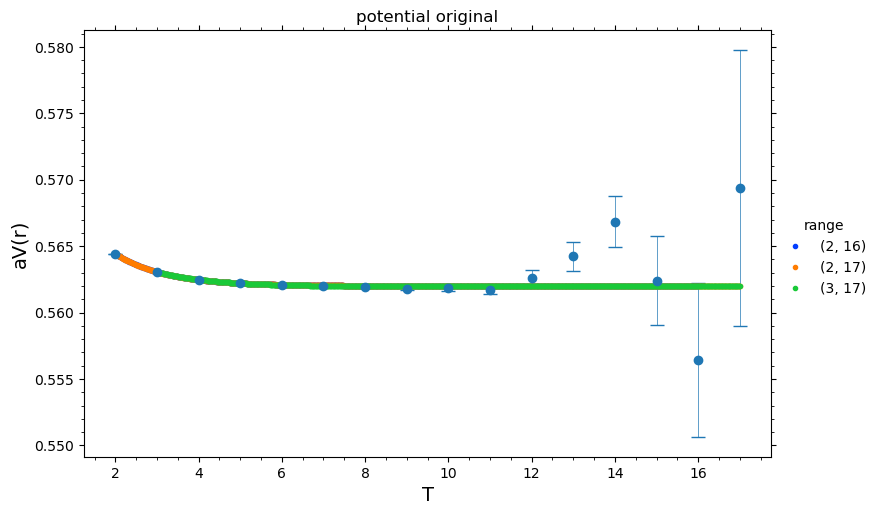

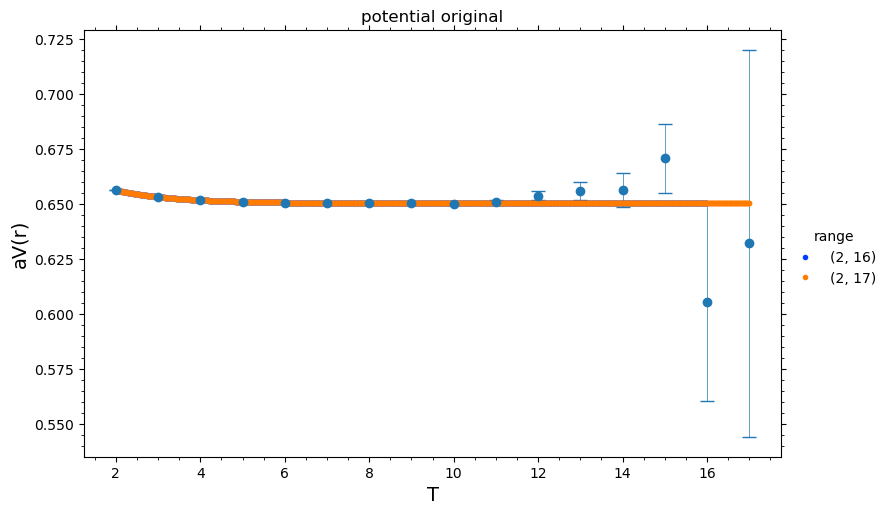

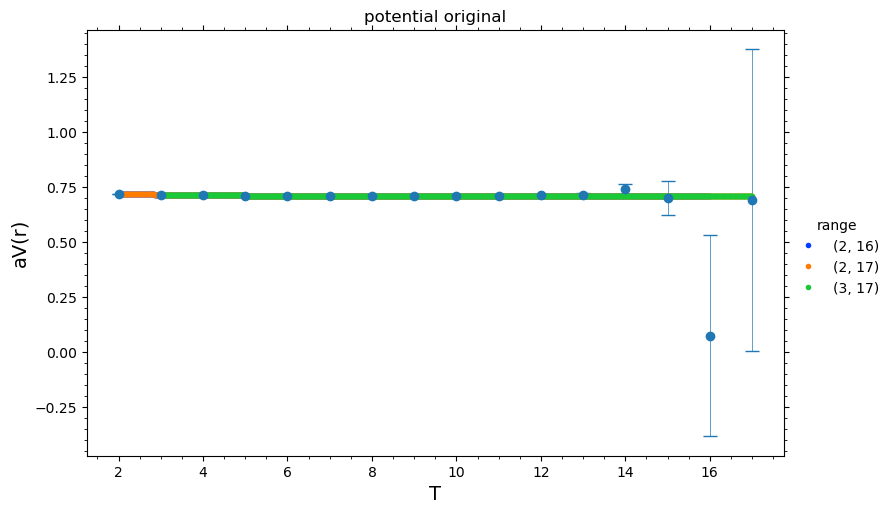

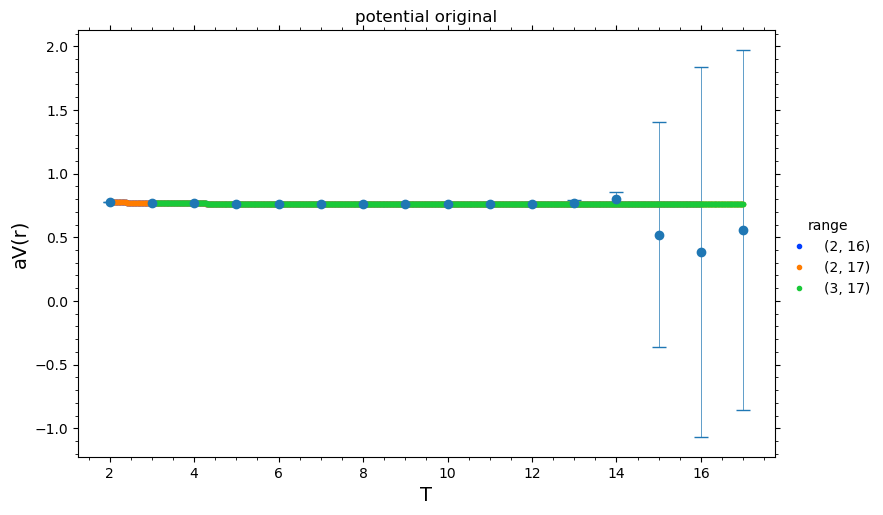

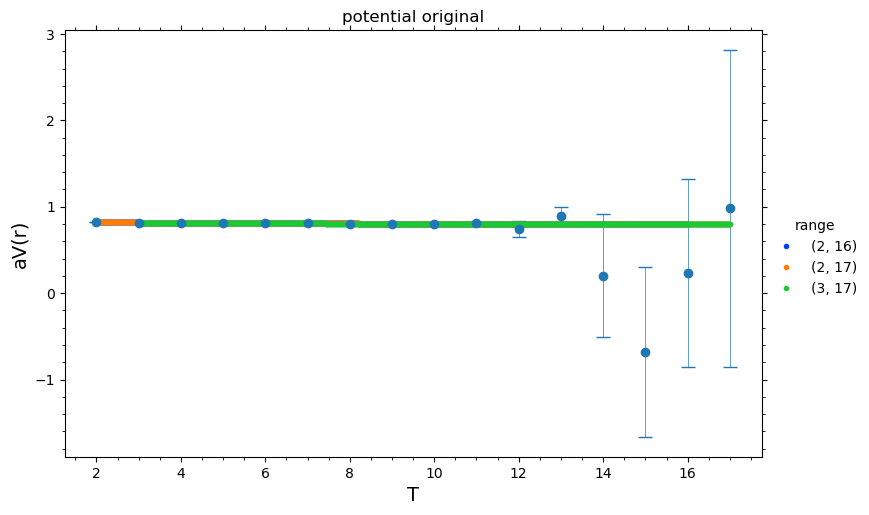

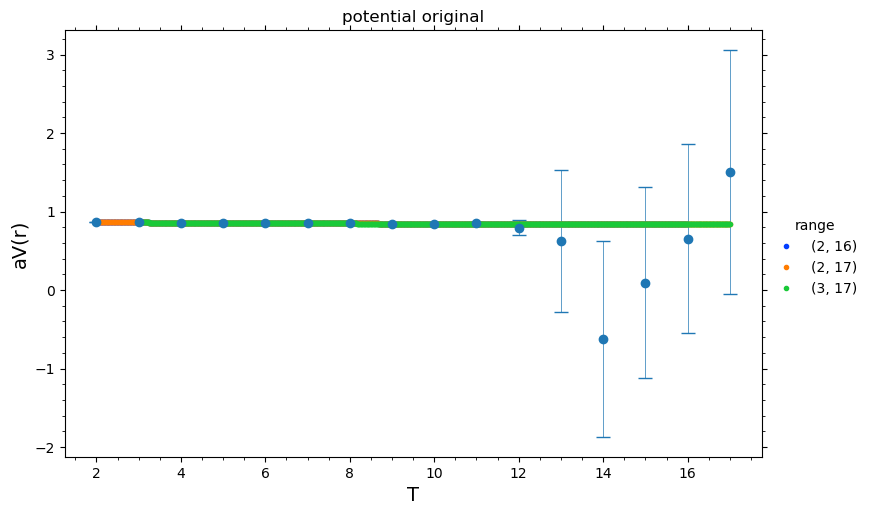

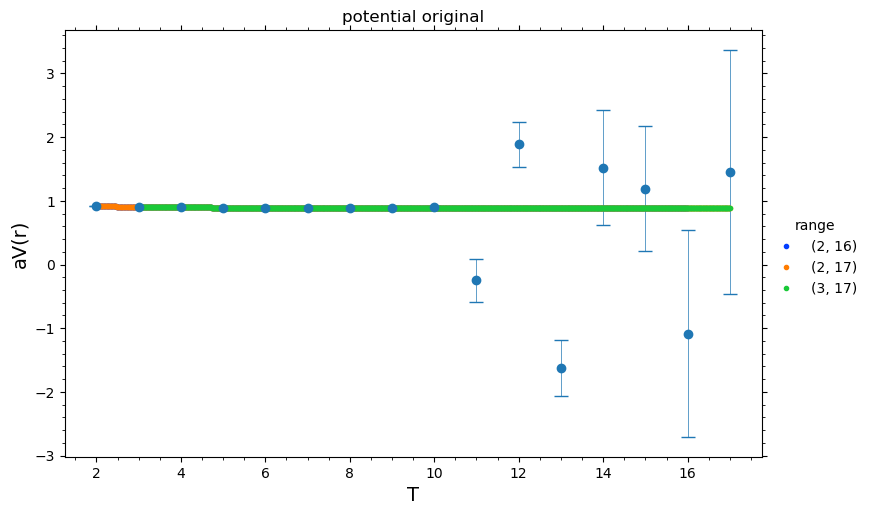

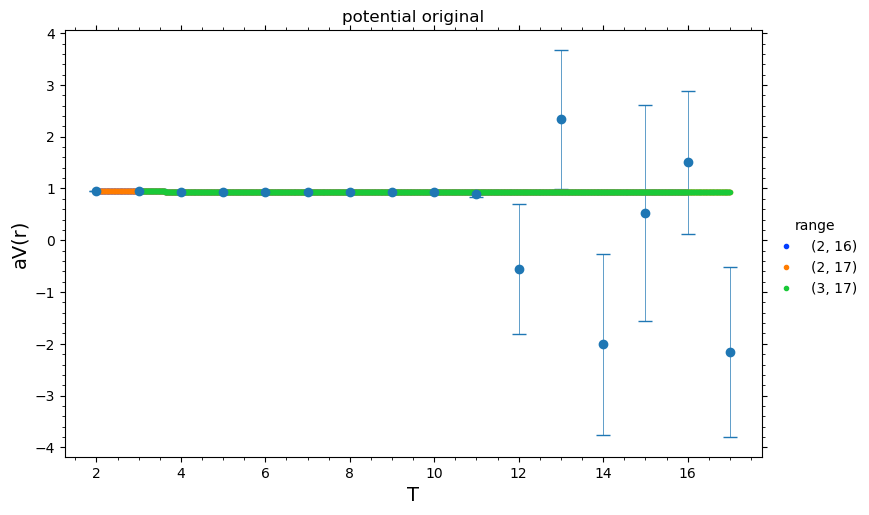

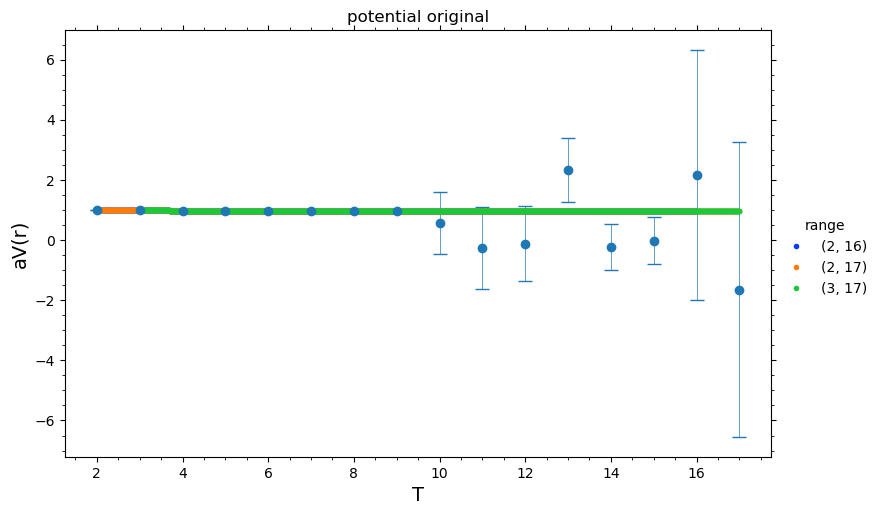

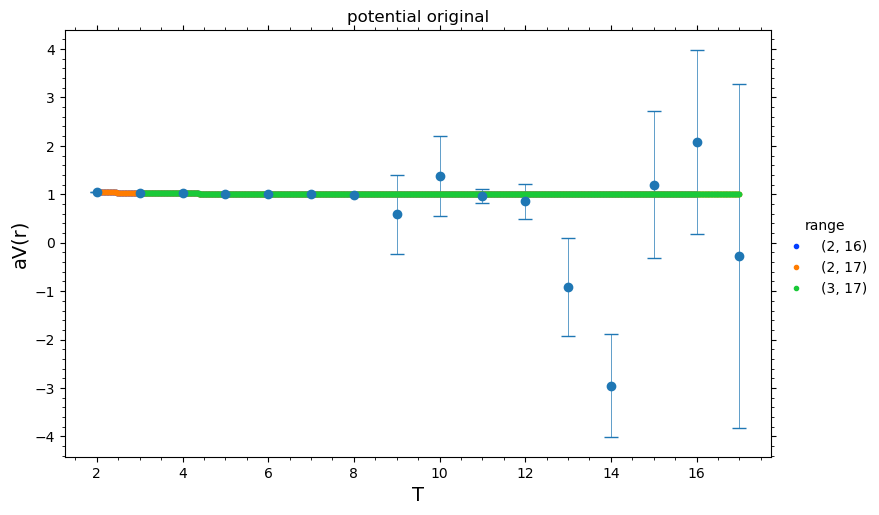

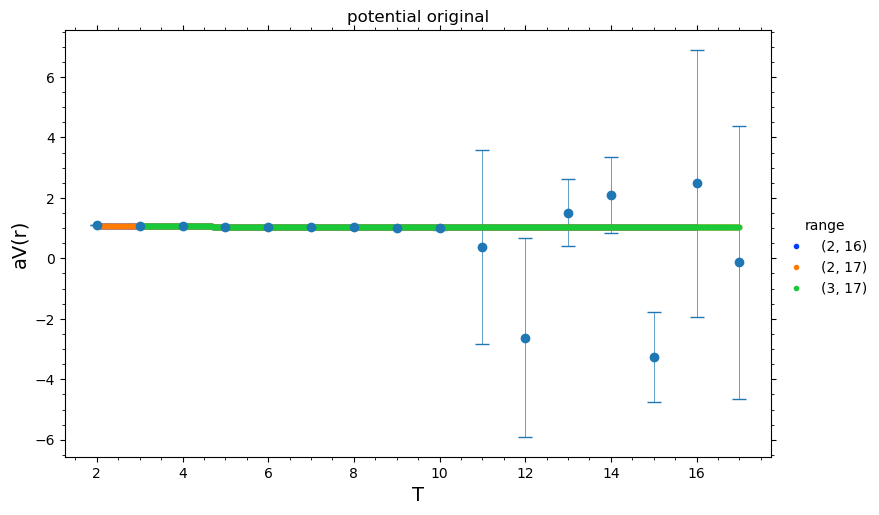

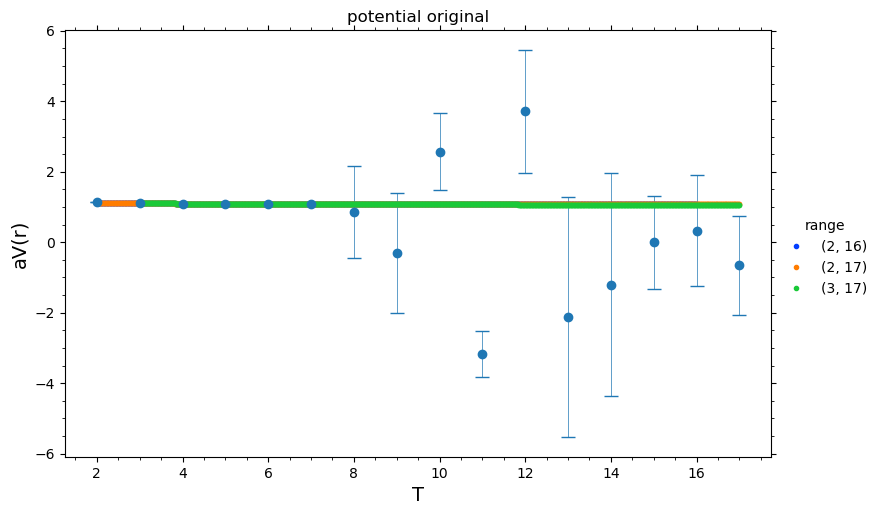

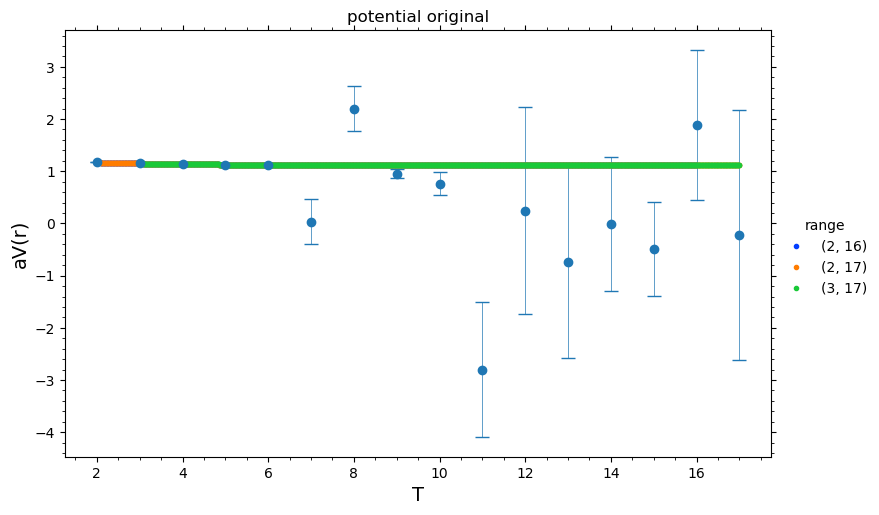

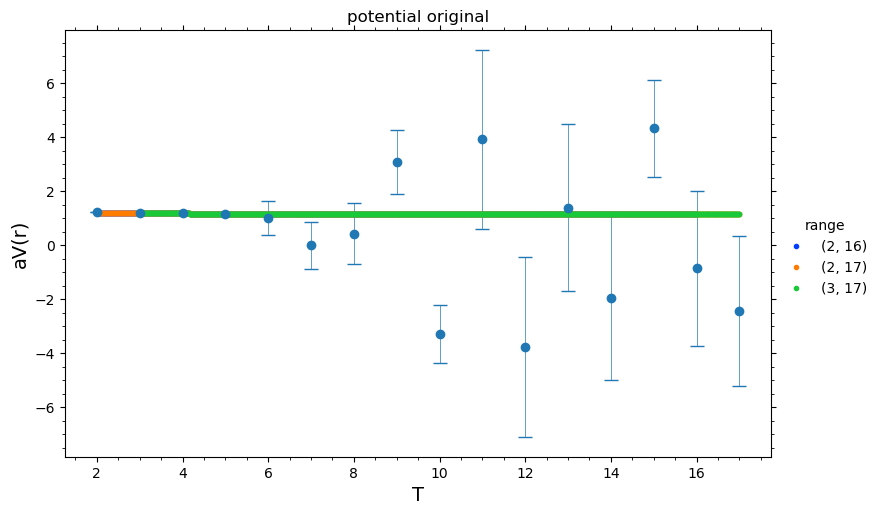

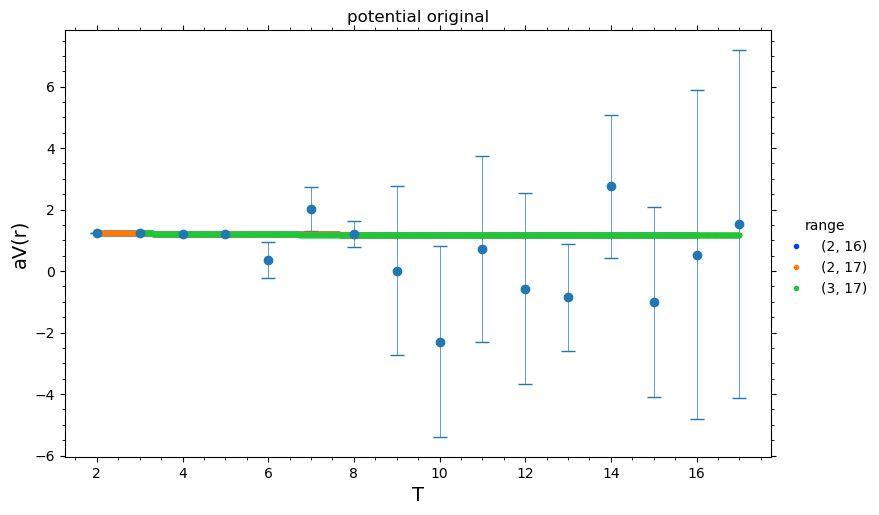

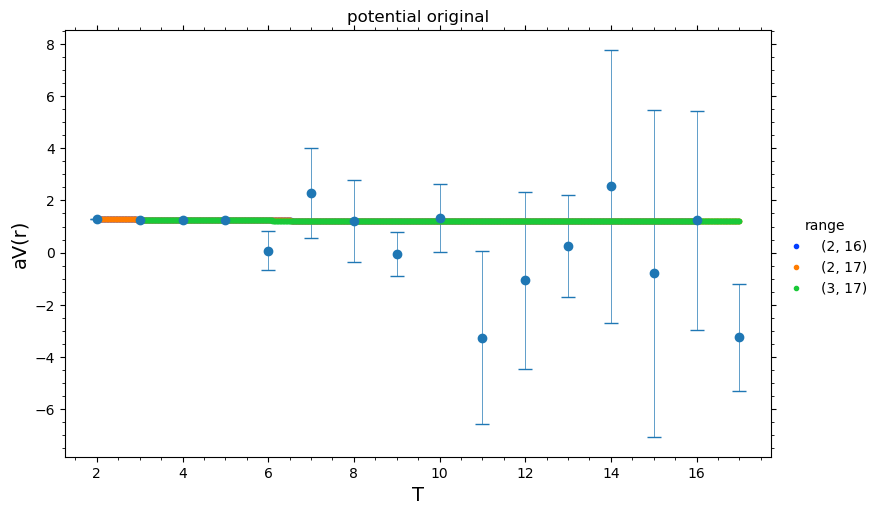

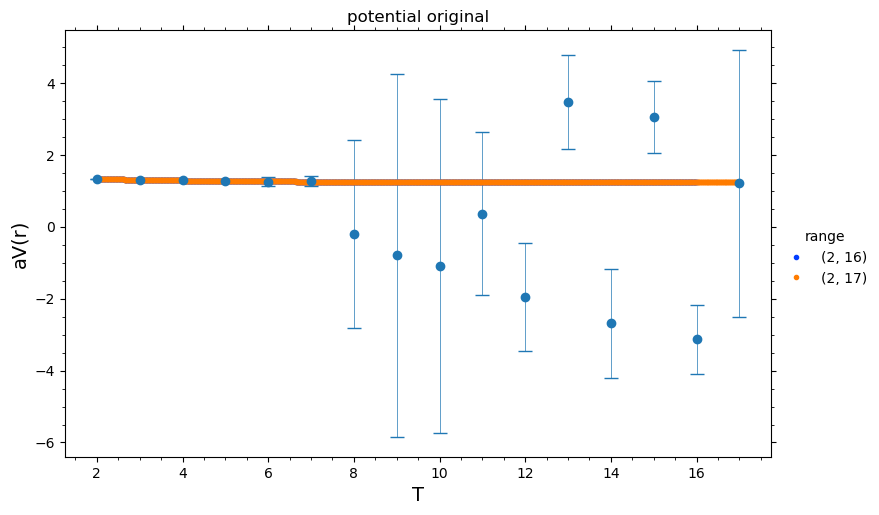

In [4]:
potential_gevp_T_fit('potential_gevp', '36^4', 'su3', 'gluodynamics', 36, 'beta6.1', '', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', '', 'original', copy=None)

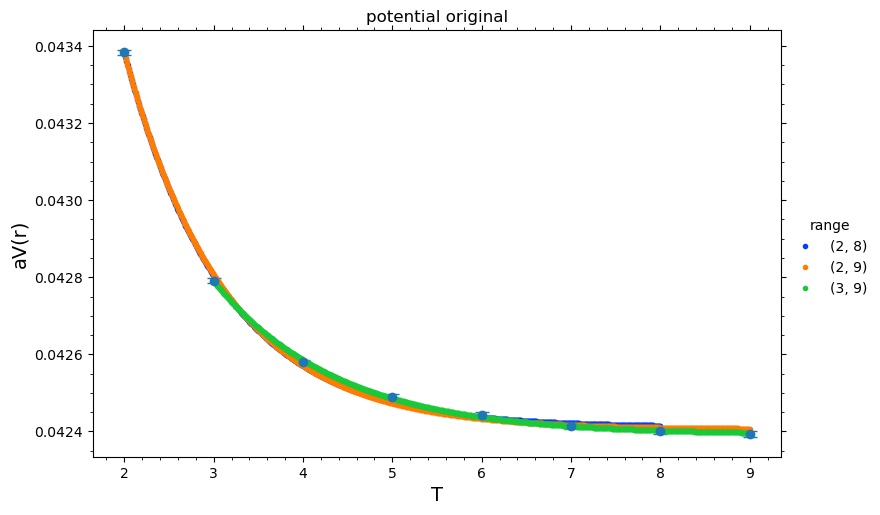

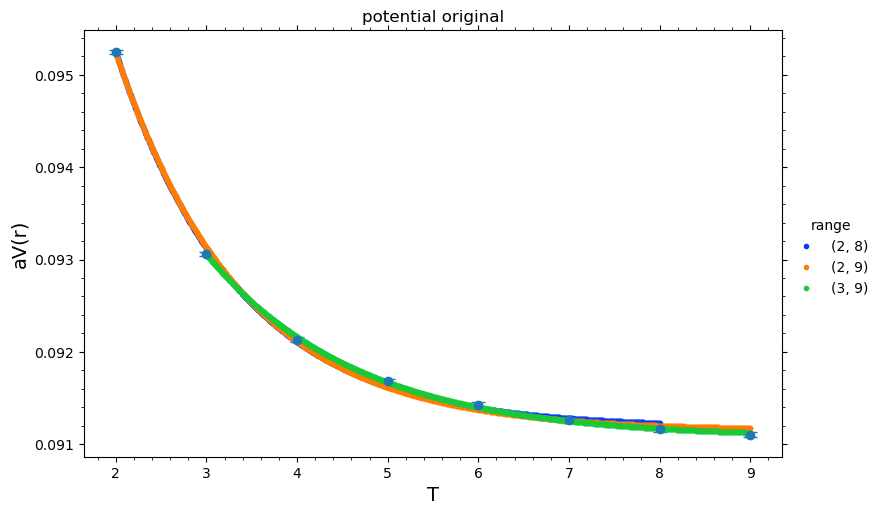

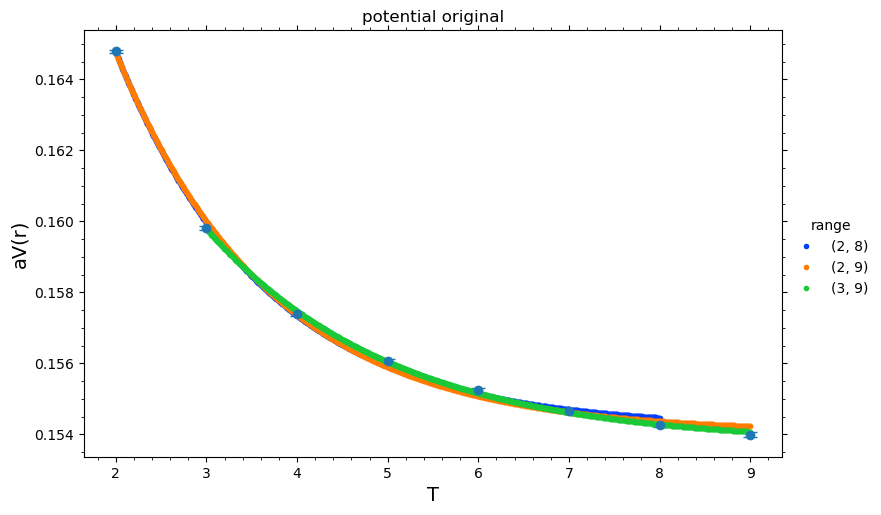

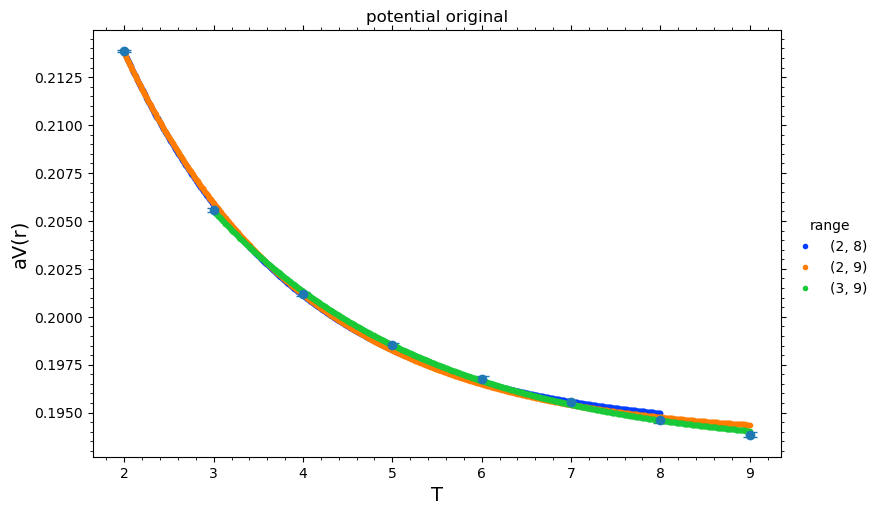

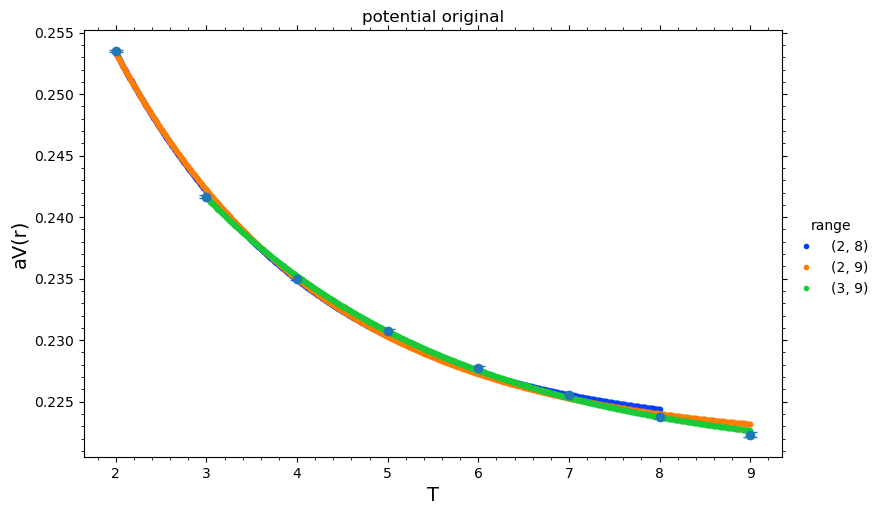

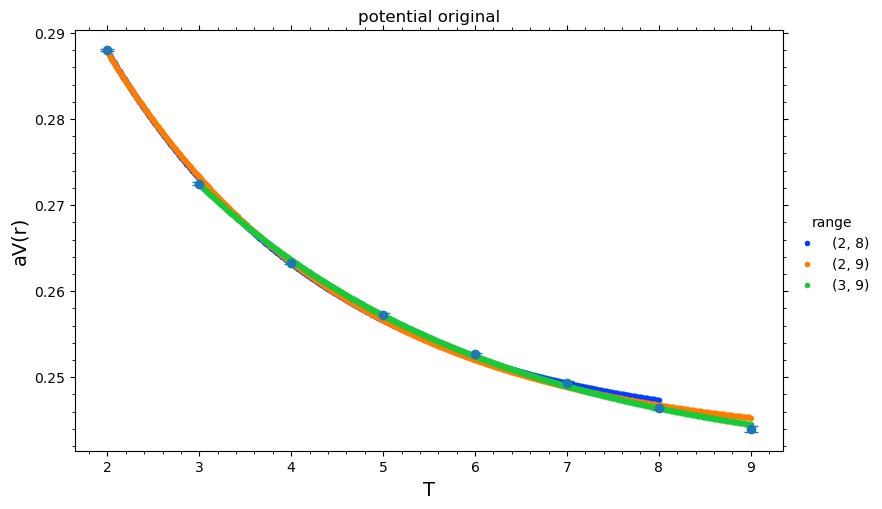

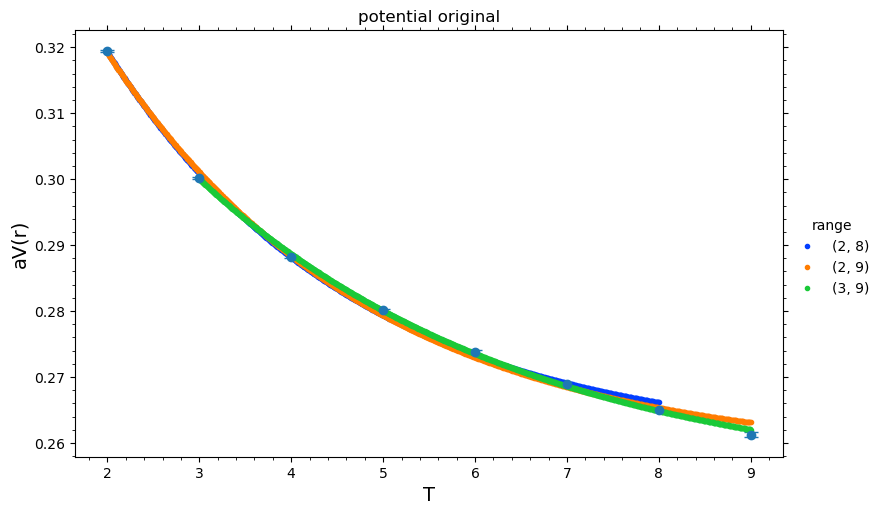

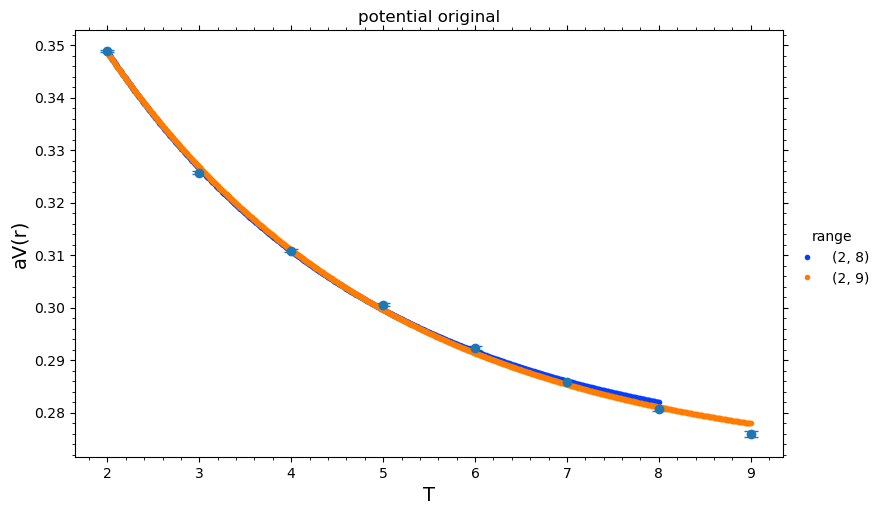

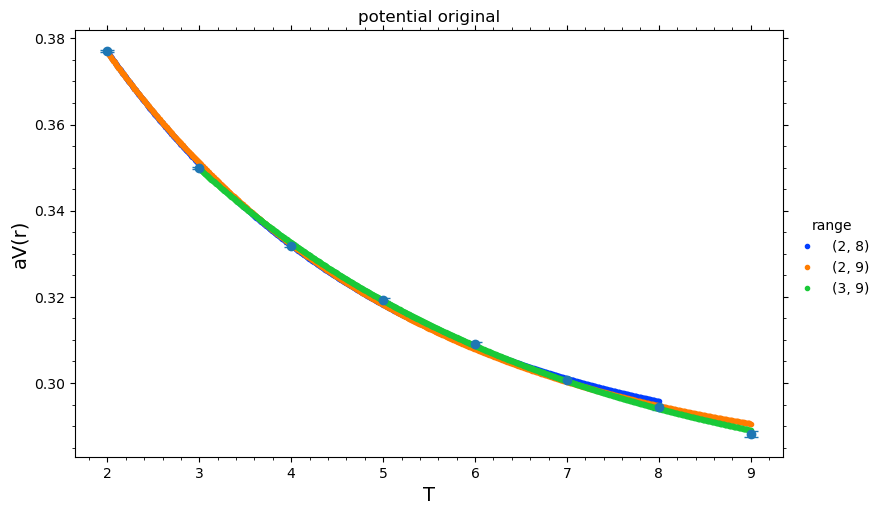

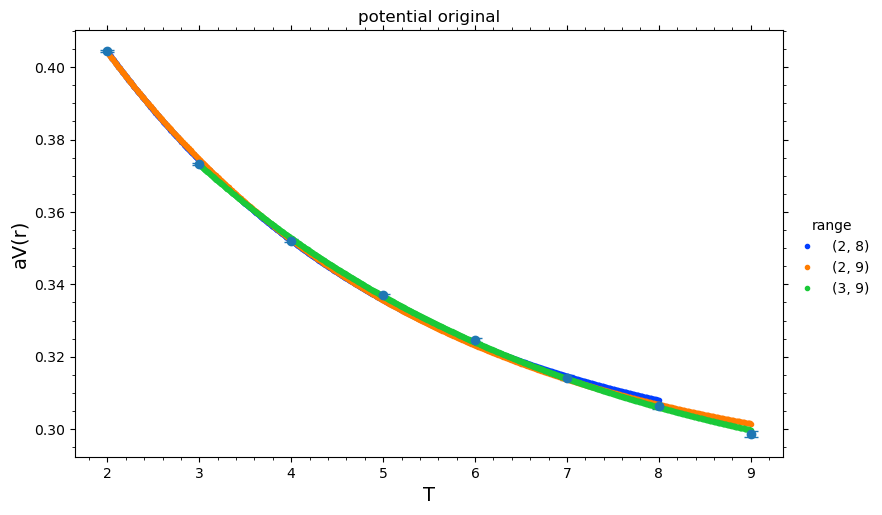

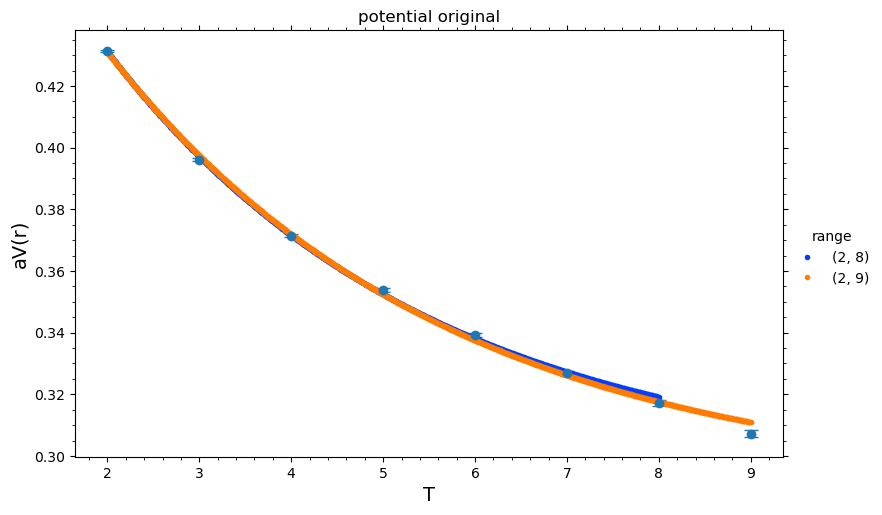

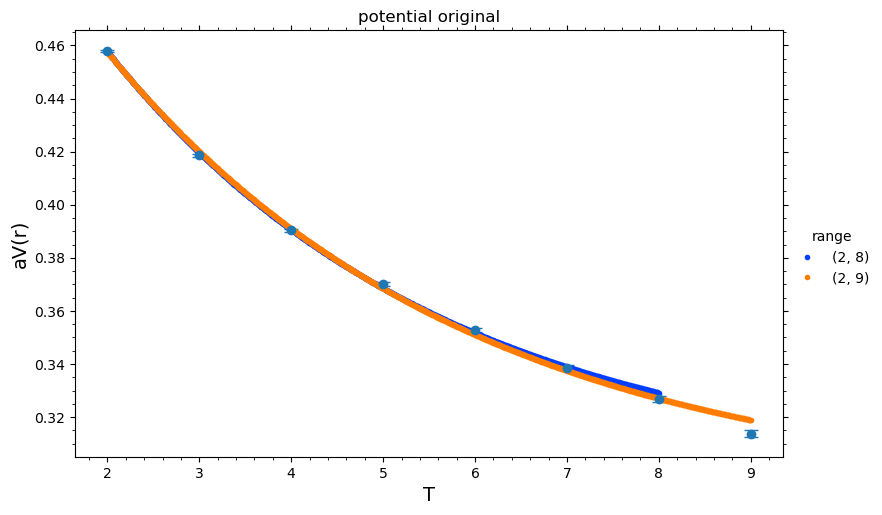

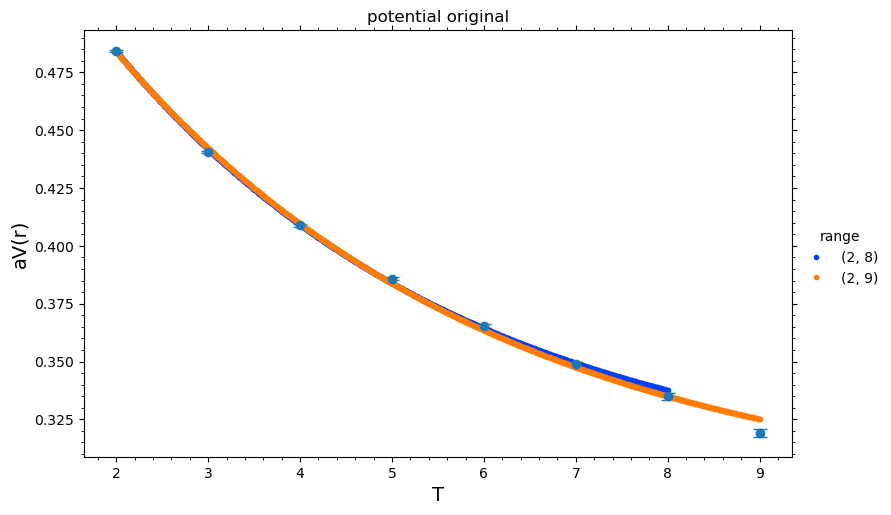

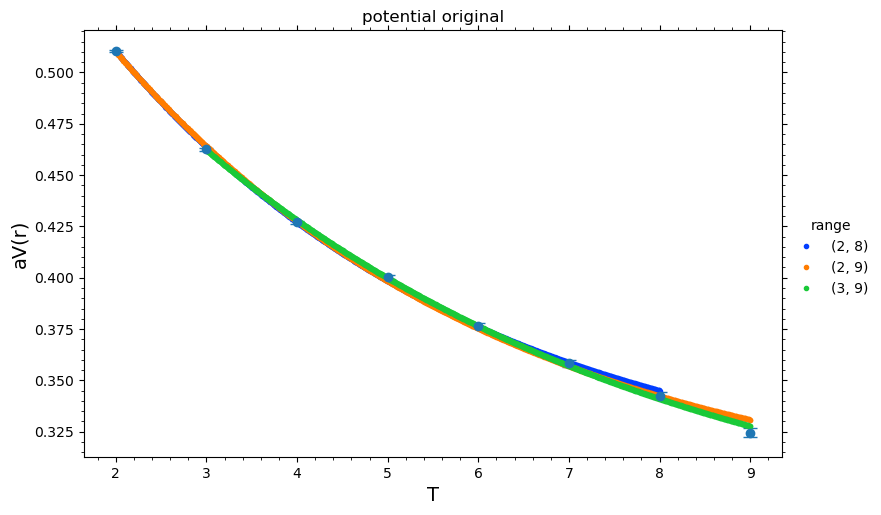

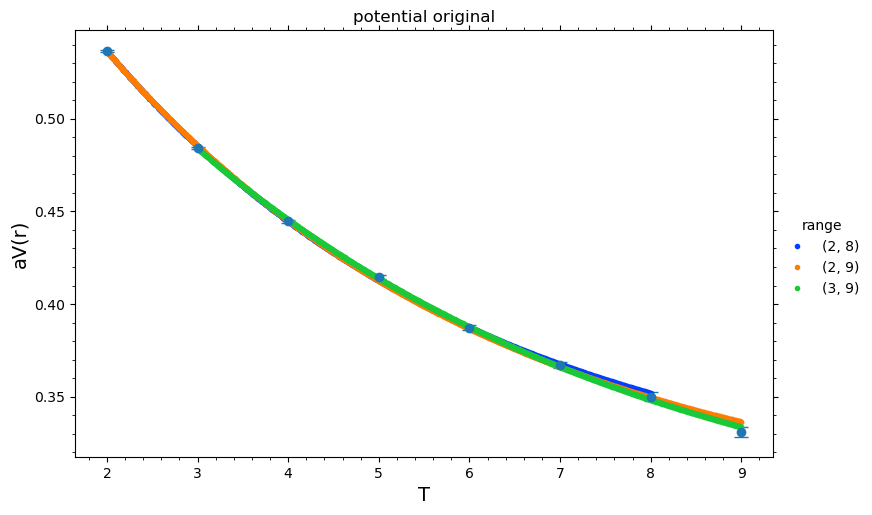

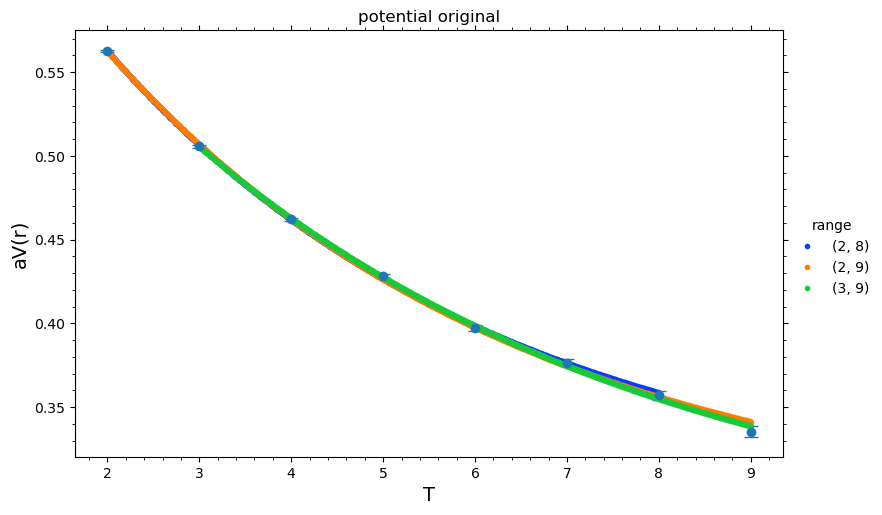

In [5]:
potential_gevp_T_fit('potential_gevp', '32^3x20', 'su2', 'qc2dstag', 20, '', 'mu0.15', 'HYP1_alpha=1_1_0.5_APE_alpha=0.6', '', 'original', copy=None)

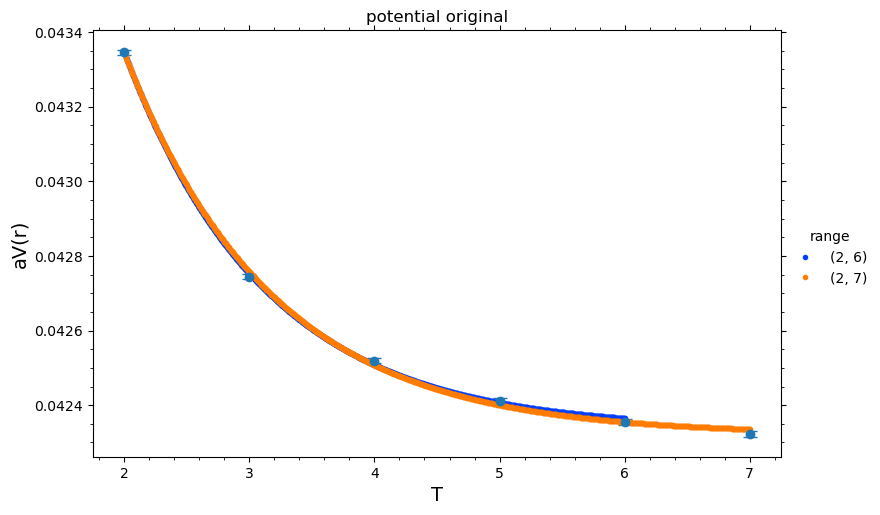

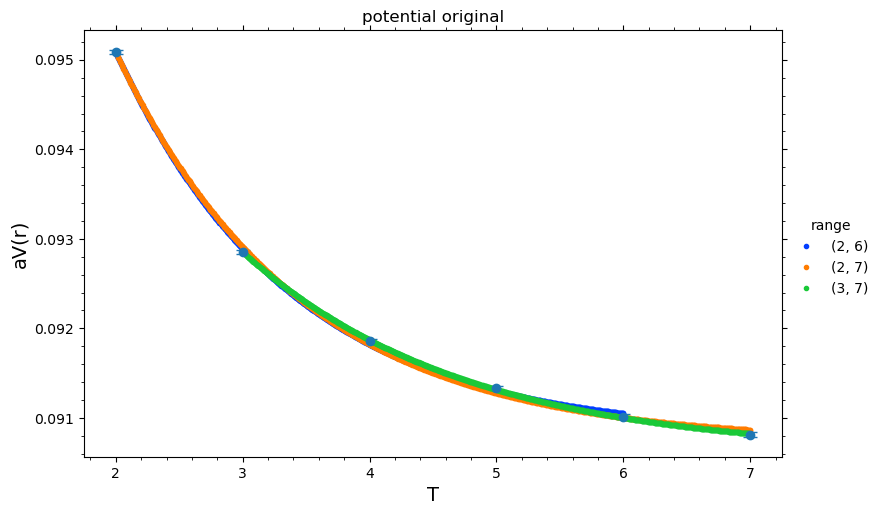

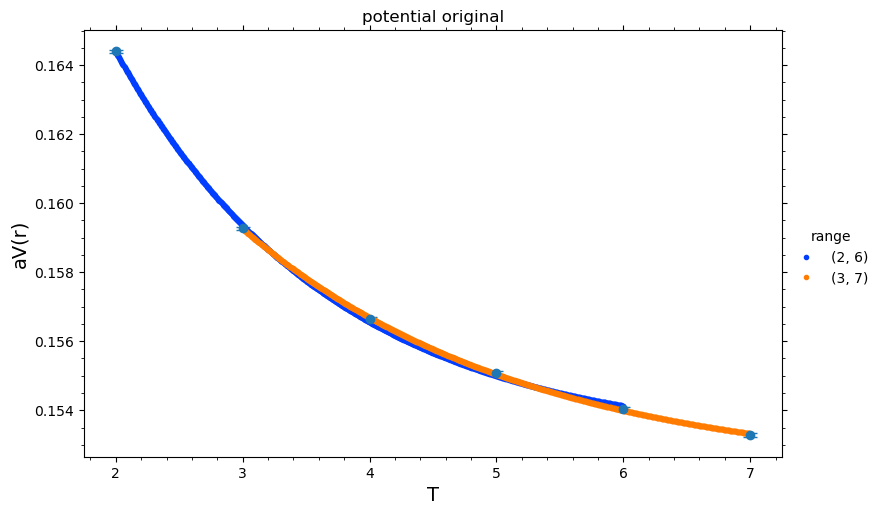

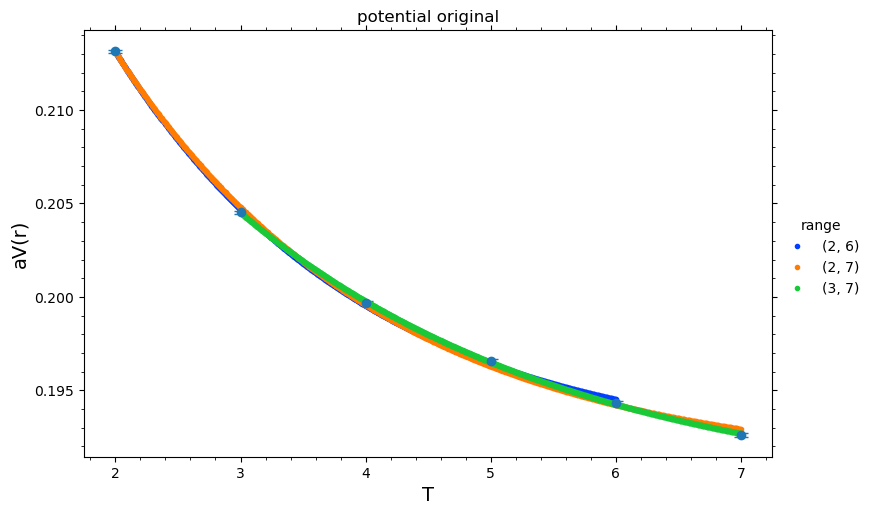

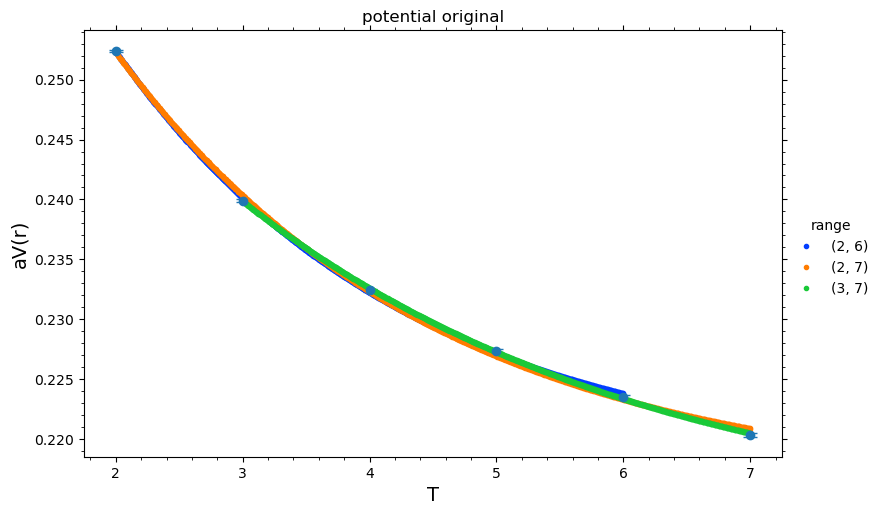

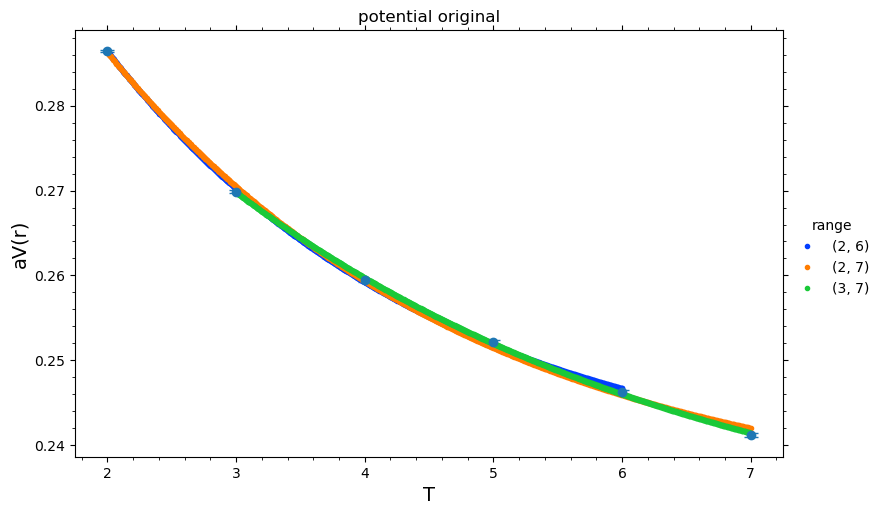

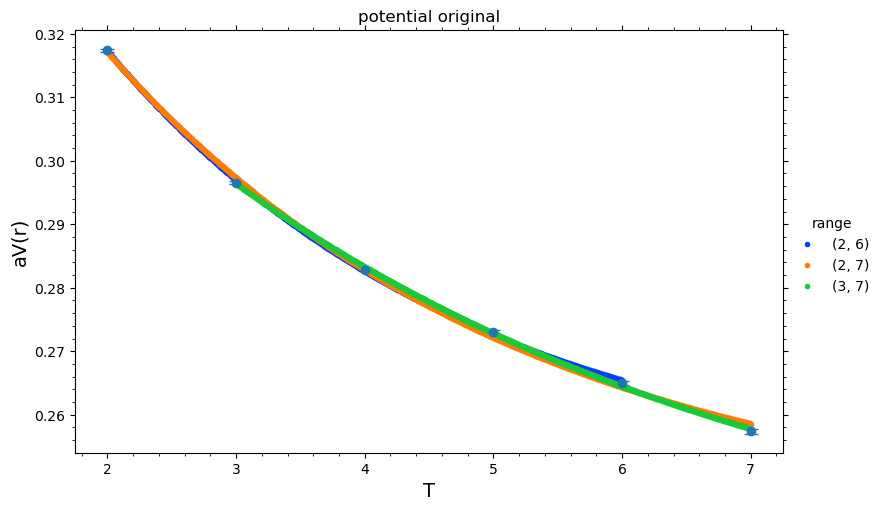

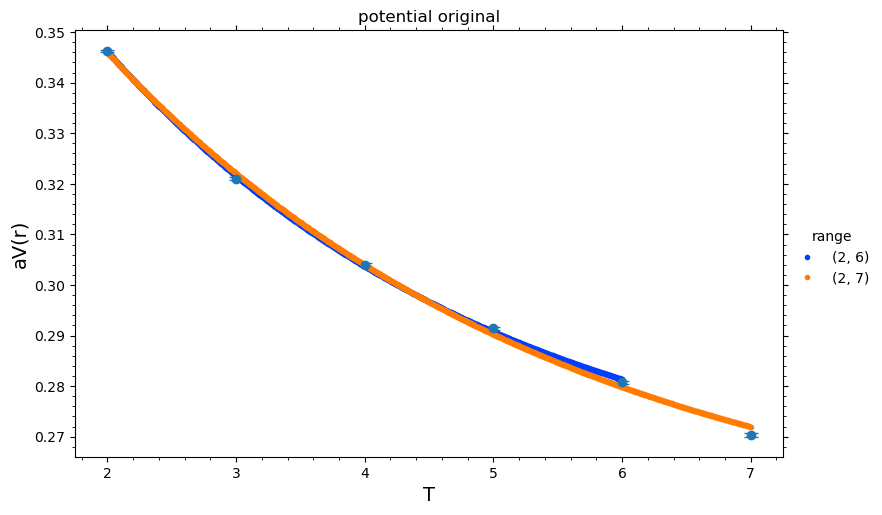

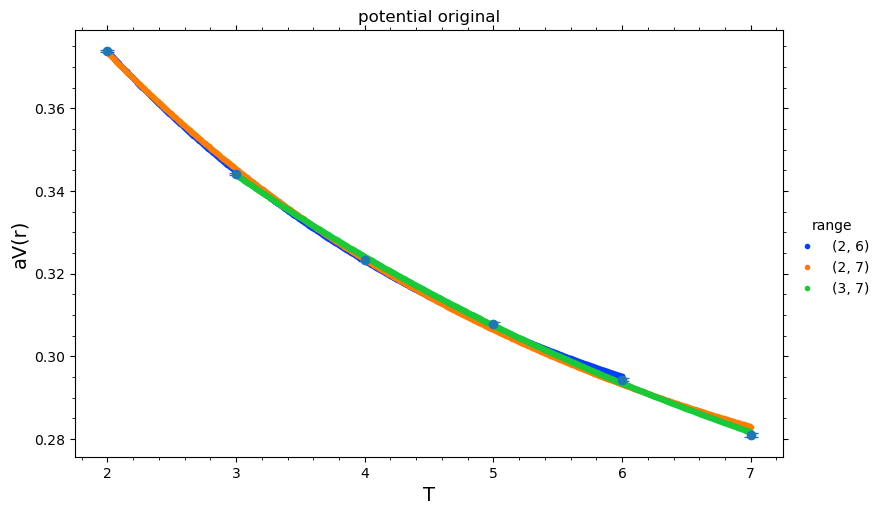

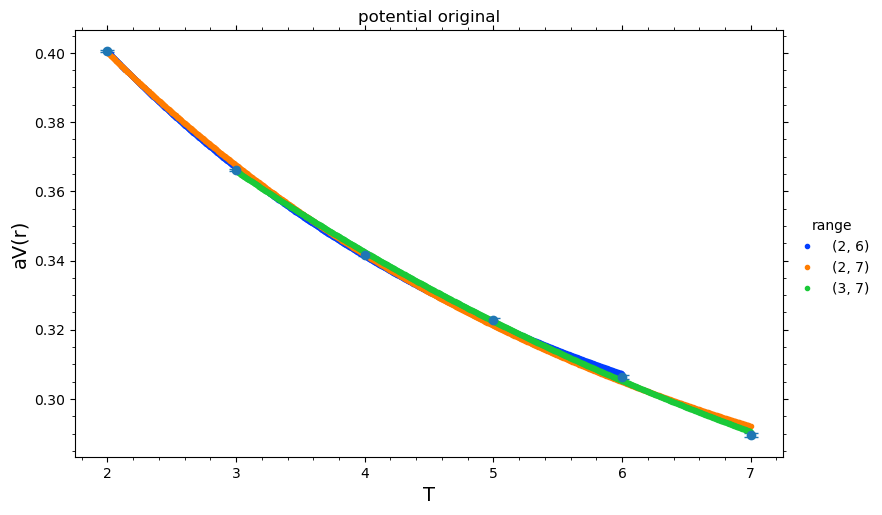

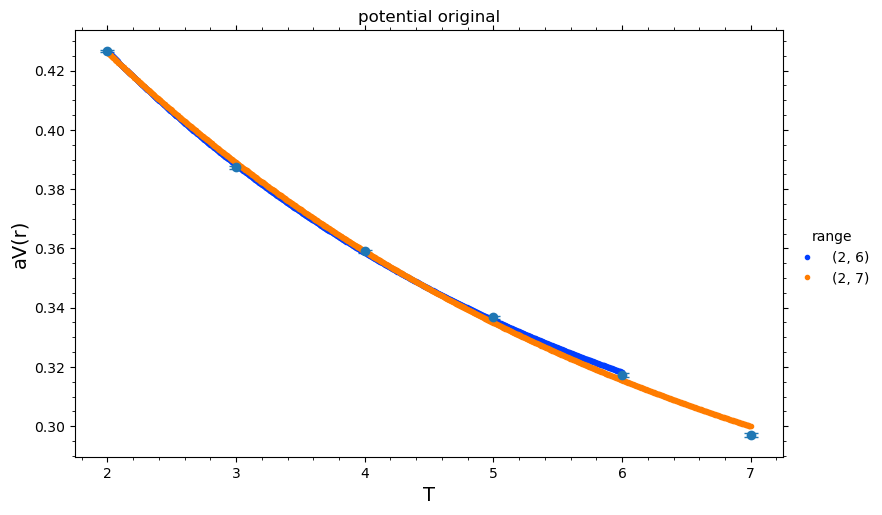

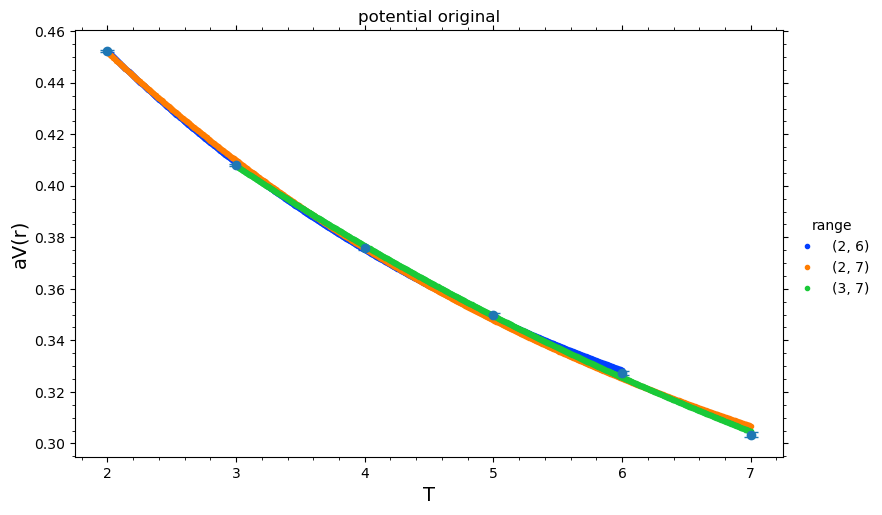

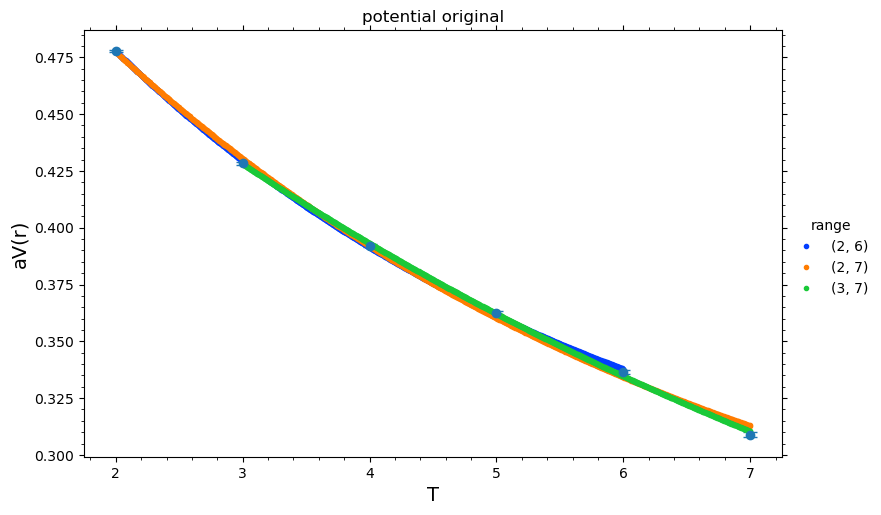

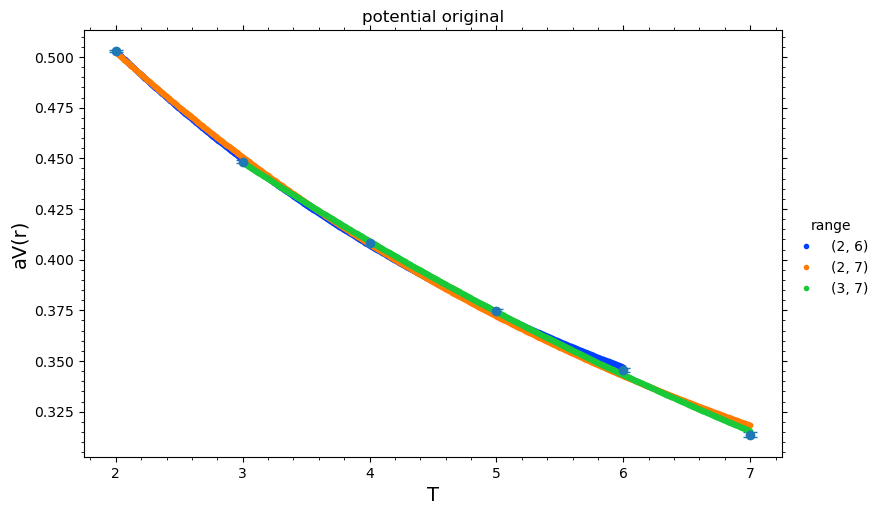

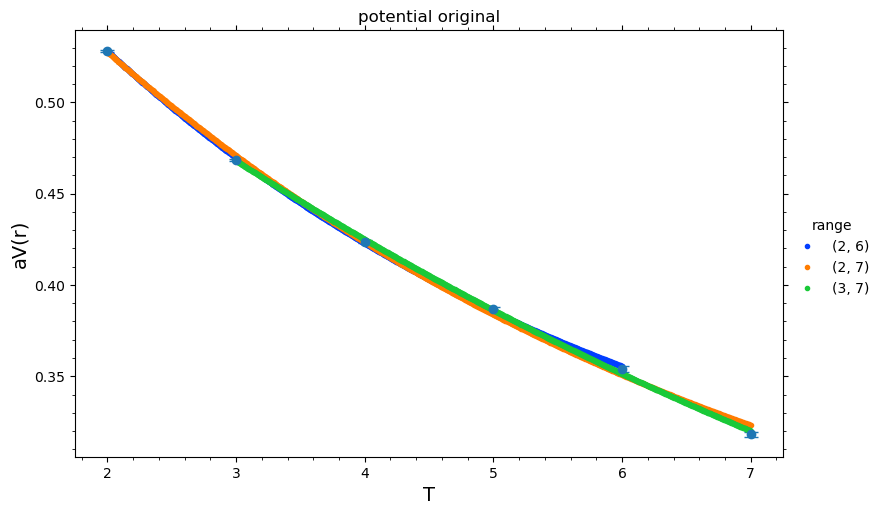

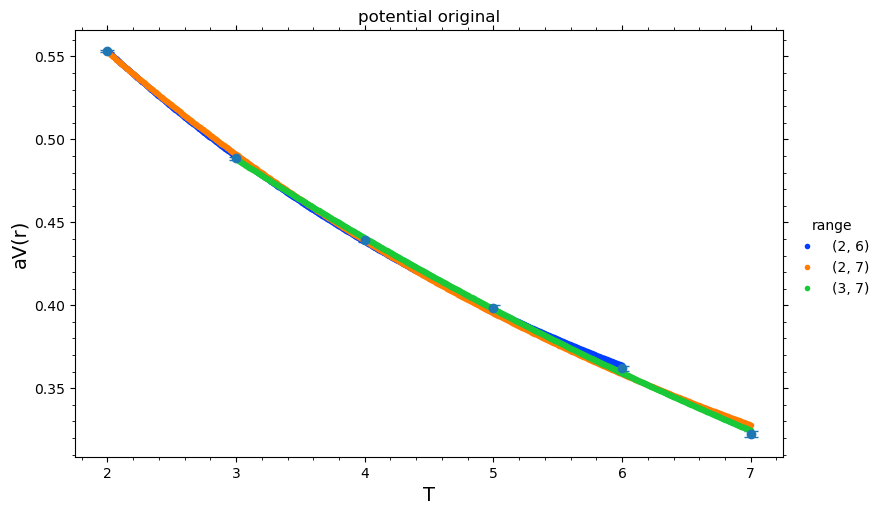

In [4]:
potential_gevp_T_fit('potential_gevp', '32^3x16', 'su2', 'qc2dstag', 16, '', 'mu0.15', 'HYP1_alpha=1_1_0.5_APE_alpha=0.6', '', 'original', copy=None)

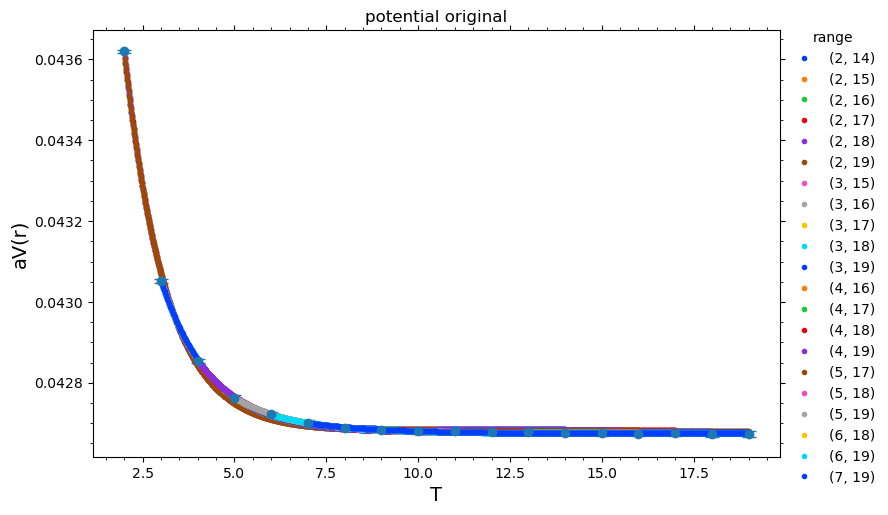

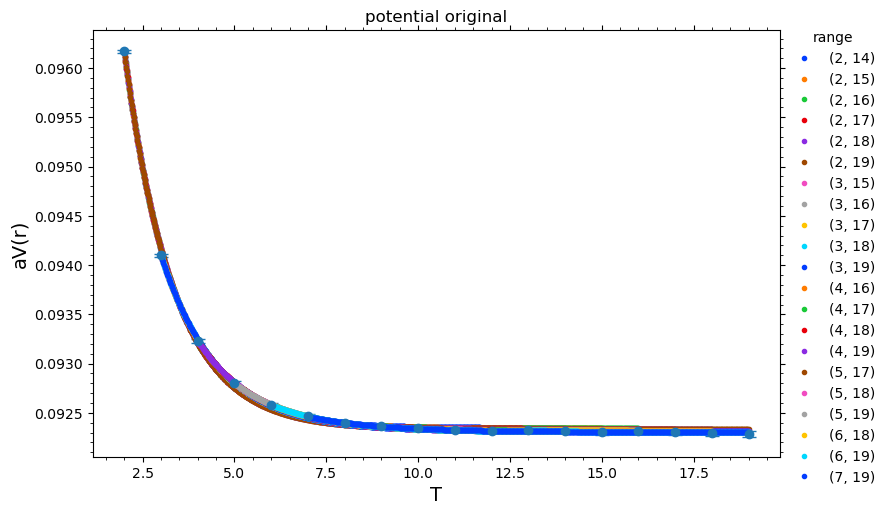

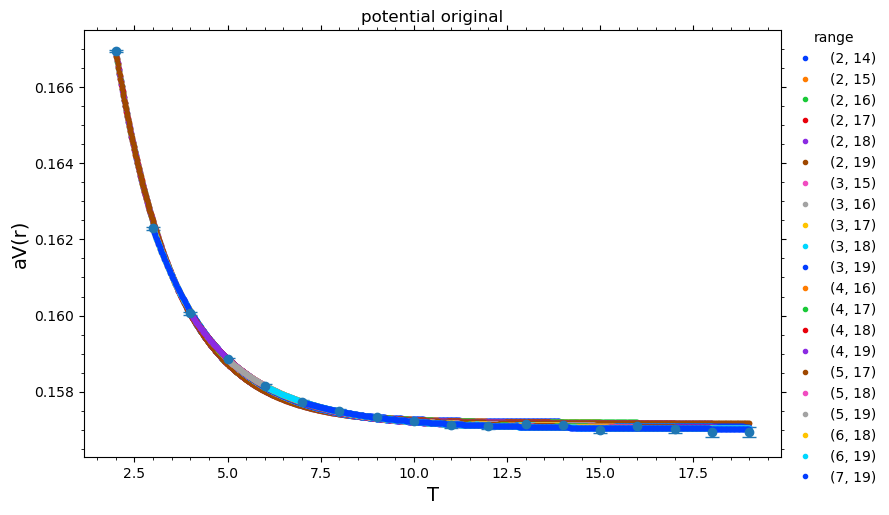

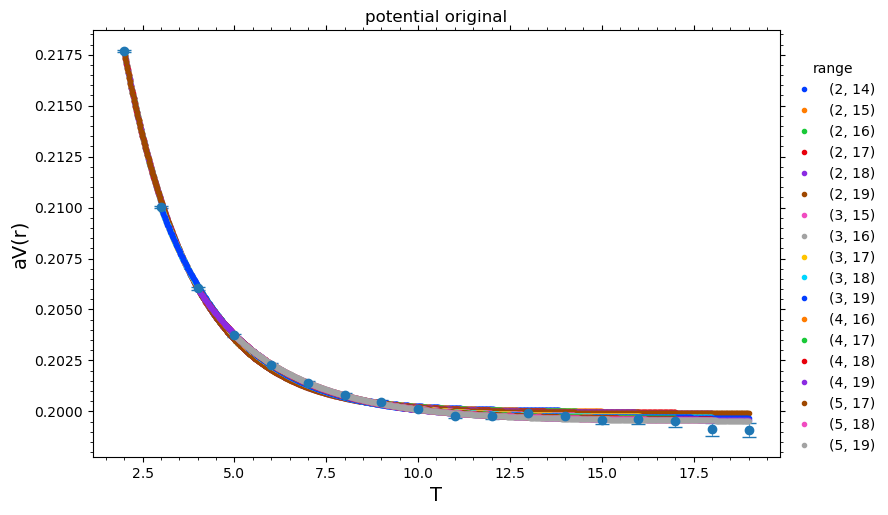

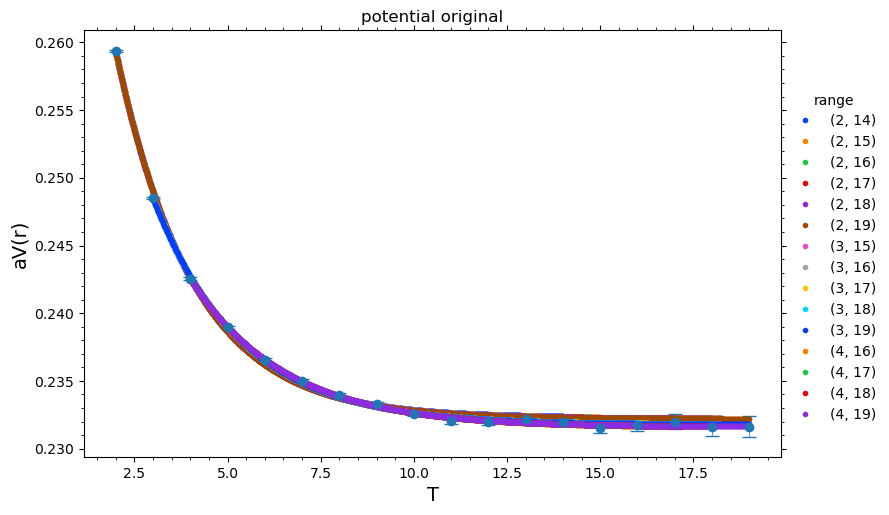

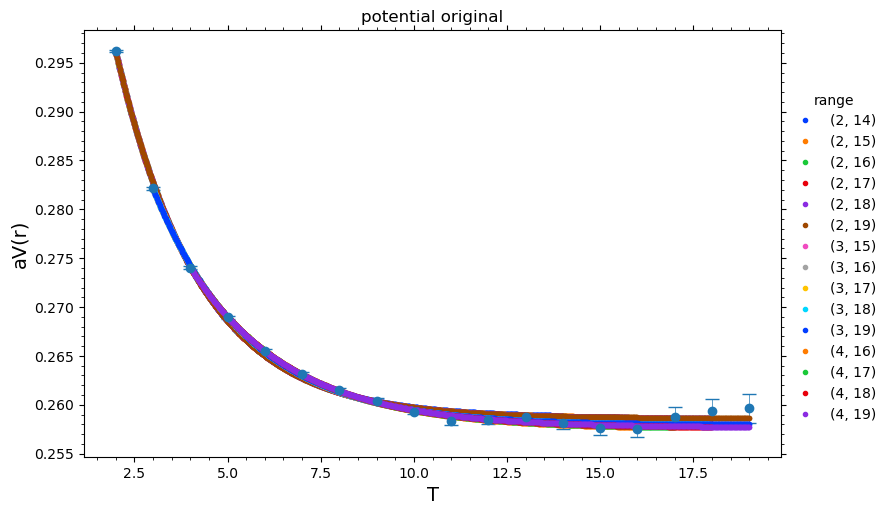

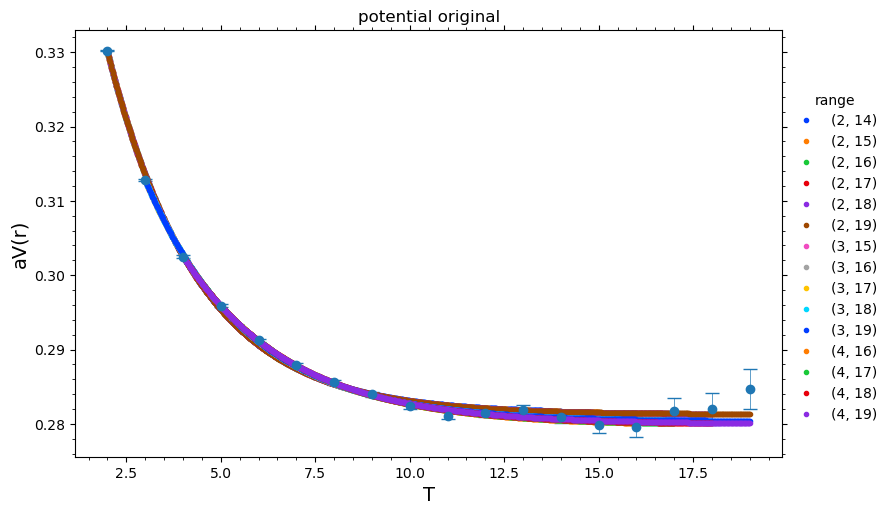

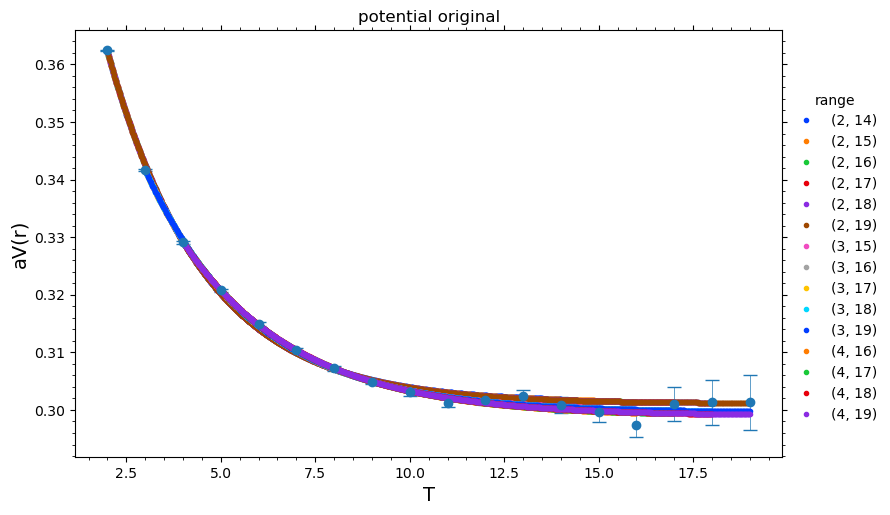

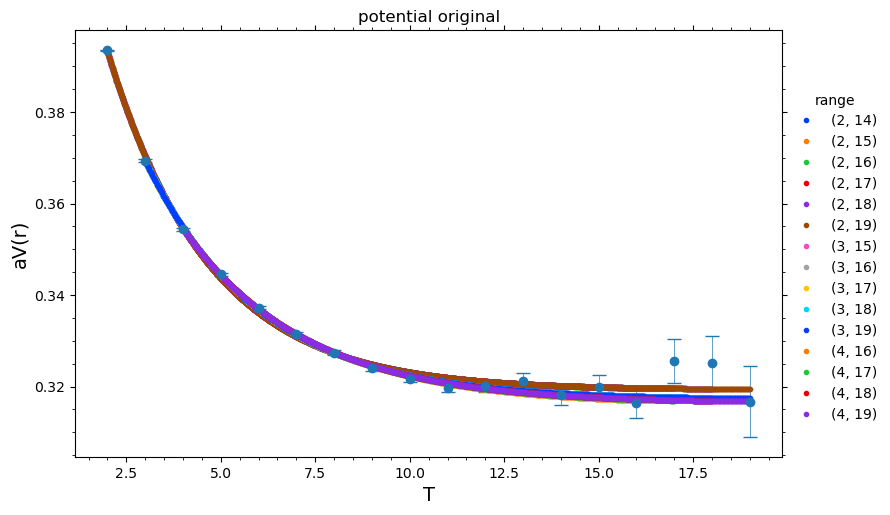

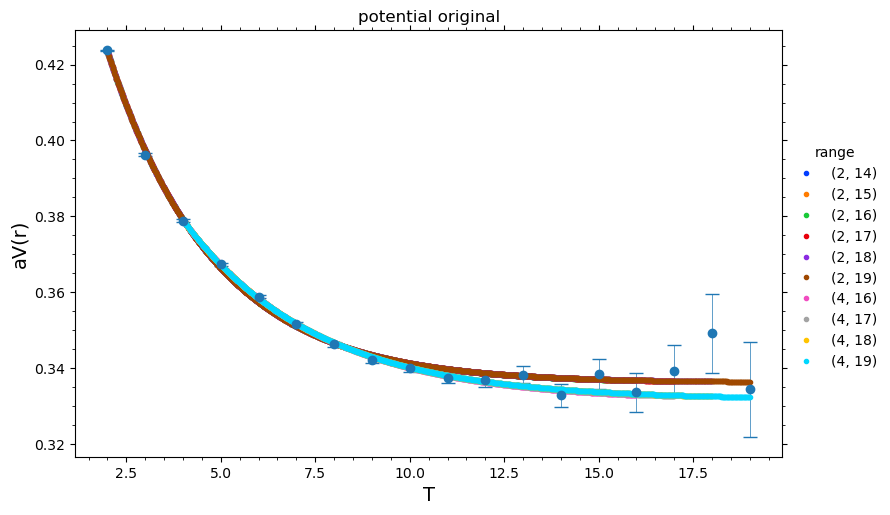

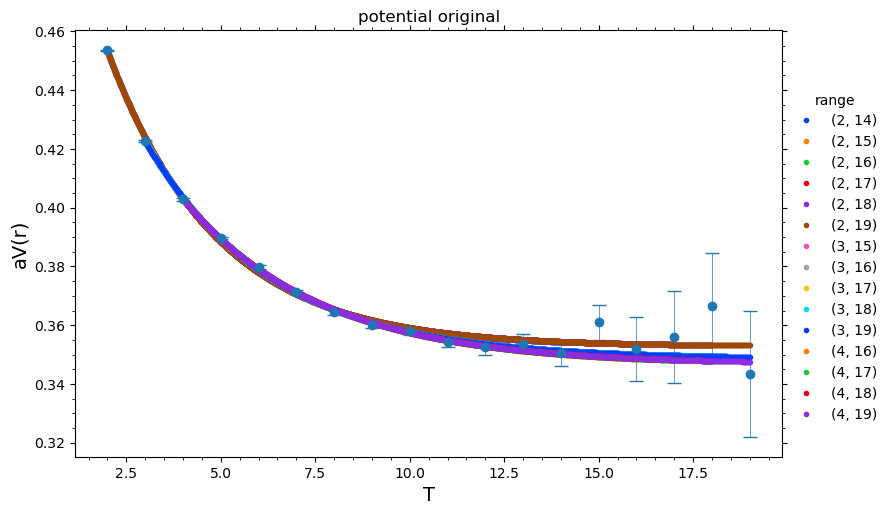

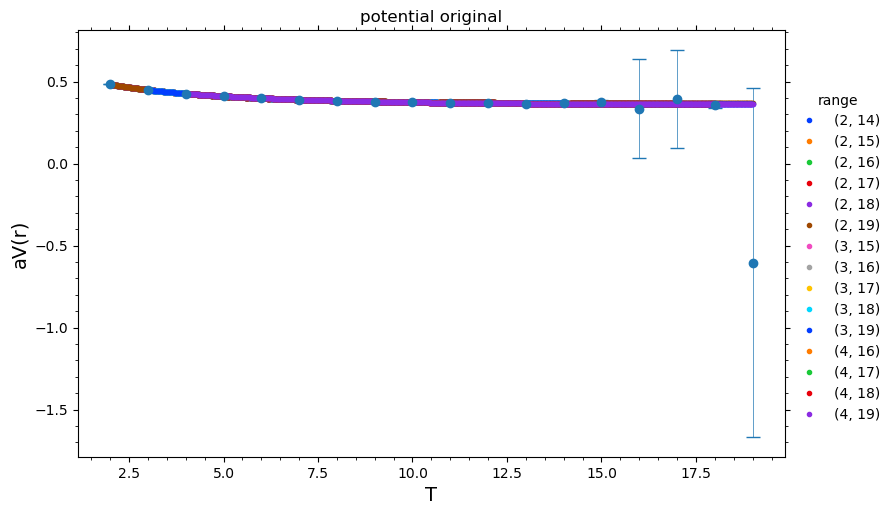

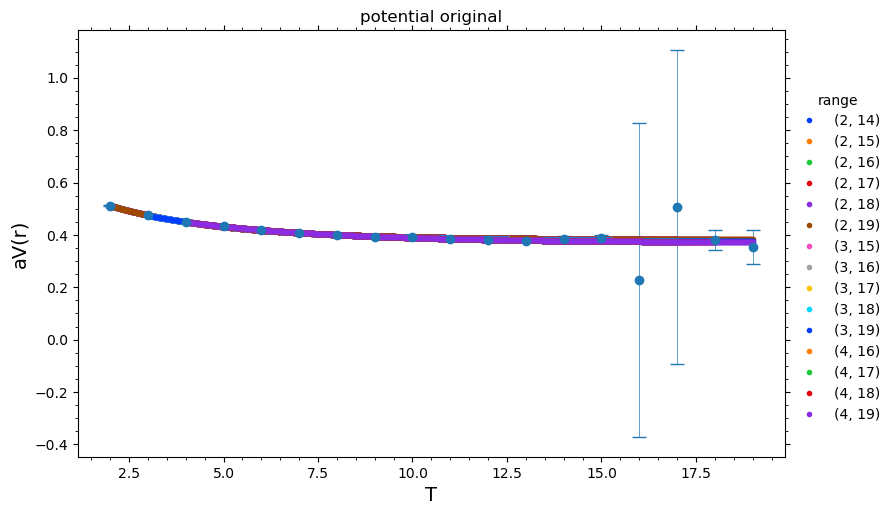

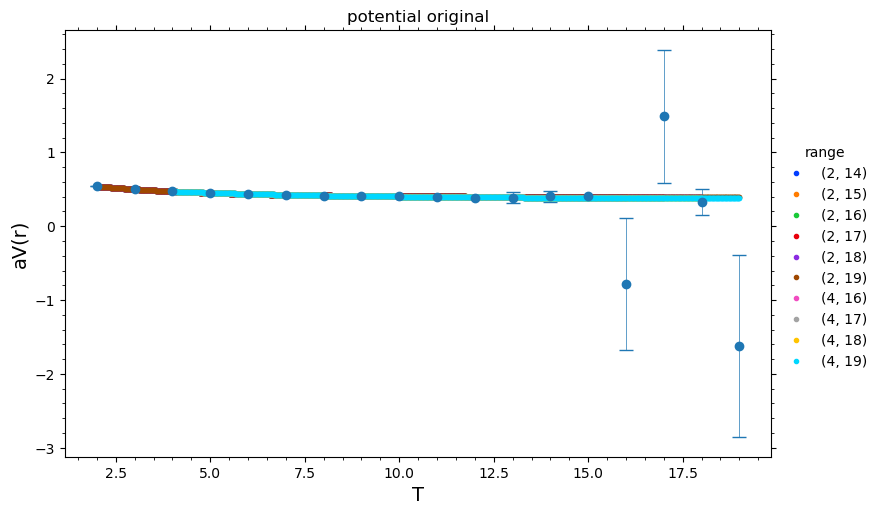

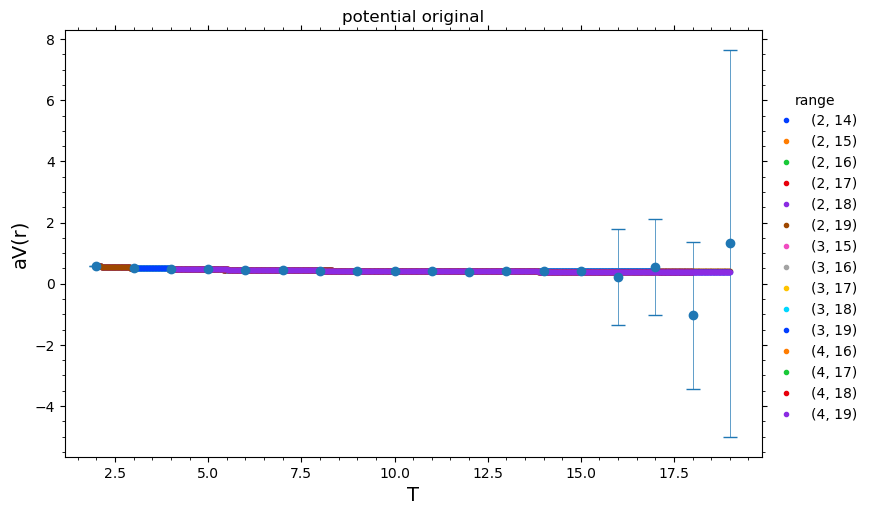

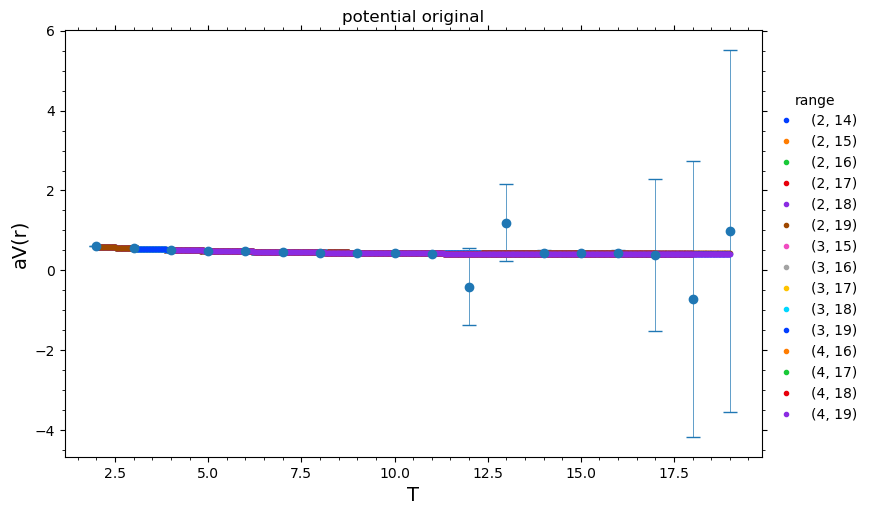

In [5]:
potential_gevp_T_fit('potential_gevp', '32^3x40', 'su2', 'qc2dstag', 32, '', 'mu0.20', 'HYP1_alpha=1_1_0.5_APE_alpha=0.6', '', 'original', copy=None)

In [15]:
potential_T_fit('16^4', 16, '6.0', 'HYP1_alpha=1_1_0.5_APE_alpha=0.6', '/', 'original')

               r/a  T     aV(r)        err      beta
smearing_step                                       
0                1  1  0.083601   0.000021  beta=6.0
0                1  2  0.058472   0.000023  beta=6.0
0                1  3  0.053752   0.000023  beta=6.0
0                1  4  0.052663   0.000024  beta=6.0
0                1  5  0.052337   0.000024  beta=6.0
...            ... ..       ...        ...       ...
151              8  1 -0.102793  26.090399  beta=6.0
151              8  2  0.052197   1.259555  beta=6.0
151              8  4 -0.017383   1.321386  beta=6.0
151              8  6 -0.157152   1.795729  beta=6.0
151              8  7 -0.056695   1.489850  beta=6.0

[872 rows x 5 columns]


ValueError: No objects to concatenate

In [3]:
potential_T_fit('16^4', 16, '6.0', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole')

In [4]:
potential_T_fit('24^4', 24, '6.0', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole')

: 

In [ ]:
potential_T_fit('32^4', 32, '6.0', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole')

In [ ]:
potential_T_fit('28^4', 28, '6.1', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole')

In [ ]:
potential_T_fit('32^4', 32, '6.2', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole')

In [ ]:
potential_T_fit('36^4', 36, '6.3', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole')

In [ ]:
potential_T_fit('40^4', 40, '6.4', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole')